In [101]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt 
import logging
import matplotlib.dates as mdates
   
PATH_TO_DATA = r'/Users/nadiiapoliakovska/Documents/Air_Pollution (Justin)'
PM25_pattern = r'Cal_PM2.5*.csv'
CO_pattern = r'Cal_CO*.csv'
EPA_O_3_pattern = r'EPA_O_3.csv'
    
class State:

    def __init__(self, path_to_folder, pattern):
        self.path_to_folder = path_to_folder
        self.pattern = pattern
    
    def create_df(self): 
        '''path_to_folder can be assigned to PATH_TO_DATA
        pattern for California is
        r'Cal_PM2.5*.csv' or
        r'Cal_CO*.csv' or
        r'EPA_O_3.csv' '''
        logging.basicConfig(level=logging.ERROR)
        files = glob.glob(os.path.join(self.path_to_folder, self.pattern))
        if len(files) > 1:
            df_list = []
            for i in files:
                df = pd.read_csv(i)
                df_list.append(df)
            big_df = pd.concat(df_list, ignore_index = True)
        elif len(files) == 1:
            big_df = pd.read_csv(files[0])
        else:
            big_df = "No files in the folder with this pattern"
        return big_df 
    
    def county_names(self):
        df = State(self.path_to_folder, self.pattern).create_df()
        return df['COUNTY'].unique()

In [102]:
class County(State):
    def __init__(self, path_to_folder, pattern, county): #county shoud be string
        super().__init__(path_to_folder, pattern)
        self.county = county
        
    def sub_df(self): 
        logging.basicConfig(level=logging.ERROR)
        df = super().create_df()
        if self.county in df['COUNTY'].unique():
            county_df = df.loc[df['COUNTY'] == self.county]
            county_df.loc[:,'Date'] = county_df.loc[:, 'Date'].apply(pd.to_datetime)
            county_df = county_df.sort_values(by=['Date'])
            ind = np.arange(0, len(county_df))
            county_df.set_index(ind, inplace = True)
        else: 
            print("No such county in this dataframe")
        return county_df
    
    def diff_values(self):
        logging.basicConfig(level=logging.ERROR)
        df = self.sub_df()
        l =[]
        for i in df.columns:
            if len(df[i].unique())!=1 :
                l.append(i)
        return l
    
    def sub_df_unique(self):
        df = self.sub_df()
        df_unique = df[['Date', 'Daily Mean PM2.5 Concentration', 'Site Name', 'SITE_LATITUDE', 'SITE_LONGITUDE']]
        df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)
        df_unique = df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
        df_unique['Month'] = pd.DatetimeIndex(df_unique['Date']).month
        df_unique['Year_Month'] = pd.DatetimeIndex(df_unique['Date']).to_period('M')
        df_unique['Year'] = pd.DatetimeIndex(df_unique['Date']).year
        return df_unique
    
    def preprocessed(self):
        logging.basicConfig(level=logging.ERROR)
        county_df_unique = self.sub_df()
           
        #county_df_unique = county_df[self.diff_values()]    
            
        if (county_df_unique['UNITS'].unique() != 'ug/m3 LC').any() or (len(county_df_unique['UNITS'].unique())==2):
            county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']
            county_df_unique['UNITS'] = county_df_unique['UNITS'].replace('ppm', 'ug/m3 LC')
        county_df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)
        
        if county_df_unique['Site Name'].isna().unique().all():
            county_df_unique == county_df_unique
        elif "Site Name" in county_df_unique.columns:
            county_df_unique = county_df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
        elif "COUNTY" in county_df_unique.columns:
            county_df_unique = county_df_unique.groupby(by= ["Date", "COUNTY"], as_index = False).mean()
        else:
            print('No COUNTY or Site Name in columns name of the ' + self.county + ' dataframe')
            for j in ["Site Name", "County"]:
                if j in county_df.columns:
                    county_df_unique = county_df_unique.join(county_df[j])
                    print("Joined " + j + " to " + self.county + '  unique dataframe')
                    county_df_unique = county_df_unique.groupby(by= ["Date", j], as_index = False).mean()
                else:
                    print("No " + j +" in "+ self.county + ' dataframe')
        
        county_df_unique['Month'] = pd.DatetimeIndex(county_df_unique['Date']).month
        county_df_unique['Year_Month'] = pd.DatetimeIndex(county_df_unique['Date']).to_period('M')
        county_df_unique['Year'] = pd.DatetimeIndex(county_df_unique['Date']).year

        return county_df_unique
    
    def county_plot_Daily_PM25(self):
        logging.basicConfig(level=logging.ERROR)
        df = self.preprocessed()
        %matplotlib inline
        plt.figure(figsize = (16, 10))
        x = df['Date']
        y = df['Daily Mean PM2.5 Concentration, ug/m3 LC']
        
            
        plt.stem(x, y, markerfmt=' ', basefmt=' ')  # No baseline for stems         
        # Beautify the x-axis by formatting dates
        #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())         
        plt.xlabel('Date', fontsize=20)
        plt.ylabel('Daily Mean PM2.5 Concentration, ug/m³ LC', fontsize=20)
        plt.title("Daily PM2.5 concentration changes with years for " + self.county + " county", fontsize=20)
        plt.grid()
        # Increase the font size of x and y ticks
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #California = super().create_df()
        #plt.xlim(pd.to_datetime(California["Date"].min(), format = '%m/%d/%Y'),
        #     pd.to_datetime(California["Date"].max(), format = '%m/%d/%Y'))
        #plt.ylim(California["Daily Mean PM2.5 Concentration"].min(), California["Daily Mean PM2.5 Concentration"].max())
        plt.savefig("Air_Pollution_plots/Daily PM2.5 concentration changes with years/Daily PM2.5 concentration changes with years for " + self.county + " county.pdf", format="pdf", bbox_inches="tight")
        # Show the plot
        plt.tight_layout()
        plt.show()

In [103]:
California = State(PATH_TO_DATA, PM25_pattern)
California_df = California.create_df()

In [150]:
California_df

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,...,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,Daily Max 8-hour CO Concentration,Month,Year_Month,Year
491079,2010-01-01 00:00:00,AQS,60374002,1,19.5,ug/m3 LC,67,Long Beach (North),1,100,...,6,California,37,Los Angeles,33.823760,-118.189210,NaN,1,2010-01,2010
494320,2010-01-01 00:00:00,AQS,60470003,3,22.1,ug/m3 LC,72,Merced-Coffee,1,100,...,6,California,47,Merced,37.281853,-120.433671,NaN,1,2010-01,2010
497335,2010-01-01 00:00:00,AQS,60650009,1,11.4,ug/m3 LC,48,Pechanga,1,100,...,6,California,65,Riverside,33.447867,-117.088649,NaN,1,2010-01,2010
489430,2010-01-01 00:00:00,AQS,60371103,1,13.1,ug/m3 LC,53,Los Angeles-North Main Street,1,100,...,6,California,37,Los Angeles,34.066590,-118.226880,NaN,1,2010-01,2010
490424,2010-01-01 00:00:00,AQS,60371201,3,16.6,ug/m3 LC,60,Reseda,1,100,...,6,California,37,Los Angeles,34.199250,-118.532760,NaN,1,2010-01,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44343,2021-12-31 00:00:00,AQS,60772010,3,7.6,ug/m3 LC,32,Manteca,1,100,...,6,California,77,San Joaquin,37.793392,-121.247874,NaN,12,2021-12,2021
11380,2021-12-31 00:00:00,AQS,60271023,1,7.7,ug/m3 LC,32,Bishop Tribe EMO,1,100,...,6,California,27,Inyo,37.362137,-118.417478,NaN,12,2021-12,2021
54480,2021-12-31 00:00:00,AQS,61070009,1,4.7,ug/m3 LC,20,Sequoia & Kings Canyon NPs - Ash Mountain,1,100,...,6,California,107,Tulare,36.489470,-118.829150,NaN,12,2021-12,2021
49103,2021-12-31 00:00:00,AQS,60850006,3,12.0,ug/m3 LC,50,San Jose - Knox Avenue,1,100,...,6,California,85,Santa Clara,37.338135,-121.849783,NaN,12,2021-12,2021


In [105]:
California_df['Month'] = pd.DatetimeIndex(California_df['Date']).month
California_df['Year_Month'] = pd.DatetimeIndex(California_df['Date']).to_period('M')
California_df['Year'] = pd.DatetimeIndex(California_df['Date']).year

In [106]:
California_df.loc[:,'Date'] = California_df.loc[:, 'Date'].apply(pd.to_datetime)
California_df = California_df.sort_values(by=['Date'])

In [108]:
California_df['UNITS'].unique()

array(['ug/m3 LC', 'ppm'], dtype=object)

In [109]:
if (California_df['UNITS'].unique() != 'ug/m3 LC').any() or (len(California_df['UNITS'].unique())==2):
    California_df.loc[California_df['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*California_df.loc[California_df['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']
    California_df['UNITS'] = California_df['UNITS'].replace('ppm', 'ug/m3 LC')

/var/folders/w0/vxwyx06126l456l8k0l589cc0000gn/T/ipykernel_49925/3313631676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  California_df.loc[California_df['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*California_df.loc[California_df['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


In [110]:
California_df['UNITS'].unique()

array(['ug/m3 LC'], dtype=object)

In [111]:
#Select data for the wet season
wet_df = California_df.loc[California_df['Month'].isin([1,2,3,11,12])]
wet_df

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,...,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,Daily Max 8-hour CO Concentration,Month,Year_Month,Year
491079,2010-01-01 00:00:00,AQS,60374002,1,19.5,ug/m3 LC,67,Long Beach (North),1,100,...,6,California,37,Los Angeles,33.823760,-118.189210,NaN,1,2010-01,2010
494320,2010-01-01 00:00:00,AQS,60470003,3,22.1,ug/m3 LC,72,Merced-Coffee,1,100,...,6,California,47,Merced,37.281853,-120.433671,NaN,1,2010-01,2010
497335,2010-01-01 00:00:00,AQS,60650009,1,11.4,ug/m3 LC,48,Pechanga,1,100,...,6,California,65,Riverside,33.447867,-117.088649,NaN,1,2010-01,2010
489430,2010-01-01 00:00:00,AQS,60371103,1,13.1,ug/m3 LC,53,Los Angeles-North Main Street,1,100,...,6,California,37,Los Angeles,34.066590,-118.226880,NaN,1,2010-01,2010
490424,2010-01-01 00:00:00,AQS,60371201,3,16.6,ug/m3 LC,60,Reseda,1,100,...,6,California,37,Los Angeles,34.199250,-118.532760,NaN,1,2010-01,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44343,2021-12-31 00:00:00,AQS,60772010,3,7.6,ug/m3 LC,32,Manteca,1,100,...,6,California,77,San Joaquin,37.793392,-121.247874,NaN,12,2021-12,2021
11380,2021-12-31 00:00:00,AQS,60271023,1,7.7,ug/m3 LC,32,Bishop Tribe EMO,1,100,...,6,California,27,Inyo,37.362137,-118.417478,NaN,12,2021-12,2021
54480,2021-12-31 00:00:00,AQS,61070009,1,4.7,ug/m3 LC,20,Sequoia & Kings Canyon NPs - Ash Mountain,1,100,...,6,California,107,Tulare,36.489470,-118.829150,NaN,12,2021-12,2021
49103,2021-12-31 00:00:00,AQS,60850006,3,12.0,ug/m3 LC,50,San Jose - Knox Avenue,1,100,...,6,California,85,Santa Clara,37.338135,-121.849783,NaN,12,2021-12,2021


In [133]:
from pathlib import Path
filepath = Path('California_df_pm25.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
California_df.to_csv(filepath)

In [112]:
#Calculate the mean PM2.5 value for wet season
mean_wet = wet_df['Daily Mean PM2.5 Concentration'].mean()
mean_wet

10.301864163991107

In [113]:
"""PM2.5 is used when describing pollutant levels both outdoor and indoor, where health impact from exposure 
considers amount of PM2.5 over a 24-hour period. Most studies indicate PM2.5 at or below 12 μg/m3 is considered 
healthy with little to no risk from exposure. If the level goes to or above 35 μg/m3 during a 24-hour period, 
the air is considered unhealthy and can cause issues for people with existing breathing issues such as asthma. 
Prolonged exposure to levels above 50 μg/m3 can lead to serious health issues and premature mortality. (c) 
https://www.indoorairhygiene.org/pm2-5-explained/
"""
healthy = 12 #Upper boundary of healthy PM2.5 concentration in μg/m3
unhealthy = 35 #Can cause issues for people with existing breathing issues such as asthma
danger = 50 #Prolonged exposure to levels above 50 μg/m3 can lead to serious health issues and premature mortality.

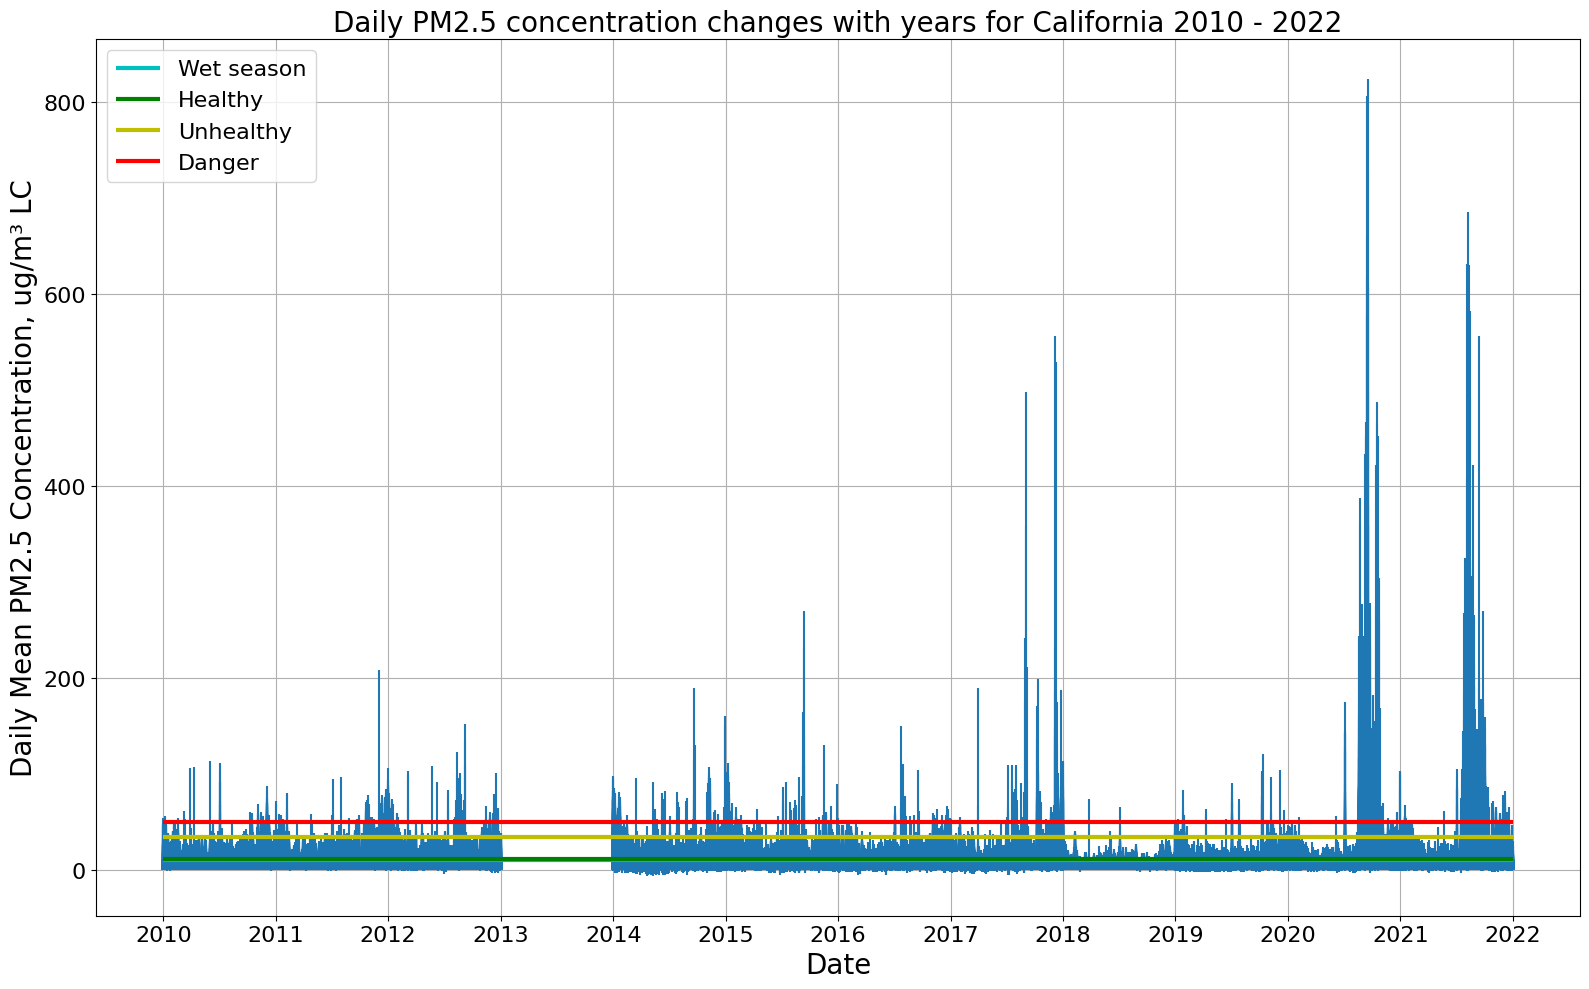

In [114]:
from matplotlib.dates import date2num

plt.figure(figsize = (16, 10))
x = California_df['Date']
y = California_df['Daily Mean PM2.5 Concentration']
        
plt.stem(x, y, markerfmt=' ', basefmt=' ')  # No baseline for stems  
plt.hlines(y=mean_wet, xmin=date2num(wet_df['Date'].min()), xmax=date2num(wet_df['Date'].max()),
           label = 'Wet season', linewidth=3, color='c')# Horizontal line for the wet value
plt.hlines(y=healthy, xmin=date2num(wet_df['Date'].min()), xmax=date2num(wet_df['Date'].max()),
           label = 'Healthy', linewidth=3, color='g')# Horizontal line for the healthy value
plt.hlines(y=unhealthy, xmin=date2num(wet_df['Date'].min()), xmax=date2num(wet_df['Date'].max()),
           label = 'Unhealthy', linewidth=3, color='y')# Horizontal line for the unhealthy value
plt.hlines(y=danger, xmin=date2num(wet_df['Date'].min()), xmax=date2num(wet_df['Date'].max()),
           label = 'Danger', linewidth=3, color='r')# Horizontal line for the danger value

plt.gca().xaxis.set_major_locator(mdates.YearLocator())         
plt.xlabel('Date', fontsize=20)
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m³ LC', fontsize=20)
plt.title("Daily PM2.5 concentration changes with years for California 2010 - 2022", fontsize=20)
plt.grid()
# Increase the font size of x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize = 16)
plt.savefig("Presentation/Daily PM2.5 concentration changes with years for California.pdf", format="pdf", bbox_inches="tight")
# Show the plot
plt.tight_layout()
plt.show()

/var/folders/w0/vxwyx06126l456l8k0l589cc0000gn/T/ipykernel_49925/1001456528.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month', y='Daily Mean PM2.5 Concentration', data=California_df, palette='Set3')


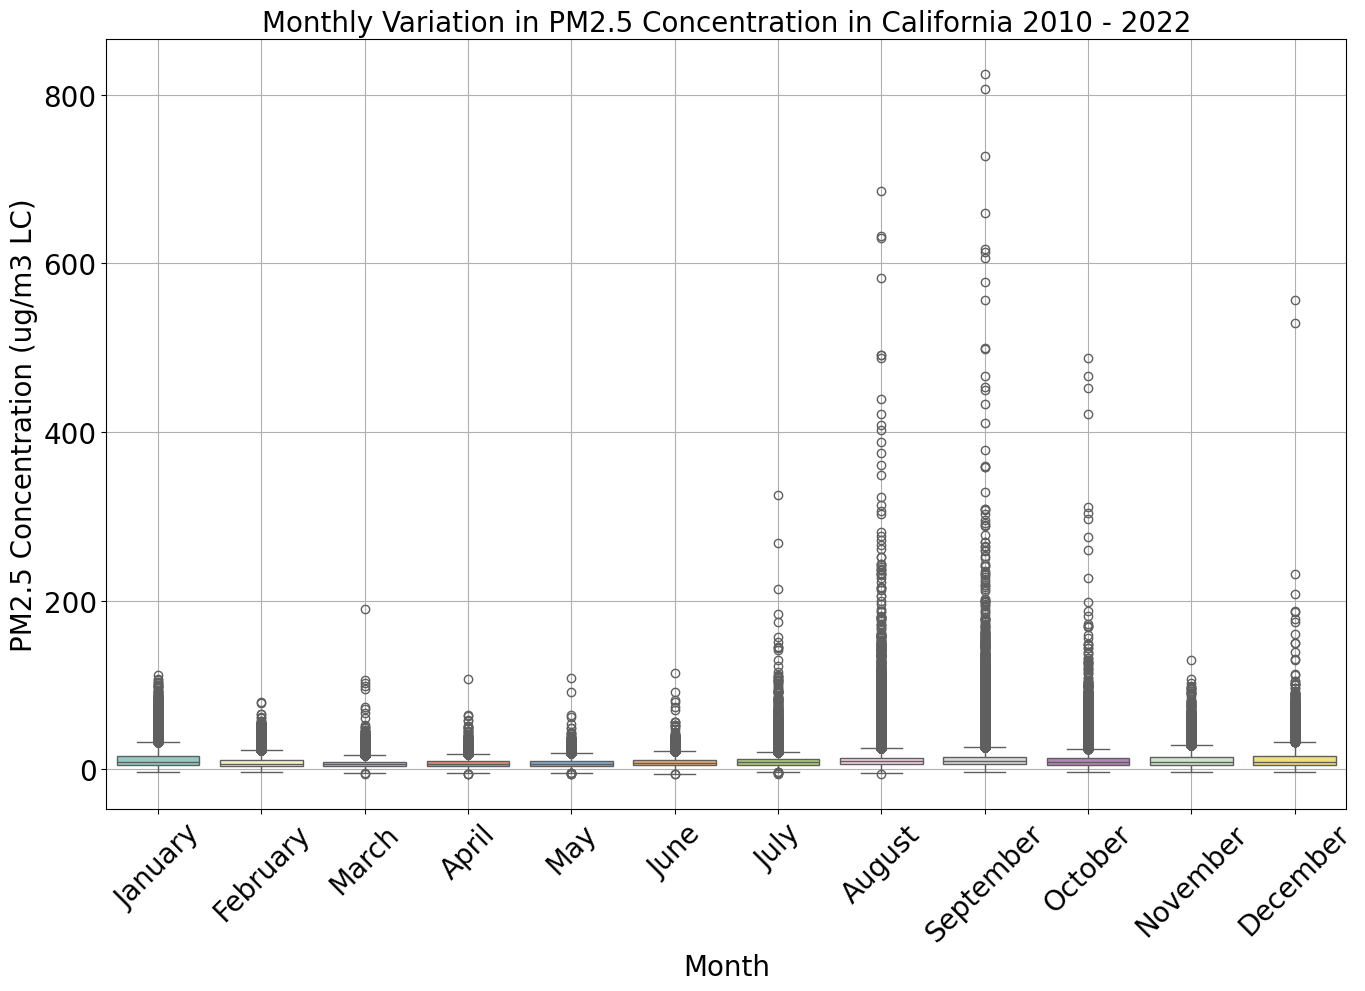

In [115]:
import seaborn as sns
import calendar
plt.figure(figsize=(16, 10))
sns.boxplot(x='Month', y='Daily Mean PM2.5 Concentration', data=California_df, palette='Set3')
plt.title('Monthly Variation in PM2.5 Concentration in California 2010 - 2022', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('PM2.5 Concentration (ug/m3 LC)', fontsize=20)
plt.grid()

plt.xticks(np.arange(0, 12), calendar.month_name[1:], rotation=45, fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("Presentation/Boxplot - Monthly Variation in PM2.5 Concentration for California.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [117]:
Alameda = County(PATH_TO_DATA, PM25_pattern,'Alameda')
Alameda_preprocessed = Alameda.preprocessed()
Alameda.county_plot_Daily_PM25()

/var/folders/w0/vxwyx06126l456l8k0l589cc0000gn/T/ipykernel_49925/3235727270.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


TypeError: agg function failed [how->mean,dtype->object]

In [22]:
Alameda_preprocessed

,Date,Site Name,Site ID,POC,"Daily Mean PM2.5 Concentration, ug/m3 LC",DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,SITE_LATITUDE,SITE_LONGITUDE,Daily Max 8-hour CO Concentration,Month,Year_Month,Year
0,2010-01-01,Berkeley,60012004.0,1.0,11.8,49.0,1.0,100.0,88502.0,37.877794,-122.301290,NaN,1,2010-01,2010
1,2010-01-01,Fremont - Chapel Way,60011001.0,3.0,14.5,56.0,1.0,100.0,88101.0,37.535833,-121.961823,NaN,1,2010-01,2010
2,2010-01-01,Livermore,60010007.0,1.0,18.5,64.0,1.0,100.0,88502.0,37.687526,-121.784217,NaN,1,2010-01,2010
3,2010-01-01,Oakland,60010009.0,3.0,12.2,51.0,1.0,100.0,88101.0,37.743065,-122.169935,NaN,1,2010-01,2010
4,2010-01-01,Oakland West,60010011.0,1.0,14.7,56.0,1.0,100.0,88502.0,37.814781,-122.282347,NaN,1,2010-01,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17111,2021-12-31,Laney College,60010012.0,3.0,3.0,13.0,1.0,100.0,88101.0,37.793624,-122.263376,NaN,12,2021-12,2021
17112,2021-12-31,Livermore,60010007.0,3.0,12.5,52.0,1.0,100.0,88101.0,37.687526,-121.784217,NaN,12,2021-12,2021
17113,2021-12-31,Oakland,60010009.0,3.0,8.3,35.0,1.0,100.0,88101.0,37.743065,-122.169935,NaN,12,2021-12,2021
17114,2021-12-31,Oakland West,60010011.0,3.0,4.7,20.0,1.0,100.0,88101.0,37.814781,-122.282347,NaN,12,2021-12,2021


In [118]:
CA = State(PATH_TO_DATA, PM25_pattern)
California = CA.create_df()
California

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,...,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,Daily Max 8-hour CO Concentration
0,1/1/2021,AQS,60010007,3,16.1,ug/m3 LC,59,Livermore,1,100,...,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217,NaN
1,1/2/2021,AQS,60010007,3,14.1,ug/m3 LC,55,Livermore,1,100,...,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217,NaN
2,1/3/2021,AQS,60010007,3,11.7,ug/m3 LC,49,Livermore,1,100,...,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217,NaN
3,1/4/2021,AQS,60010007,3,7.7,ug/m3 LC,32,Livermore,1,100,...,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217,NaN
4,1/5/2021,AQS,60010007,3,6.0,ug/m3 LC,25,Livermore,1,100,...,PM2.5 - Local Conditions,41860.0,"San Francisco-Oakland-Hayward, CA",6,California,1,Alameda,37.687526,-121.784217,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514905,11/28/2010,AQS,61131003,1,3.8,ug/m3 LC,16,Woodland-Gibson Road,1,100,...,PM2.5 - Local Conditions,40900.0,"Sacramento--Roseville--Arden-Arcade, CA",6,California,113,Yolo,38.661210,-121.732690,NaN
514906,12/4/2010,AQS,61131003,1,26.7,ug/m3 LC,82,Woodland-Gibson Road,1,100,...,PM2.5 - Local Conditions,40900.0,"Sacramento--Roseville--Arden-Arcade, CA",6,California,113,Yolo,38.661210,-121.732690,NaN
514907,12/10/2010,AQS,61131003,1,18.6,ug/m3 LC,65,Woodland-Gibson Road,1,100,...,PM2.5 - Local Conditions,40900.0,"Sacramento--Roseville--Arden-Arcade, CA",6,California,113,Yolo,38.661210,-121.732690,NaN
514908,12/22/2010,AQS,61131003,1,3.8,ug/m3 LC,16,Woodland-Gibson Road,1,100,...,PM2.5 - Local Conditions,40900.0,"Sacramento--Roseville--Arden-Arcade, CA",6,California,113,Yolo,38.661210,-121.732690,NaN


In [9]:
CA = State(PATH_TO_DATA, PM25_pattern)
CA.county_names()

array(['Alameda', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
       'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Los Angeles',
       'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Mono',
       'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas',
       'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
       'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo',
       'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz',
       'Shasta', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter',
       'Tehama', 'Trinity', 'Tulare', 'Ventura', 'Yolo', 'Alpine',
       'Allen', 'Bartholomew', 'Clark', 'Delaware', 'Dubois', 'Elkhart',
       'Floyd', 'Greene', 'Hamilton', 'Henry', 'Howard', 'LaPorte',
       'Madison', 'Marion', 'Monroe', 'Porter', 'St. Joseph', 'Spencer',
       'Sullivan', 'Tippecanoe', 'Vanderburgh', 'Vigo', 'Whitley'],
      dtype=object)

<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


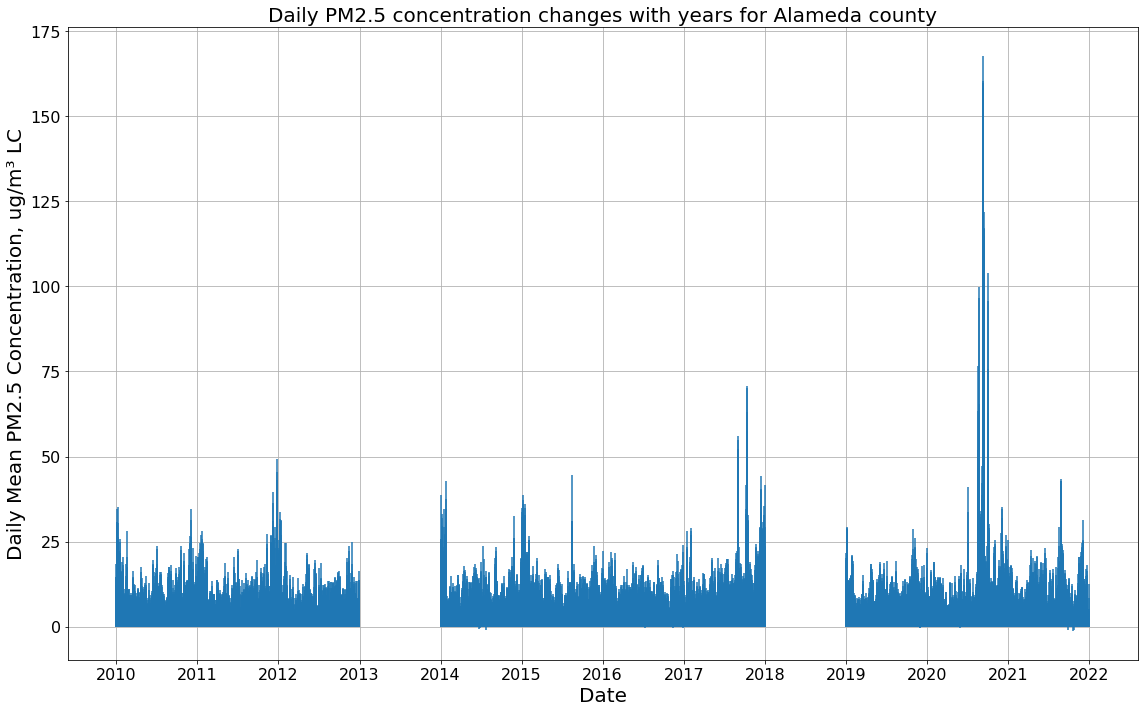

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


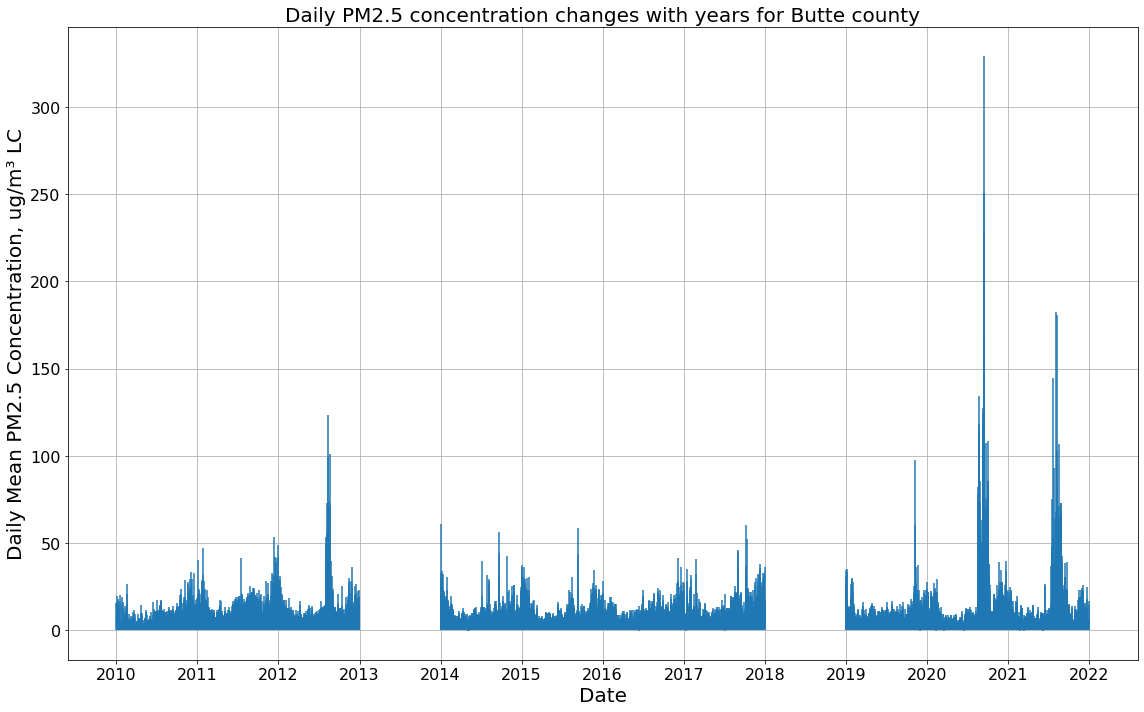

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


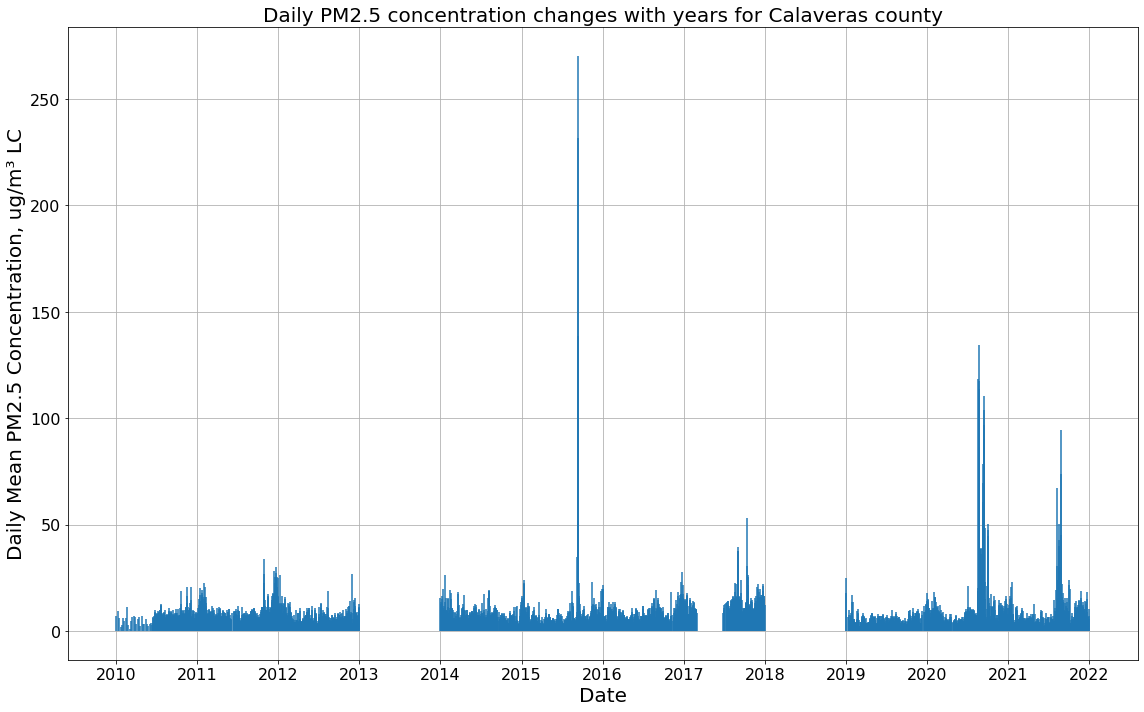

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


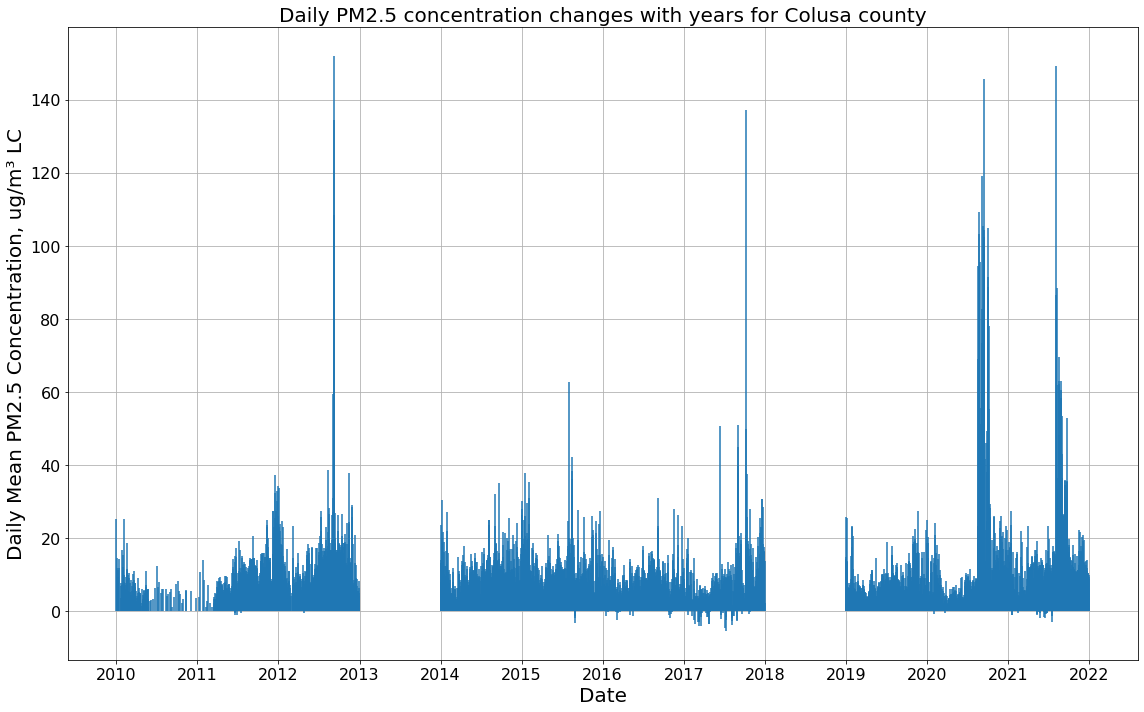

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


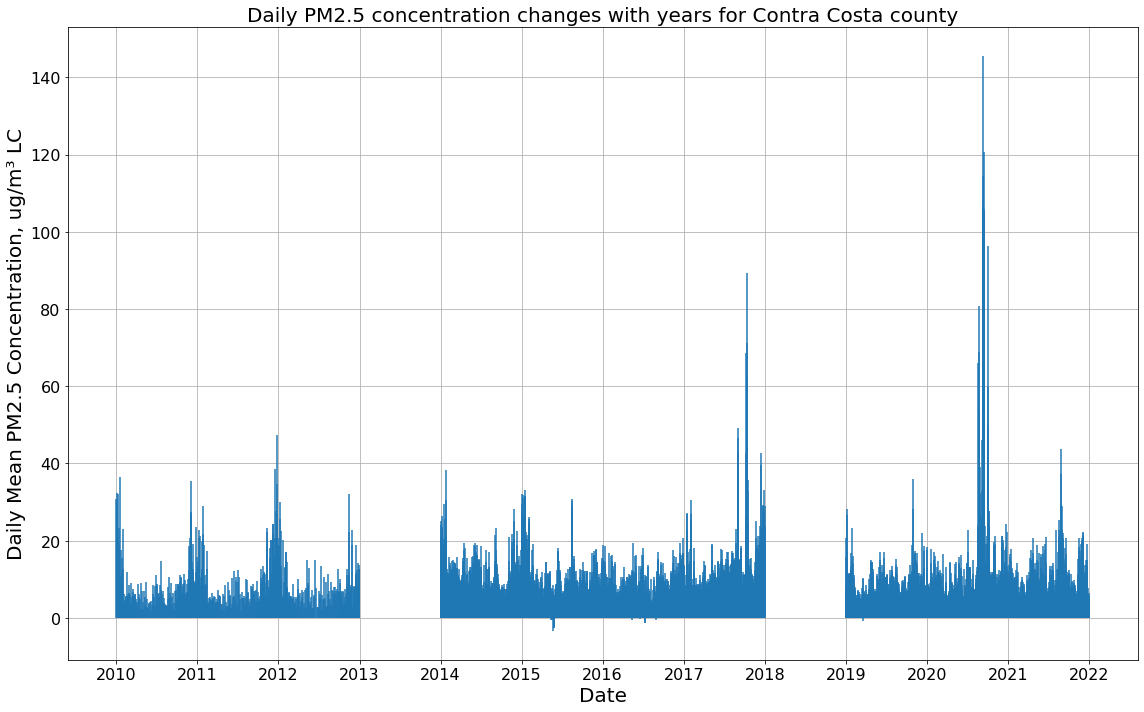

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


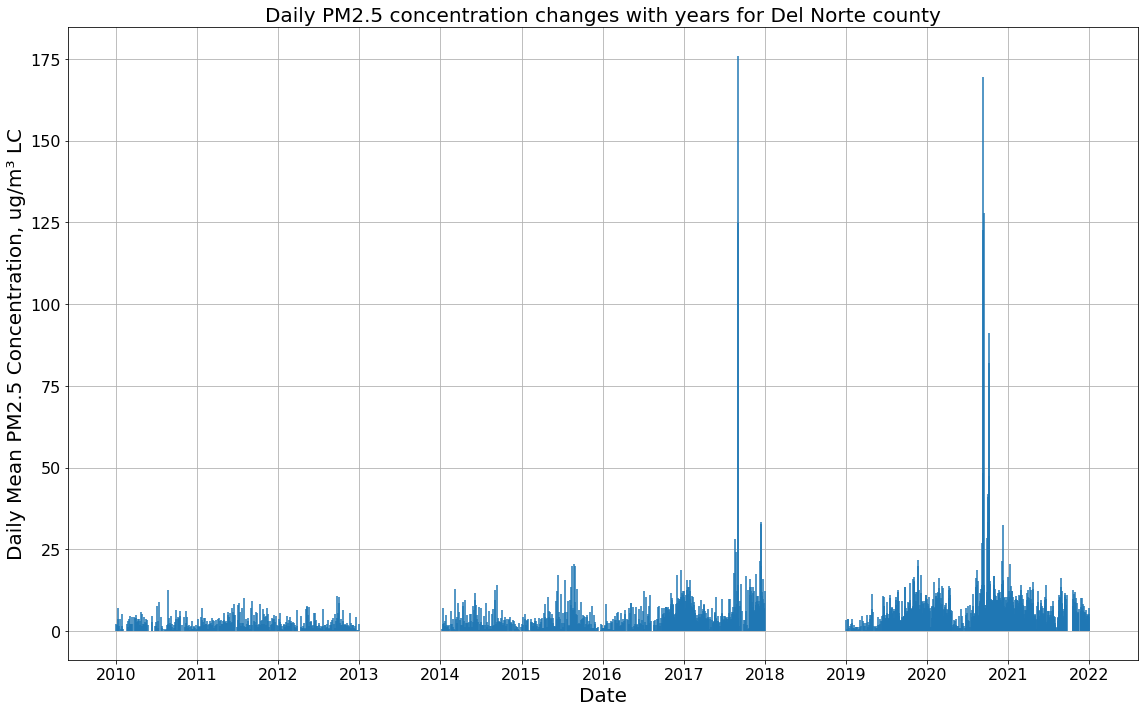

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


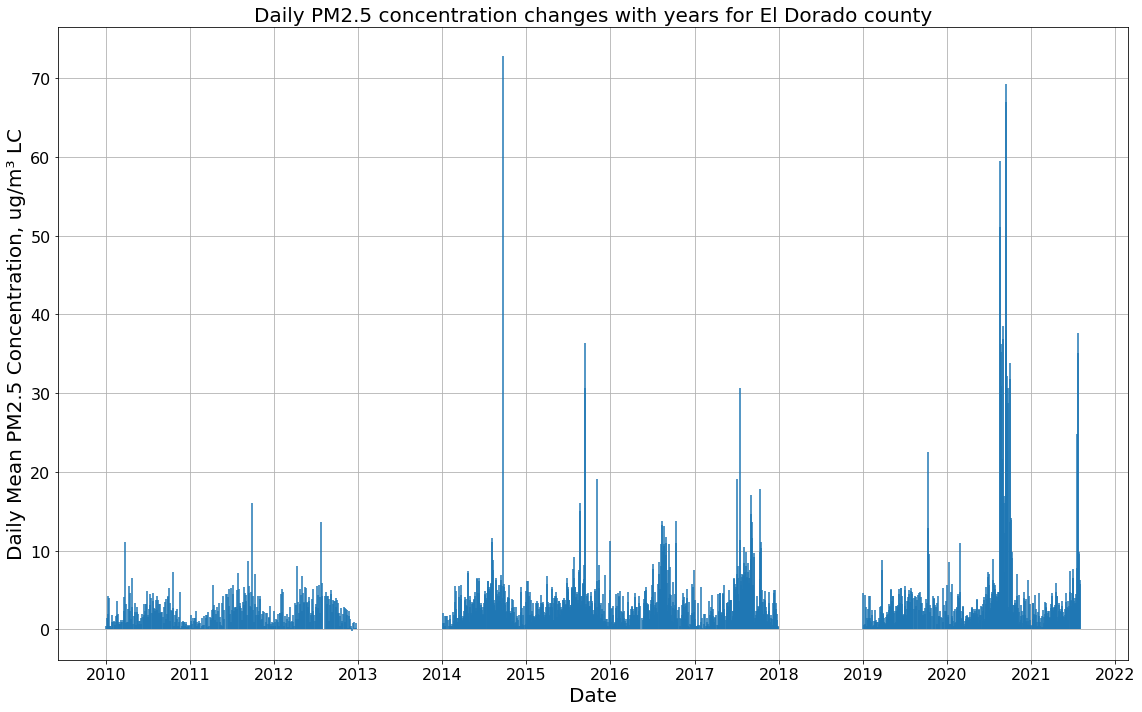

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


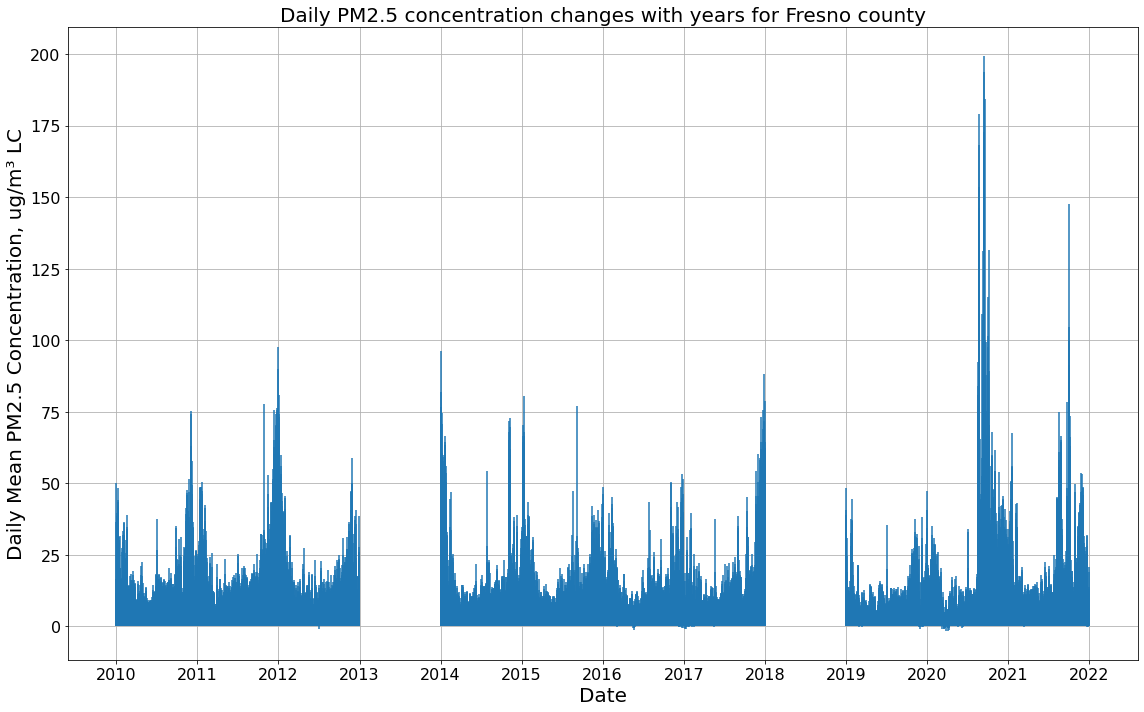

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


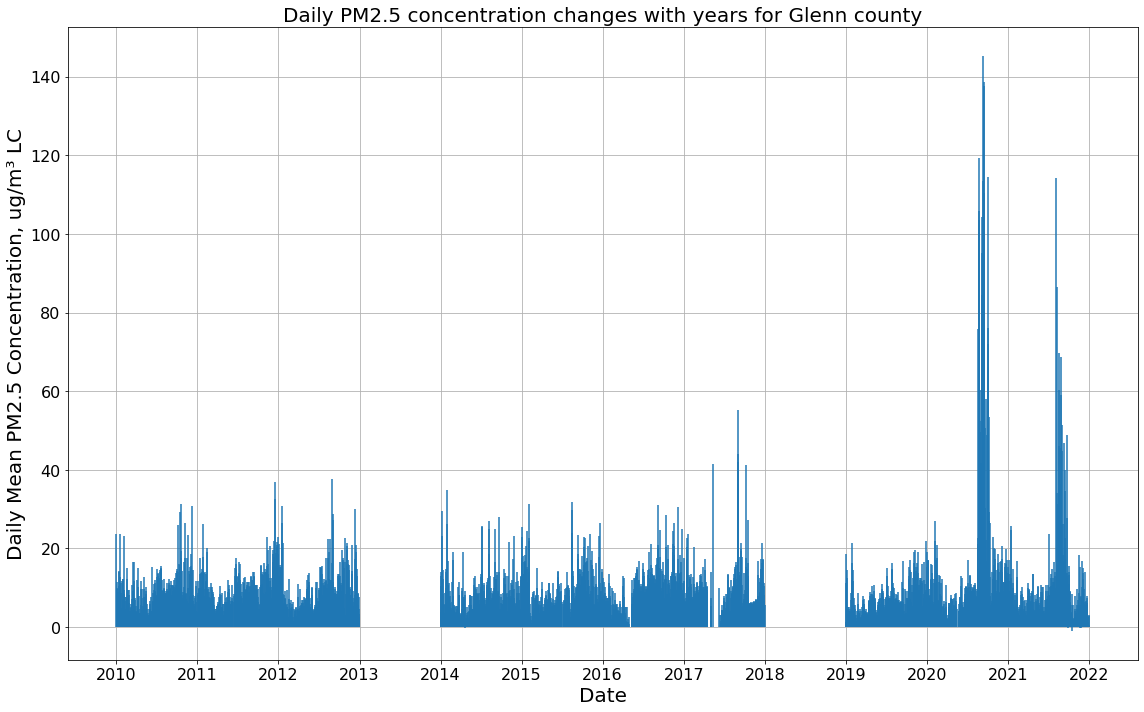

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


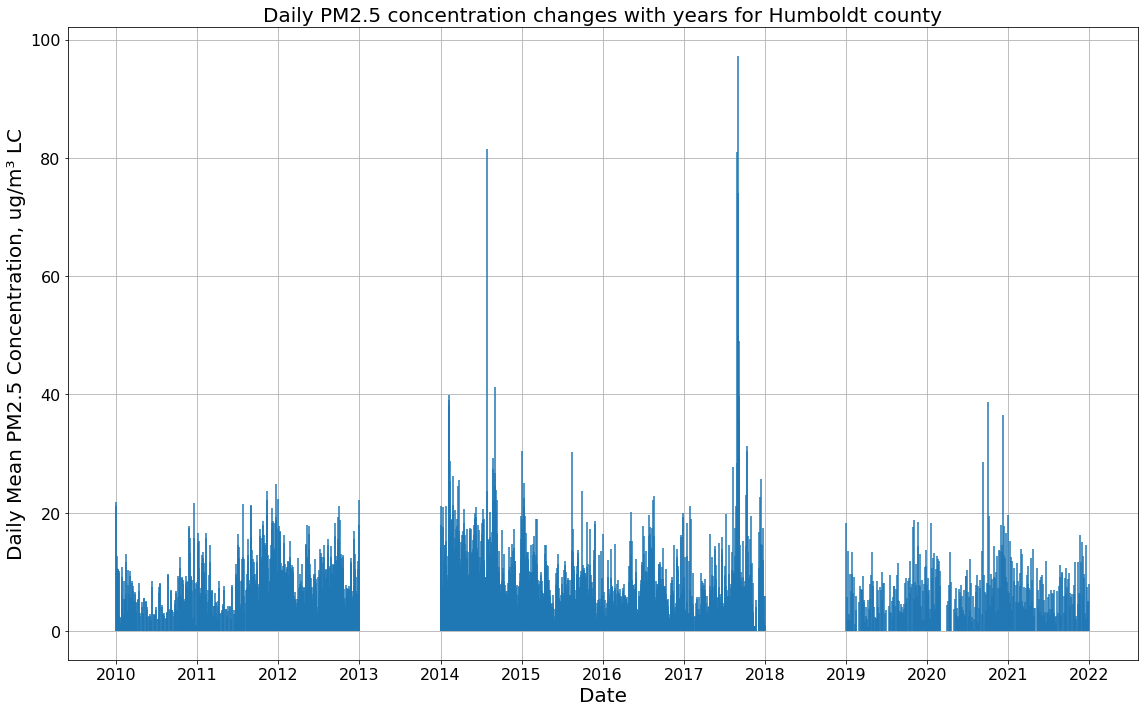

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


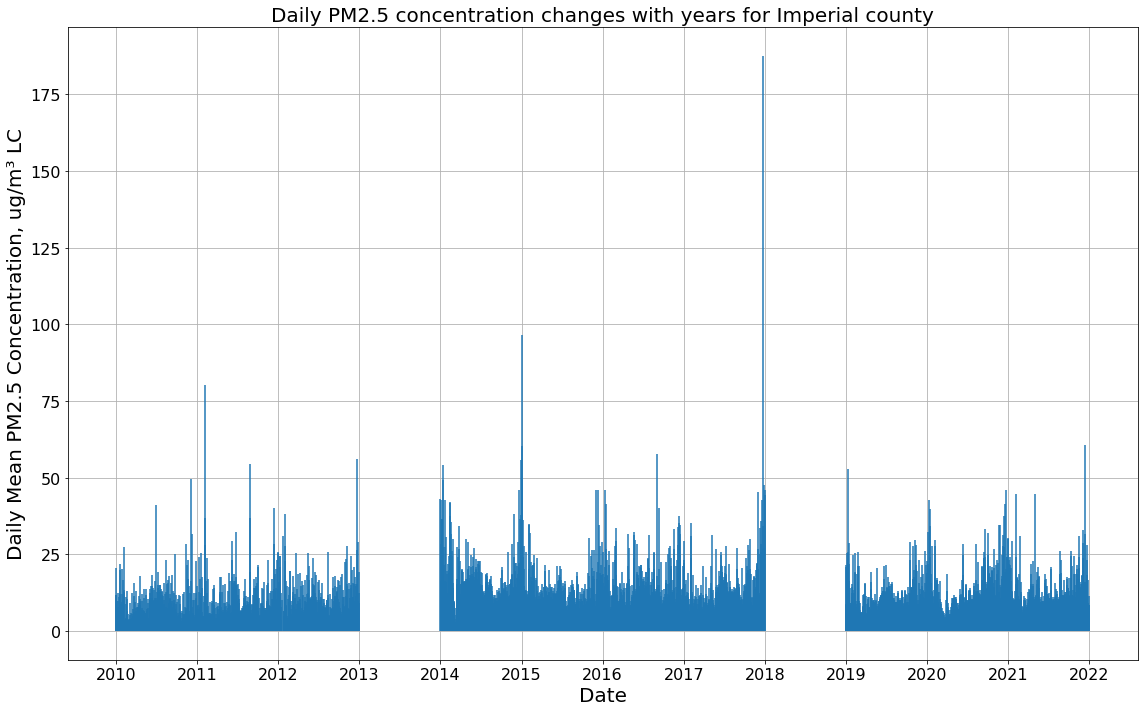

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


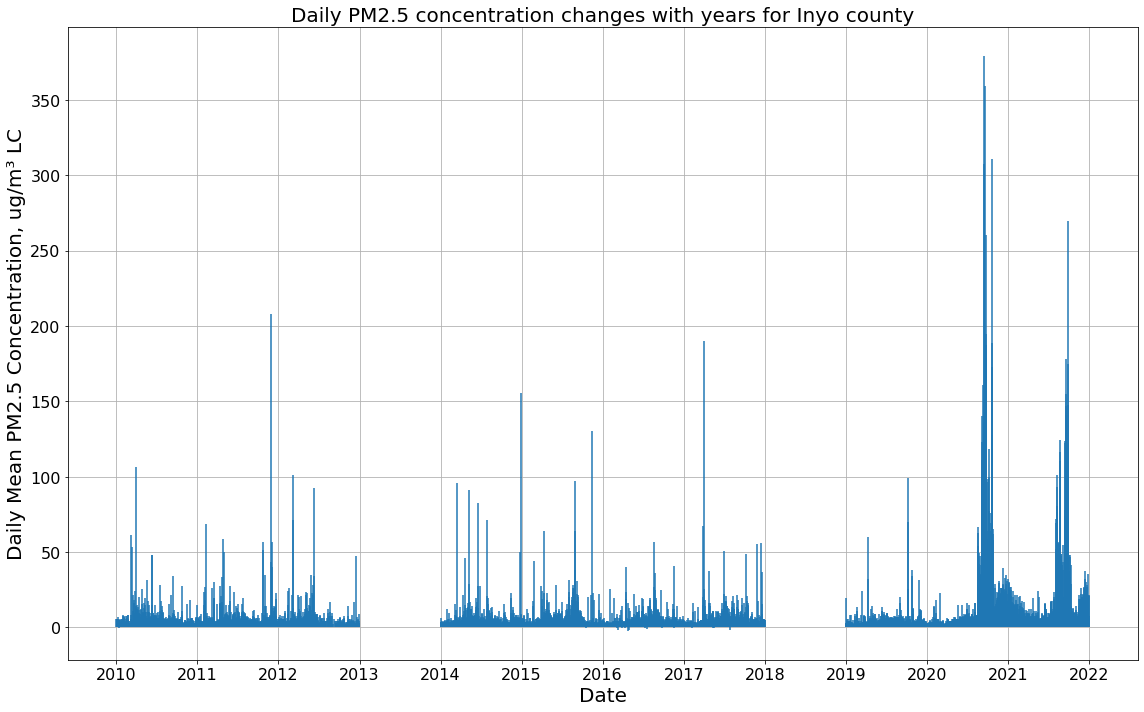

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


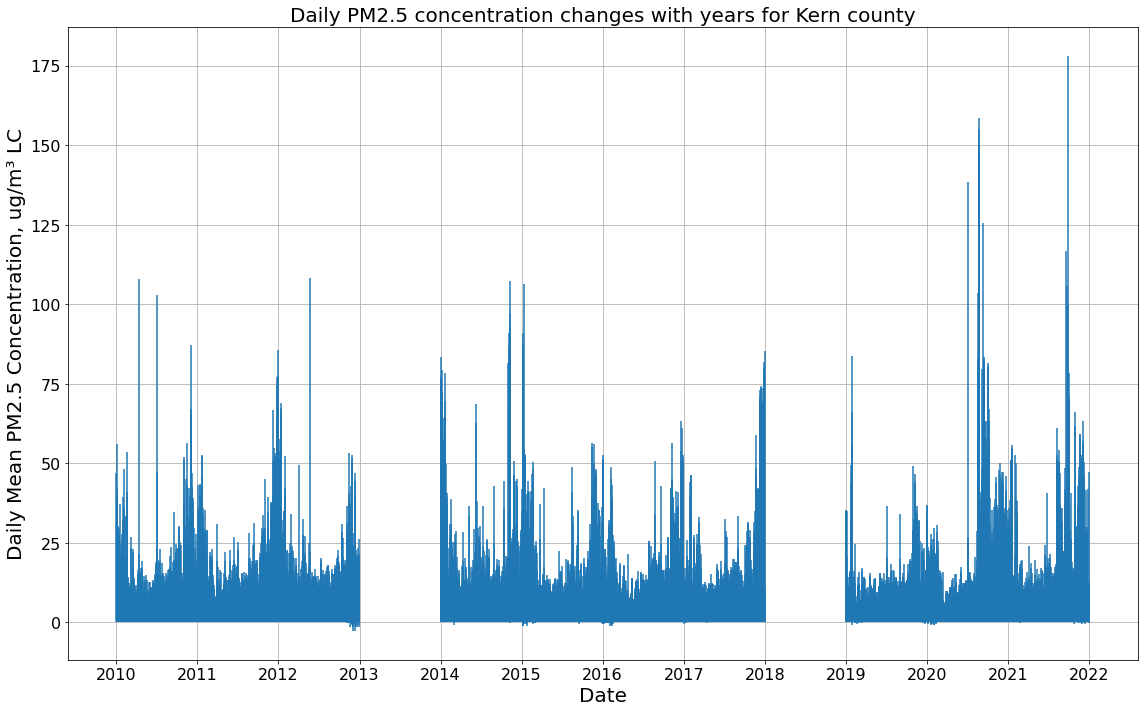

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


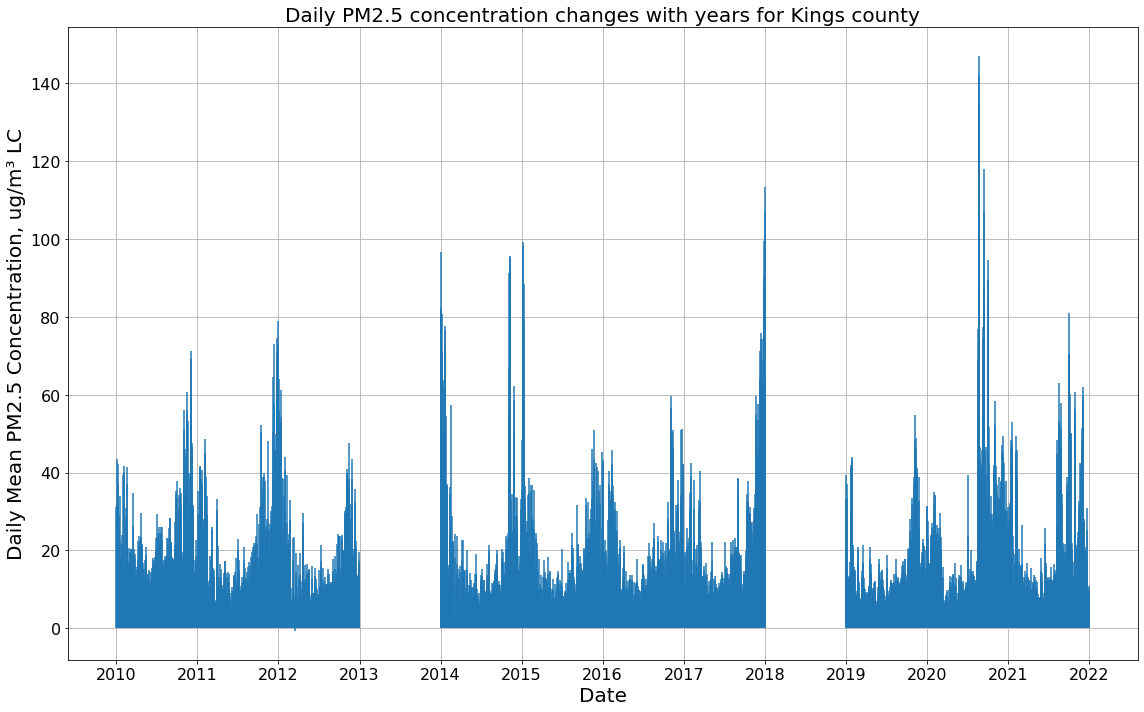

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


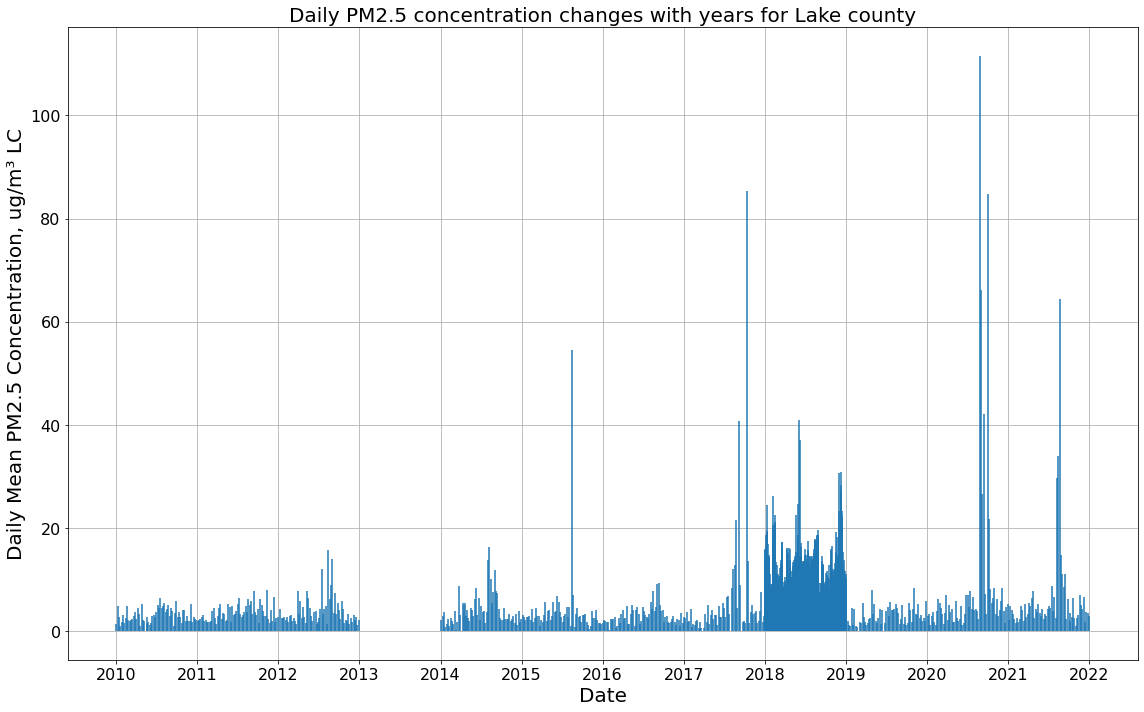

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


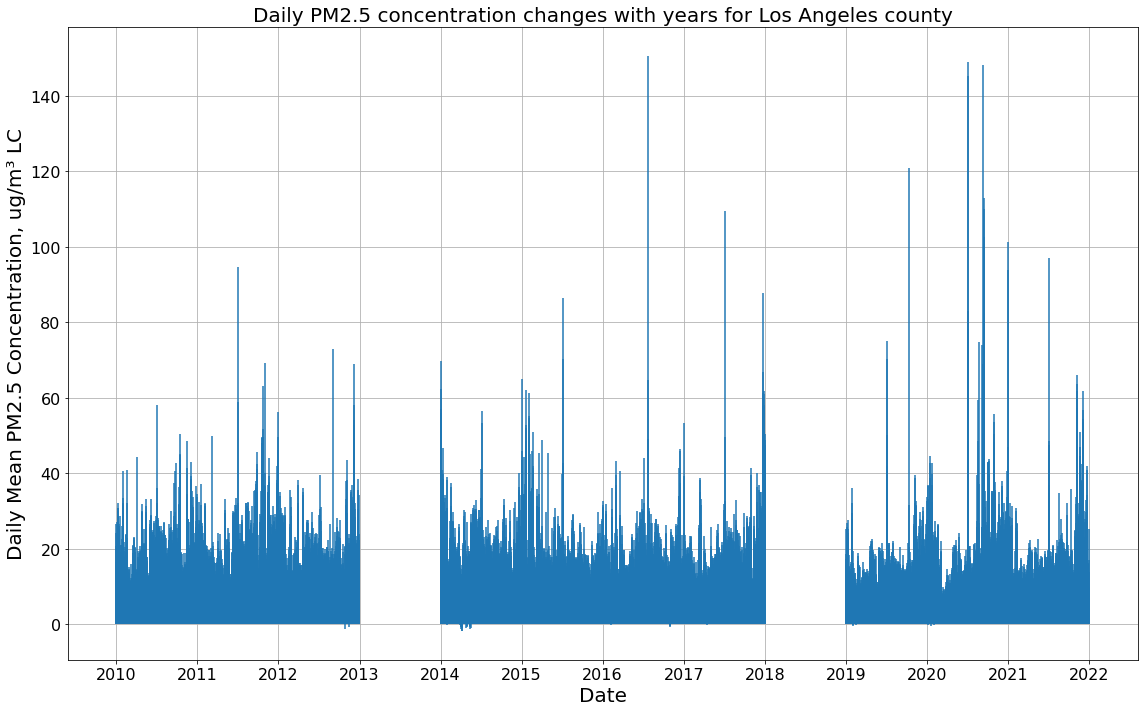

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


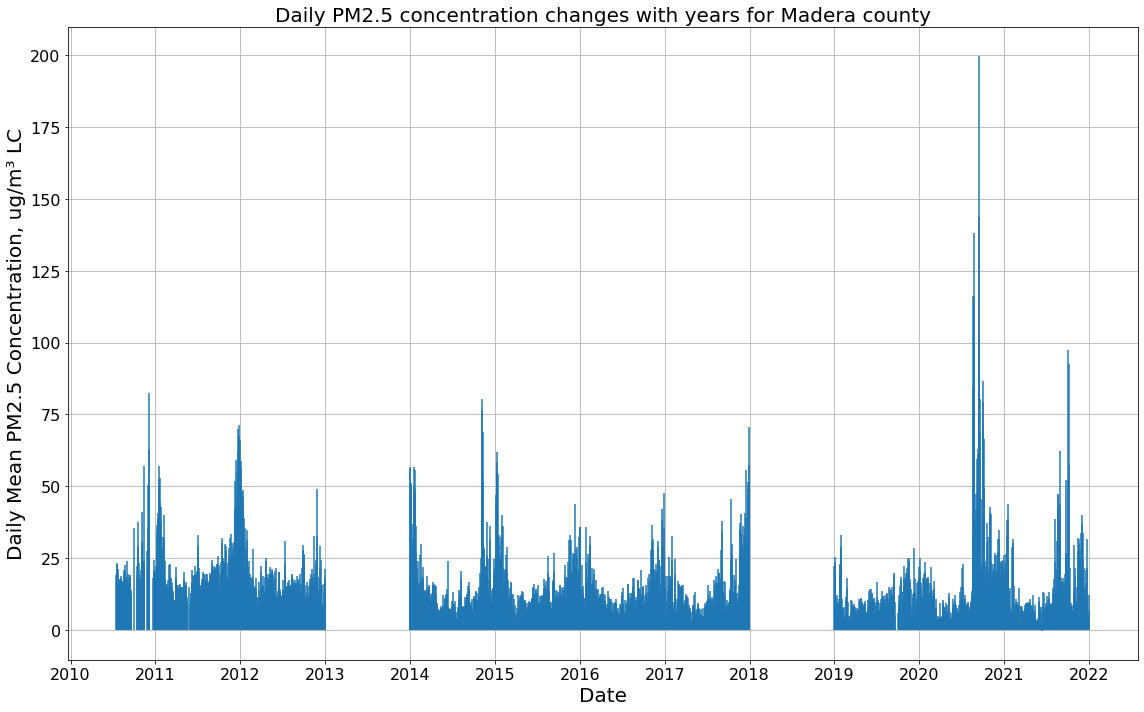

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


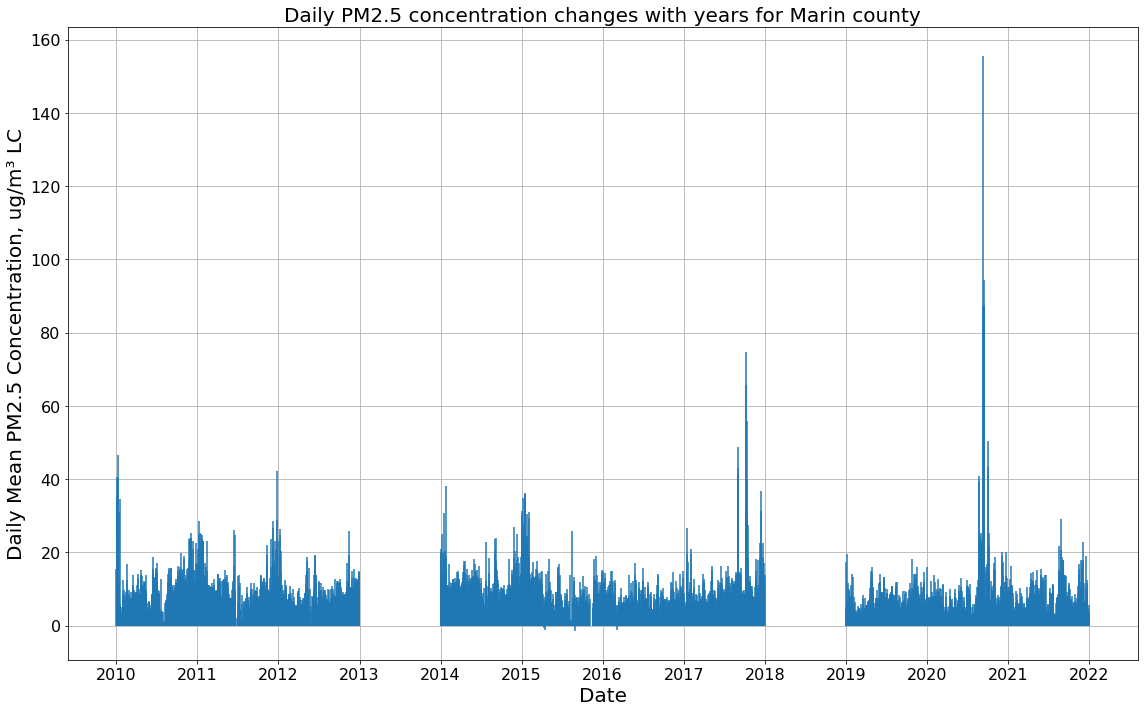

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


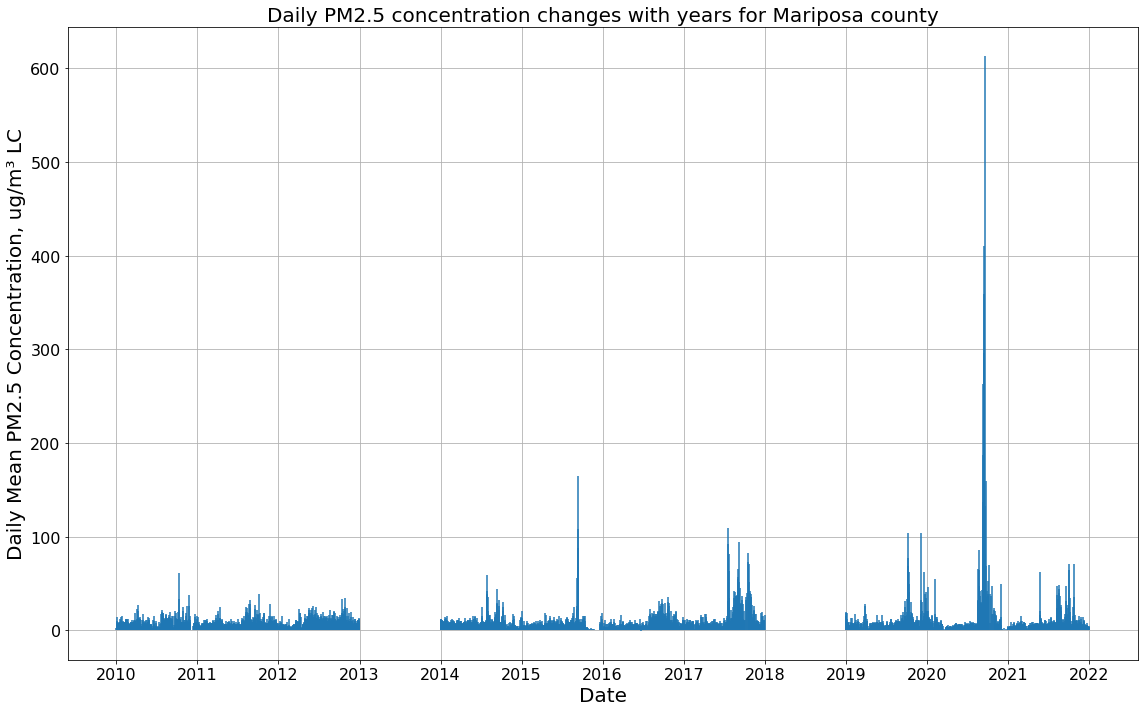

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


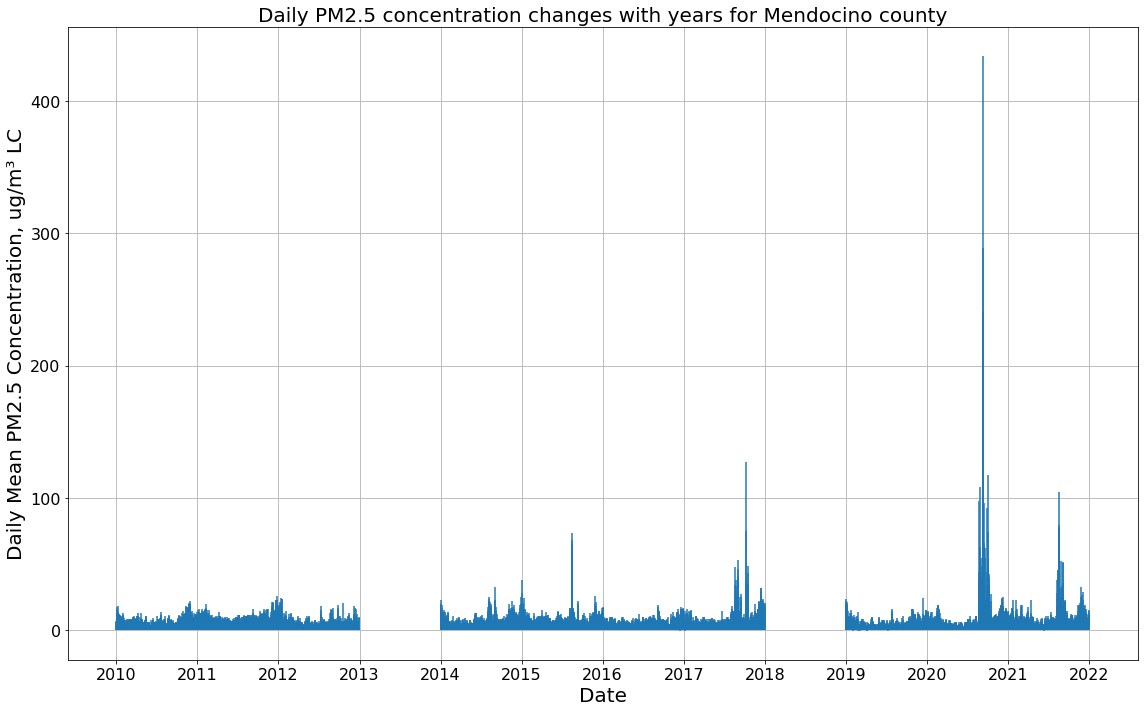

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


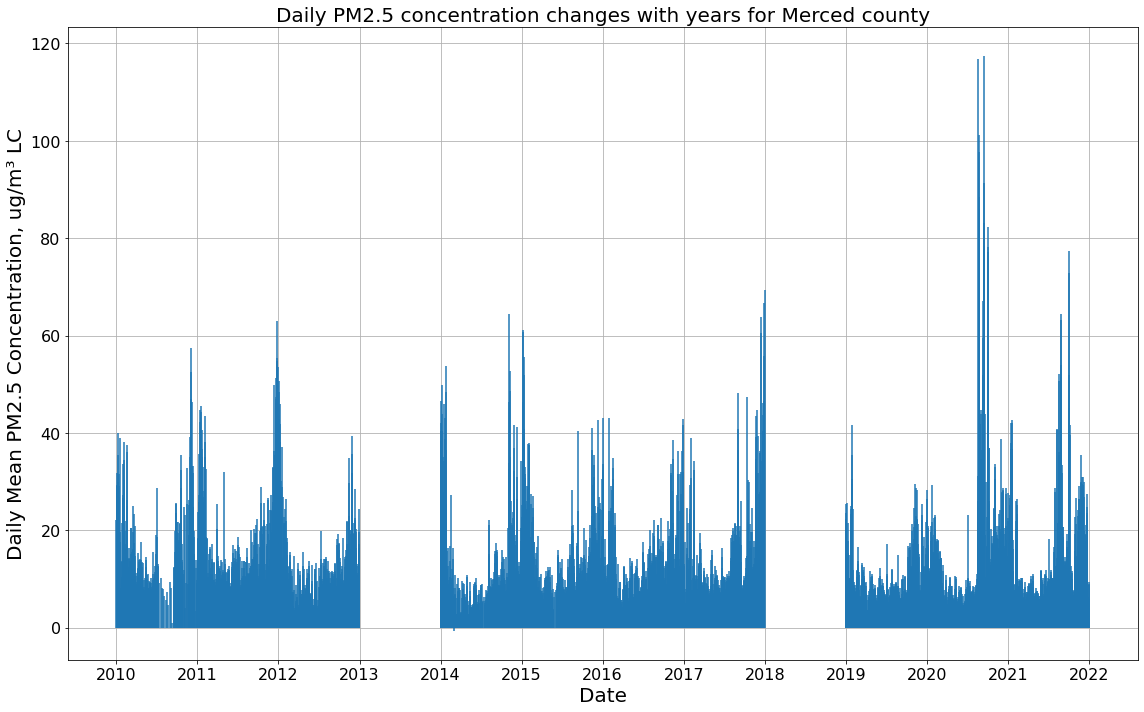

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


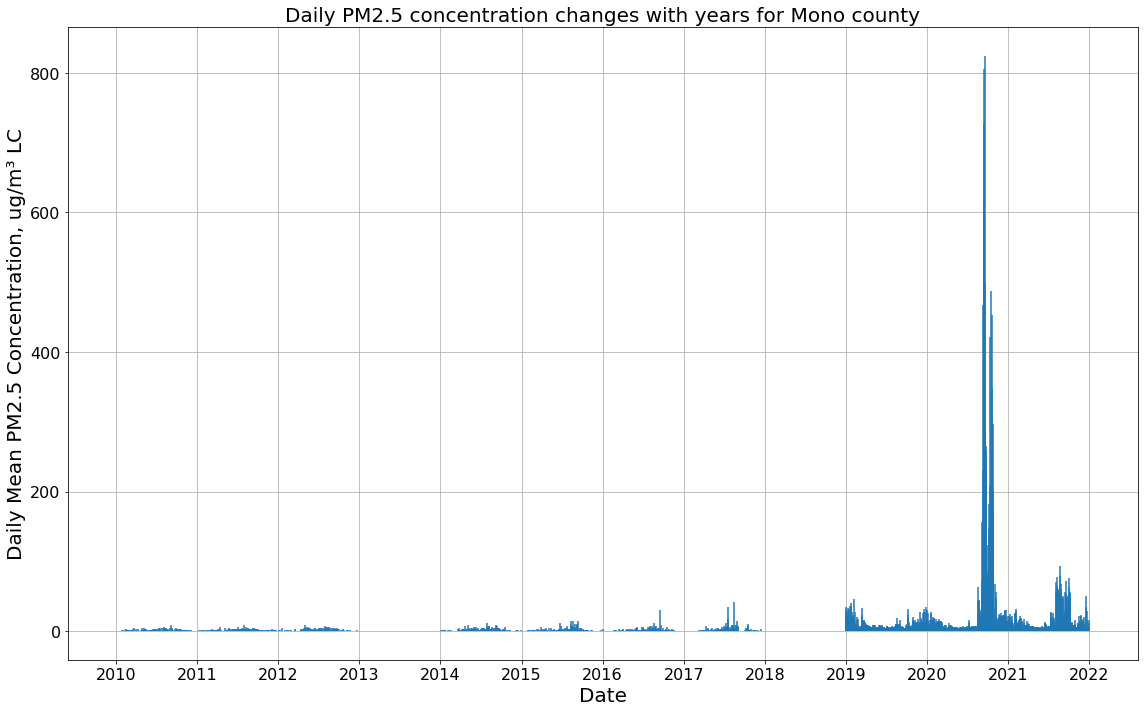

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


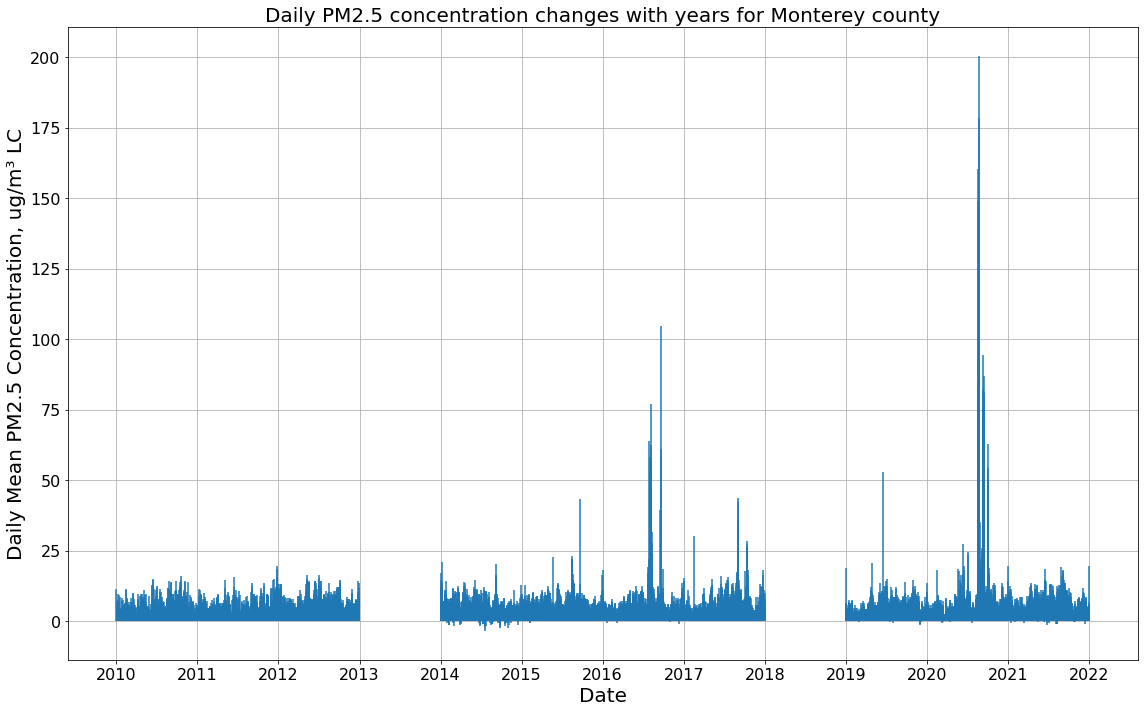

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


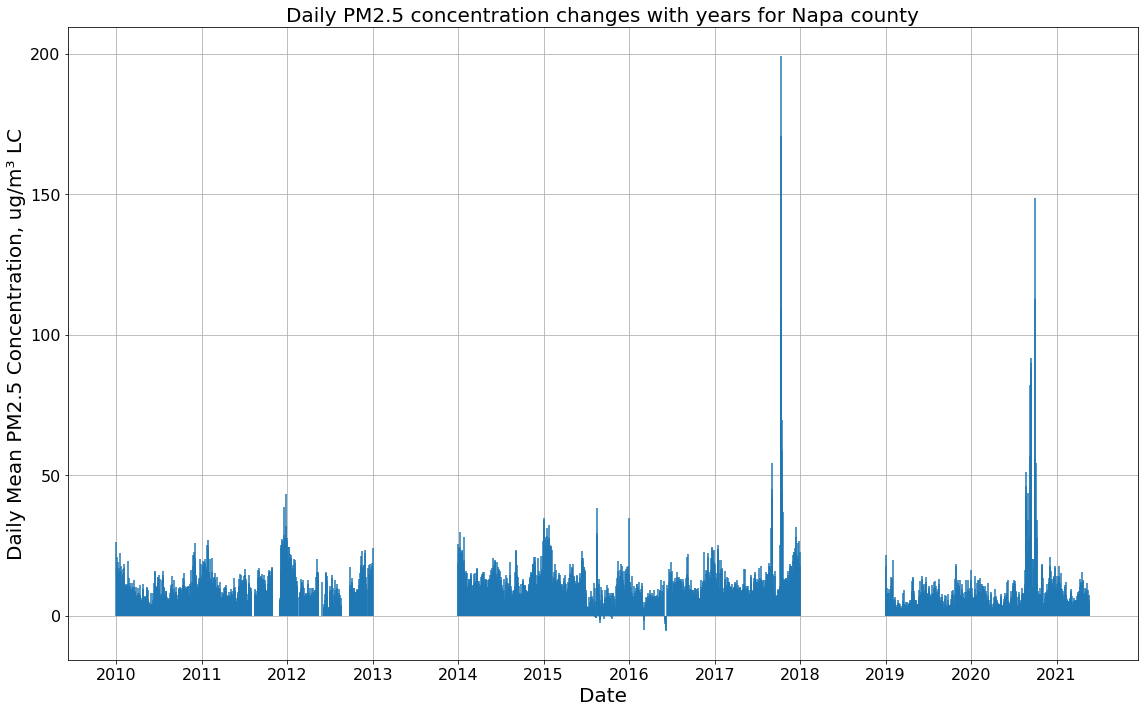

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


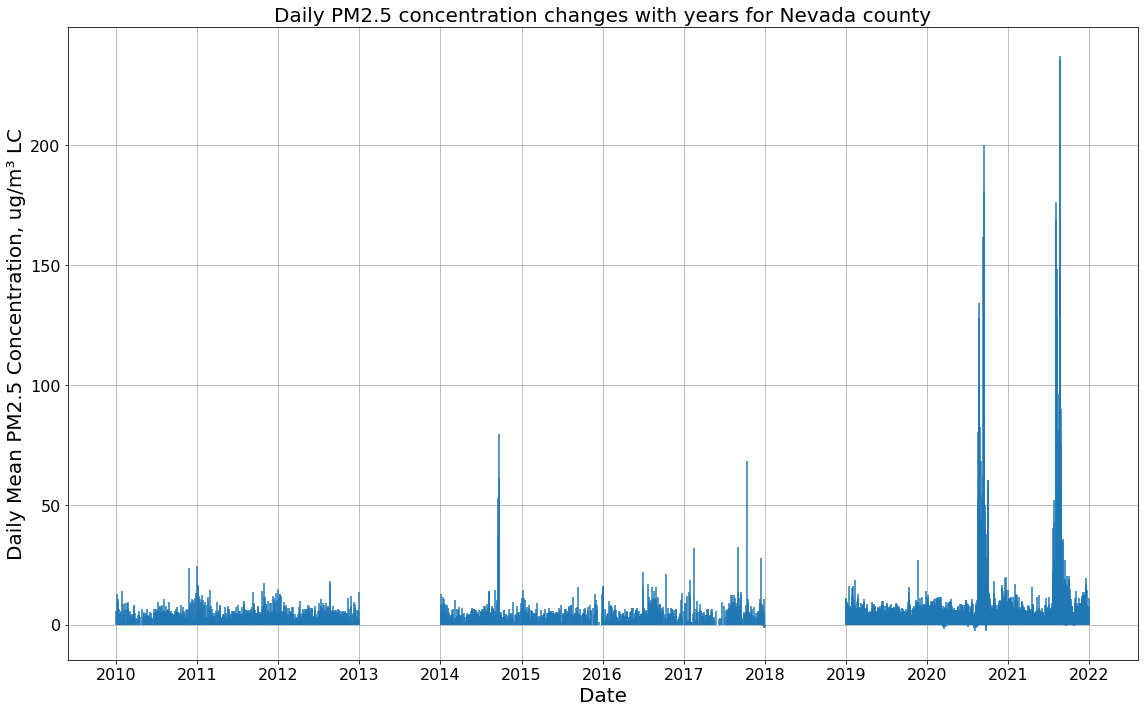

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


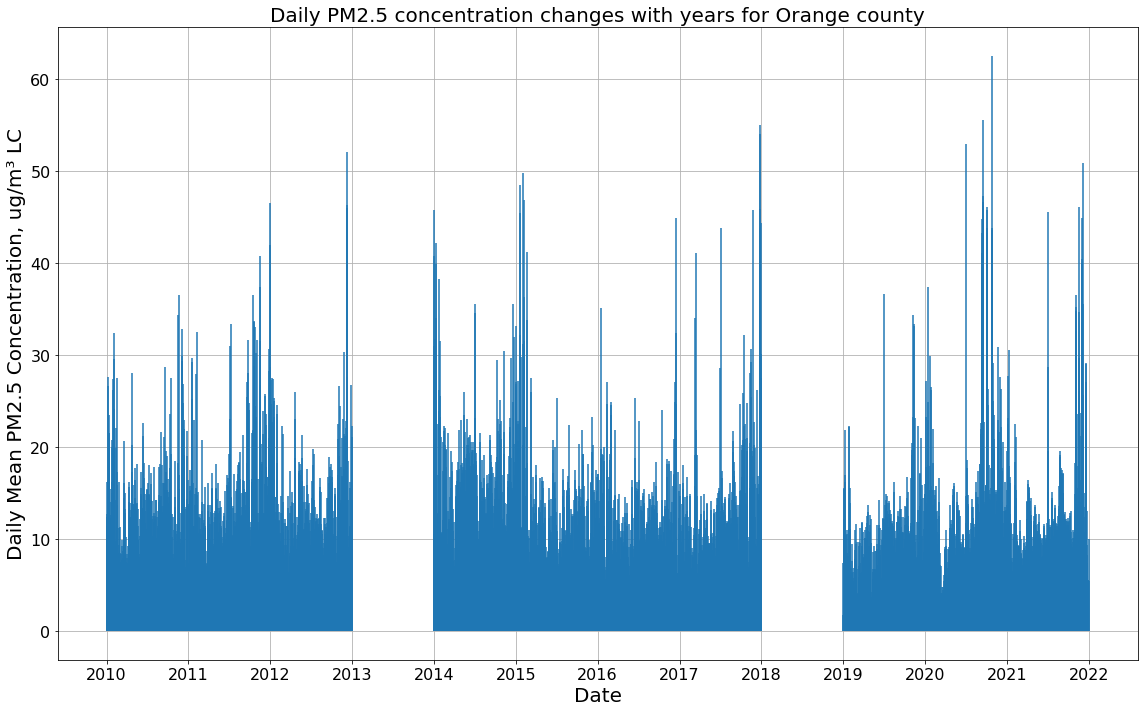

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


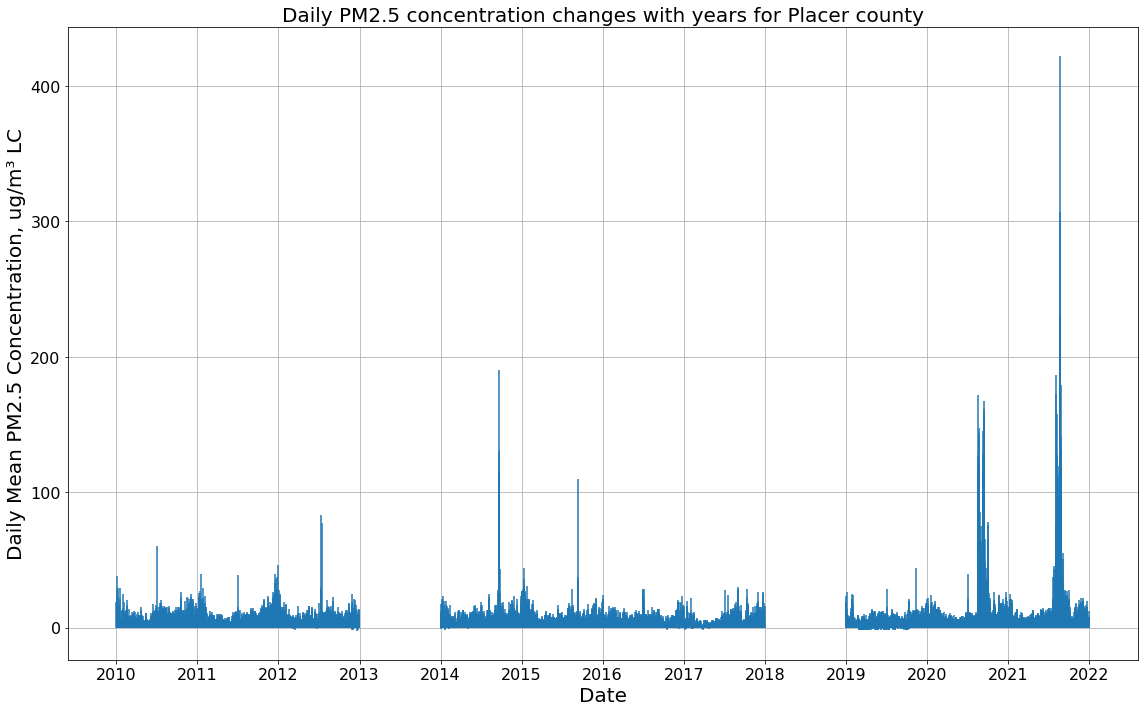

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


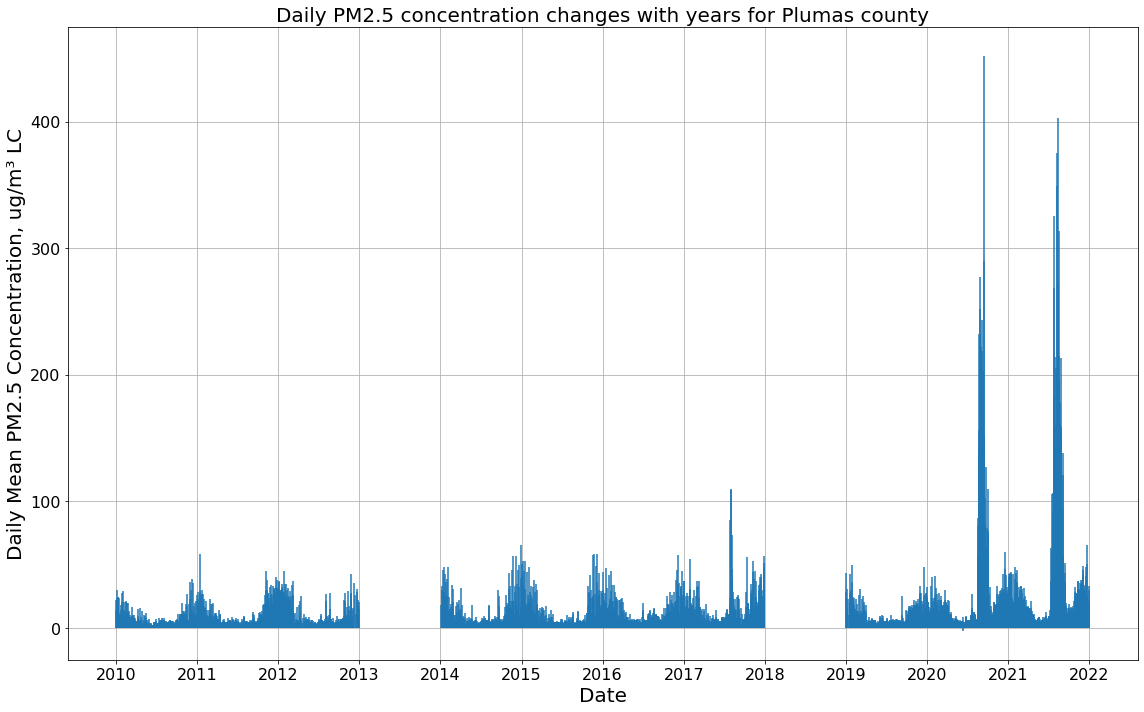

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


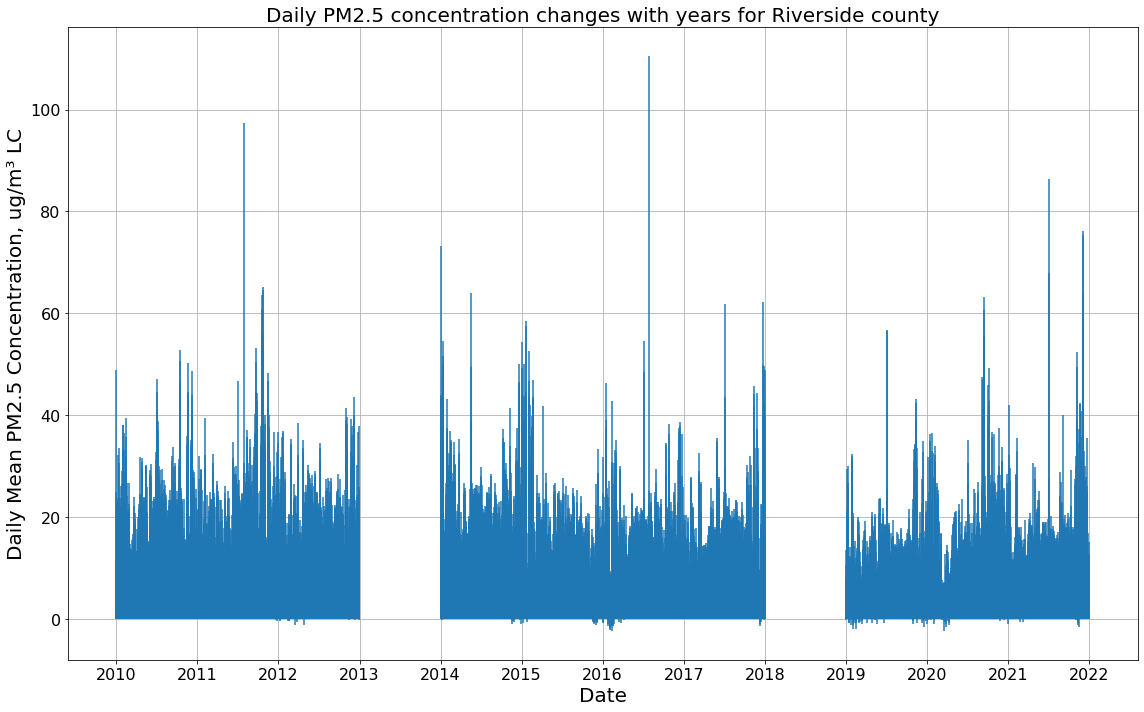

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


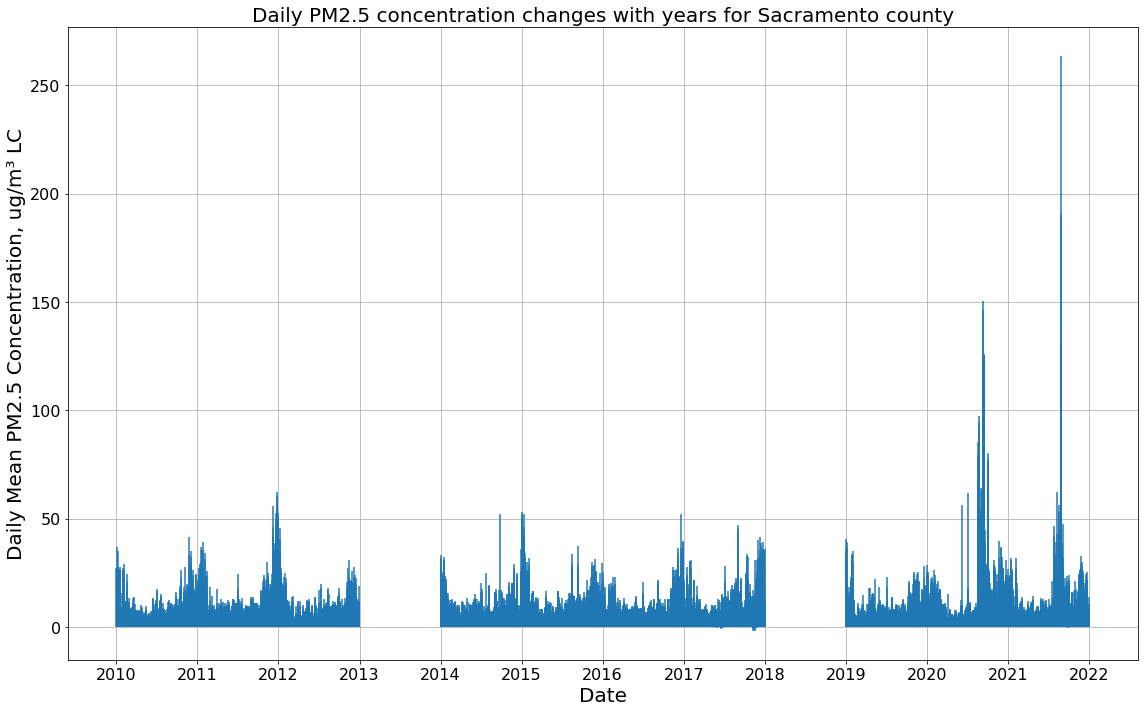

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


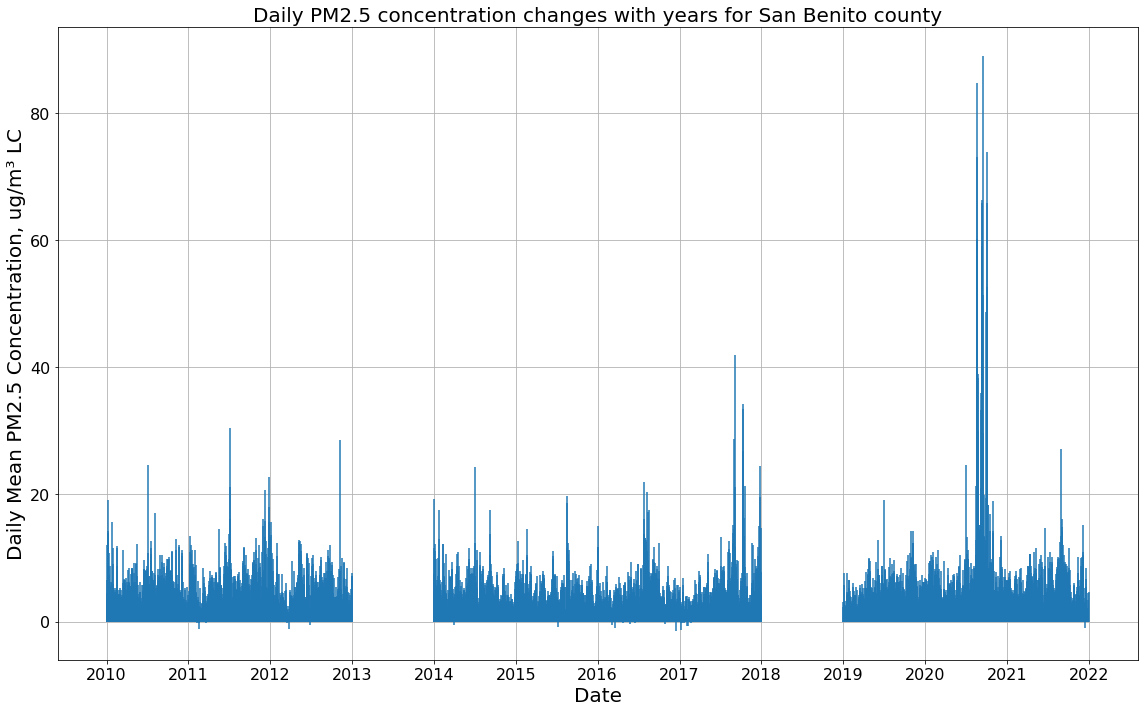

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


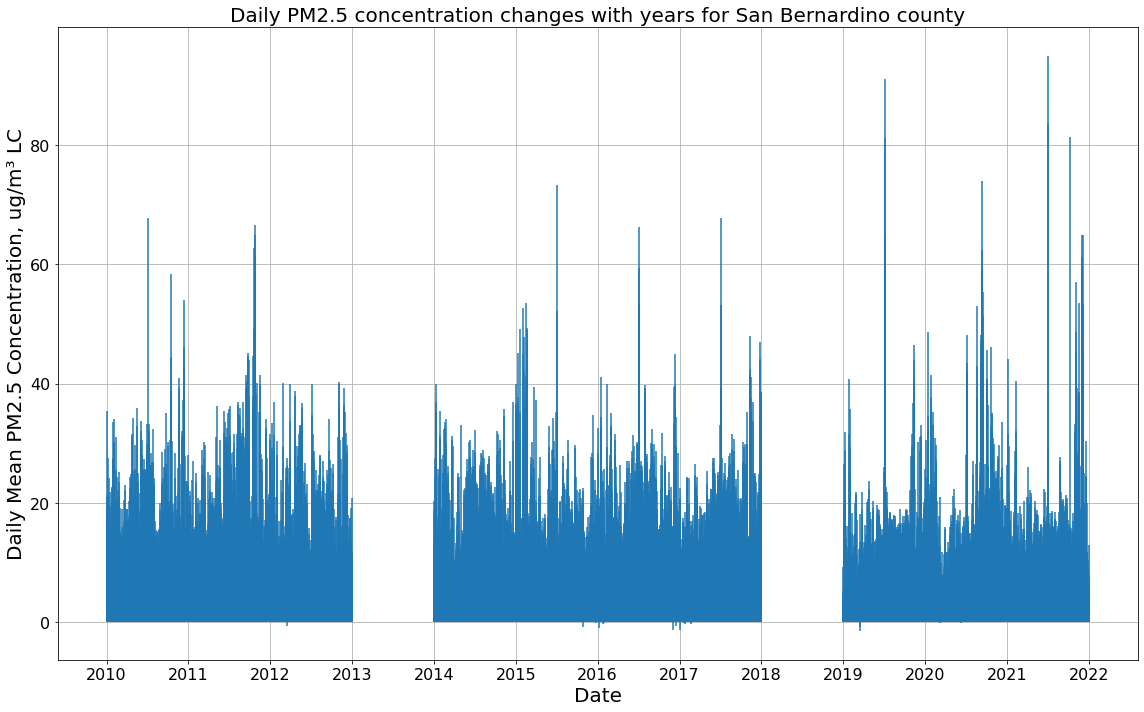

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


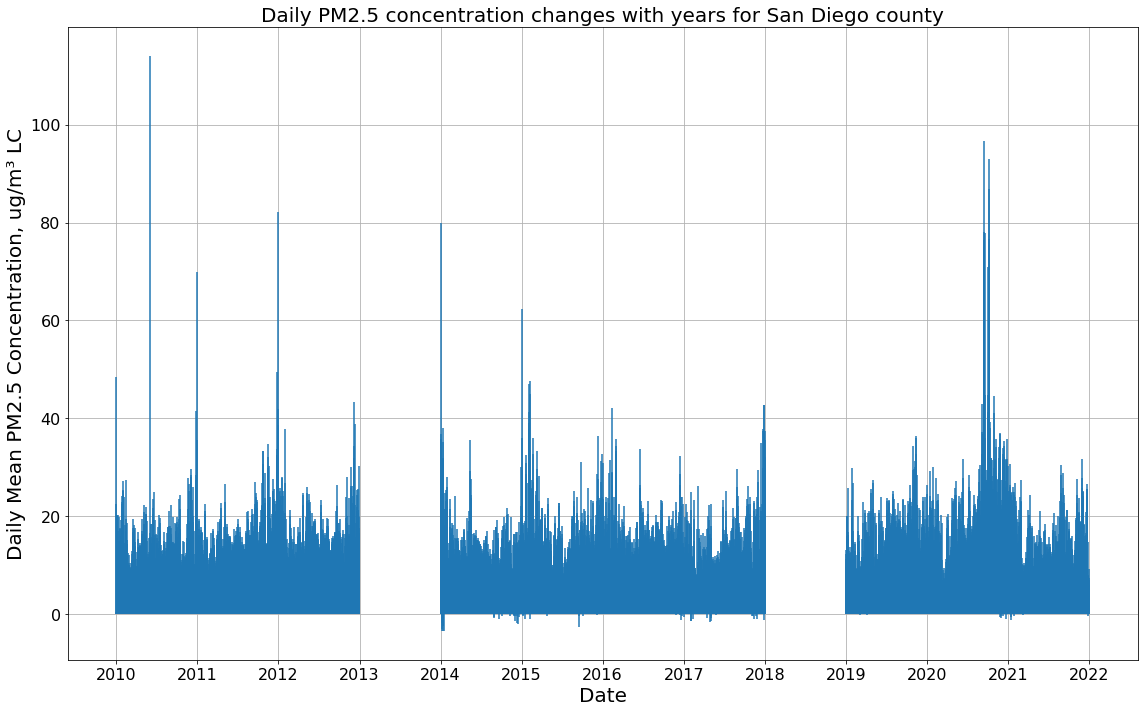

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


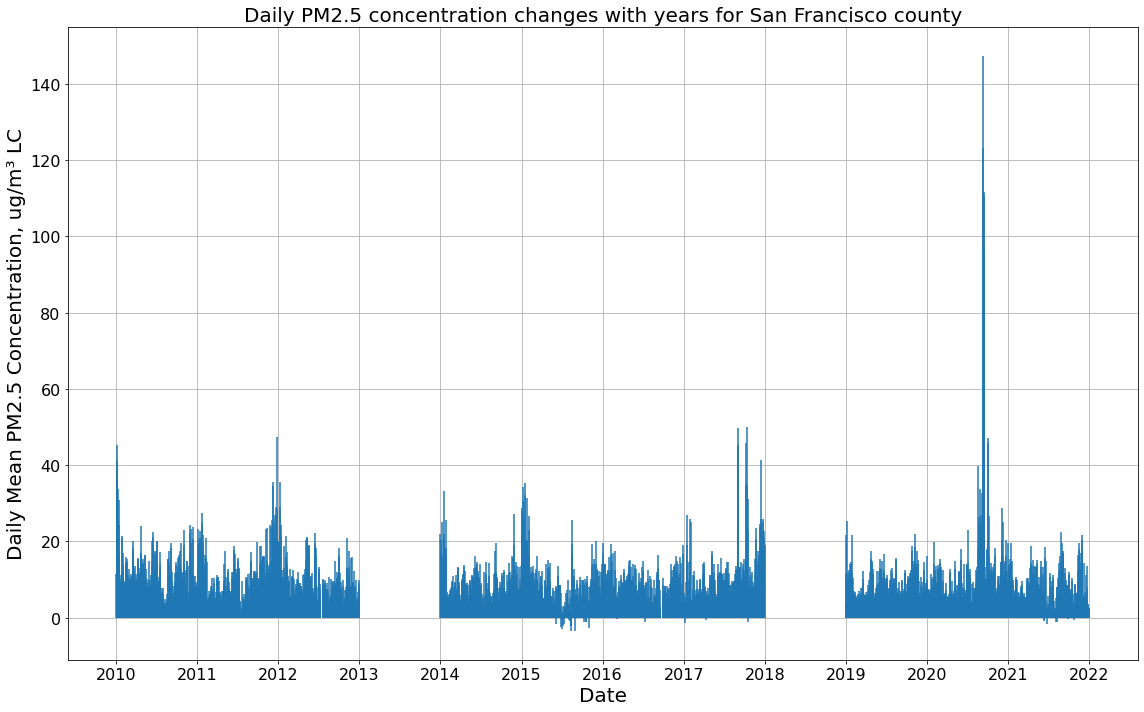

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


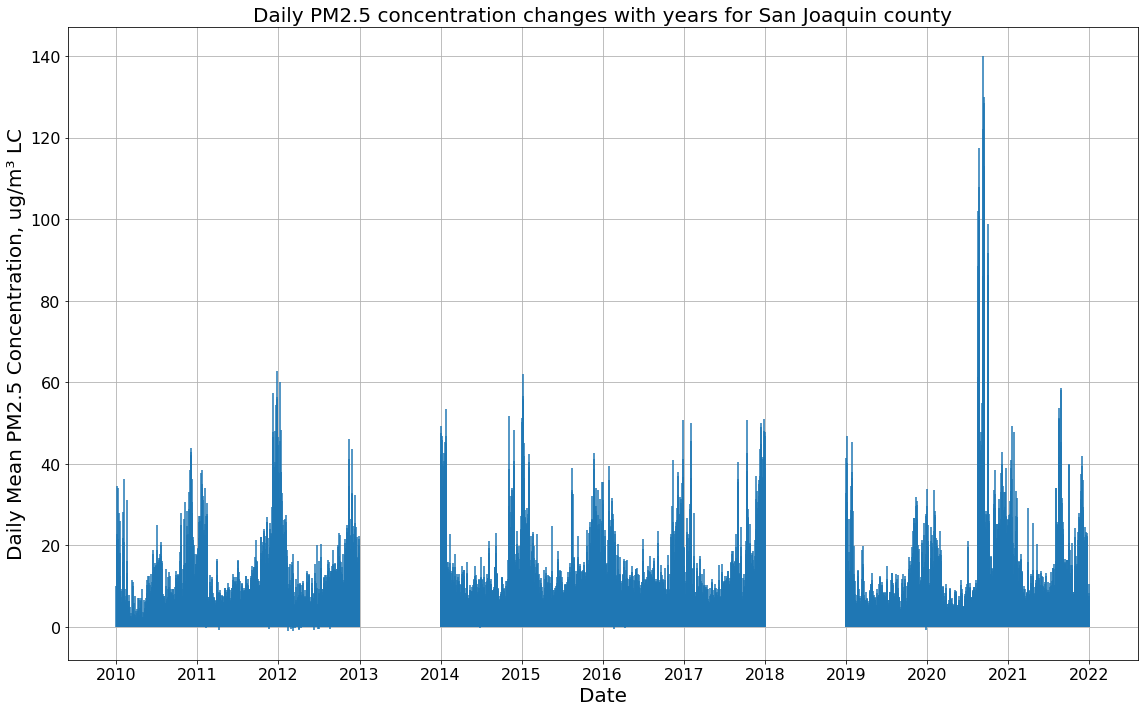

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


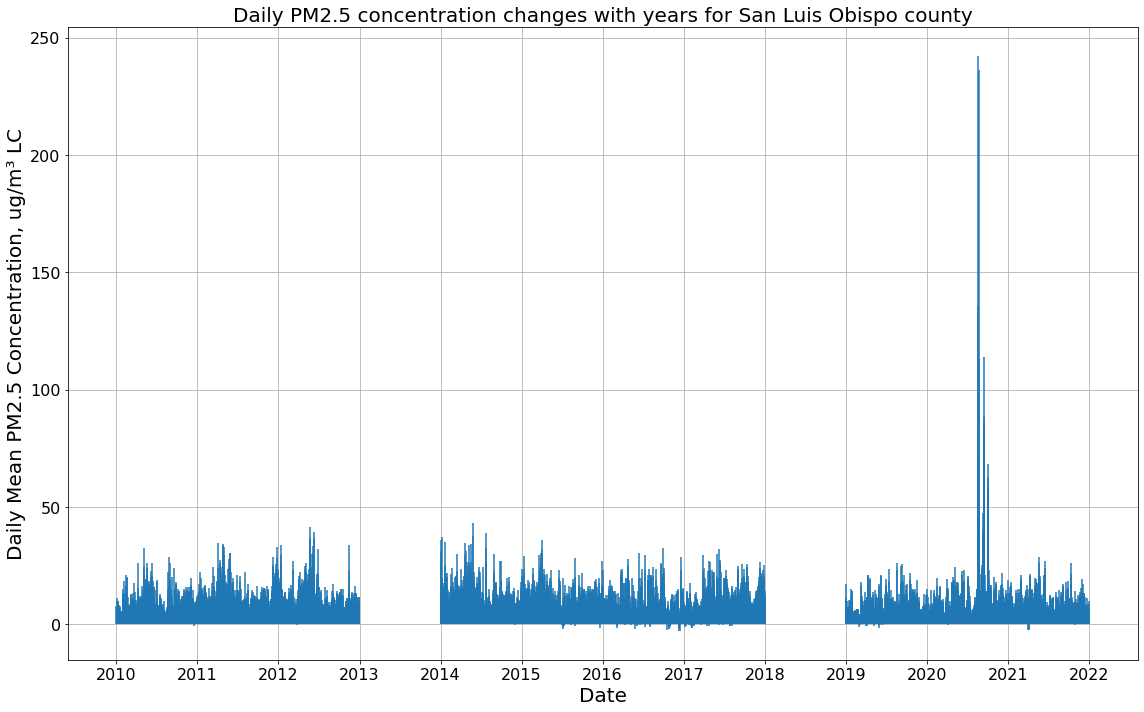

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


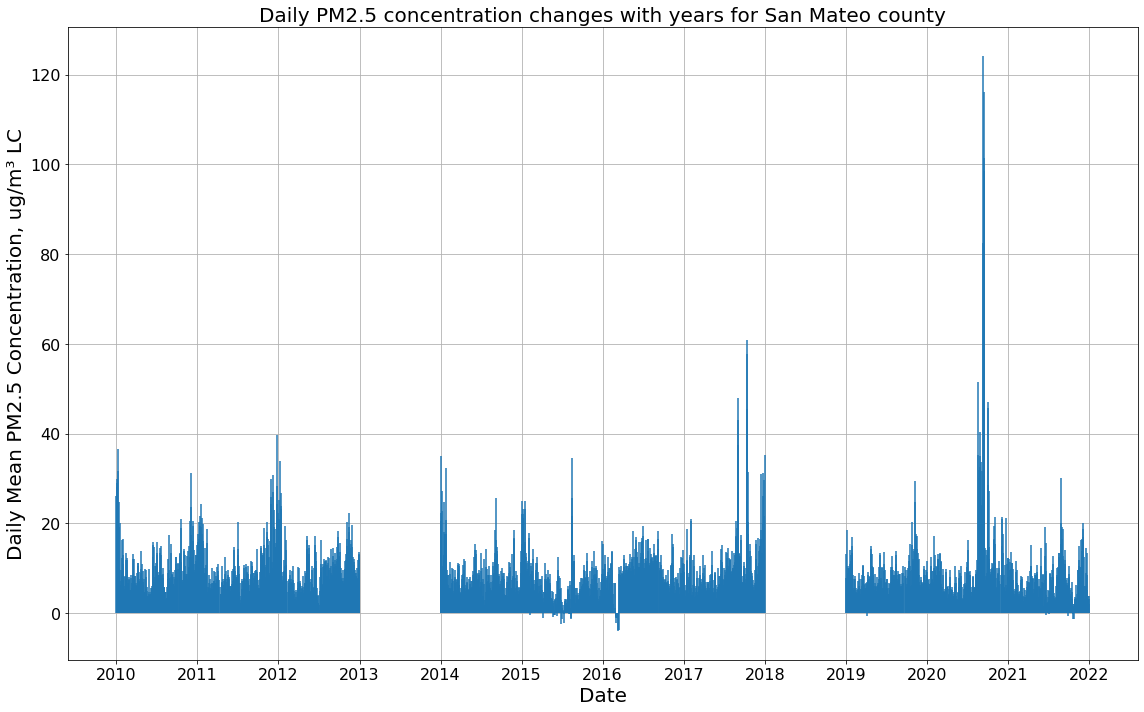

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


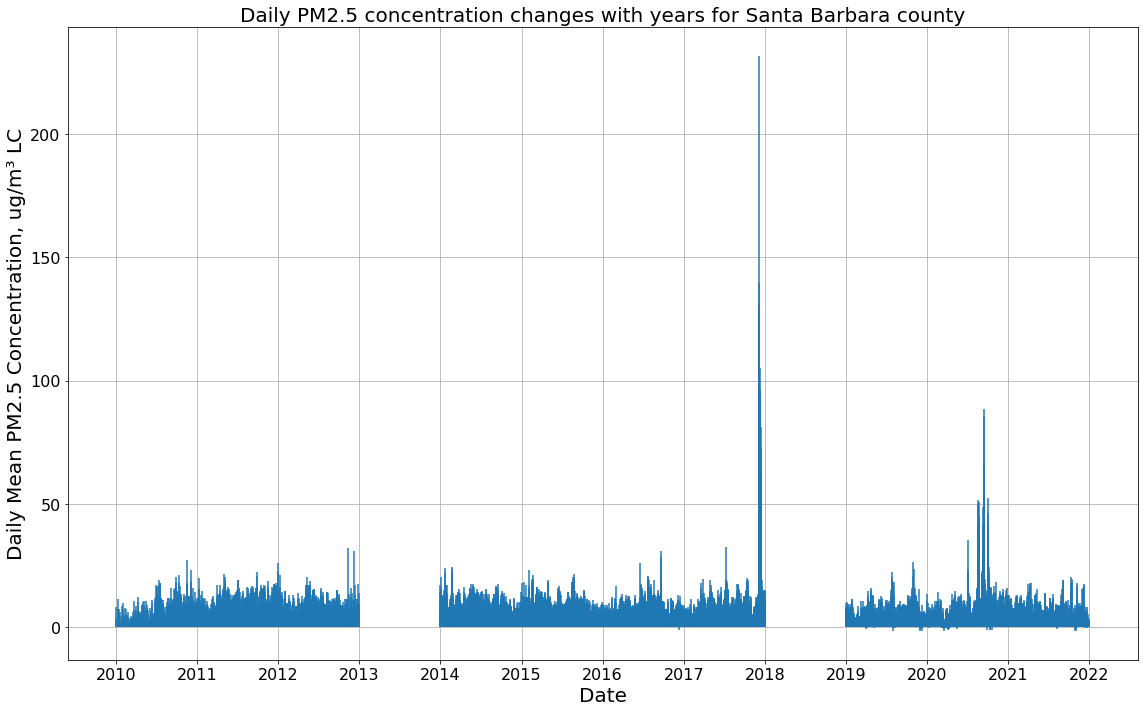

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


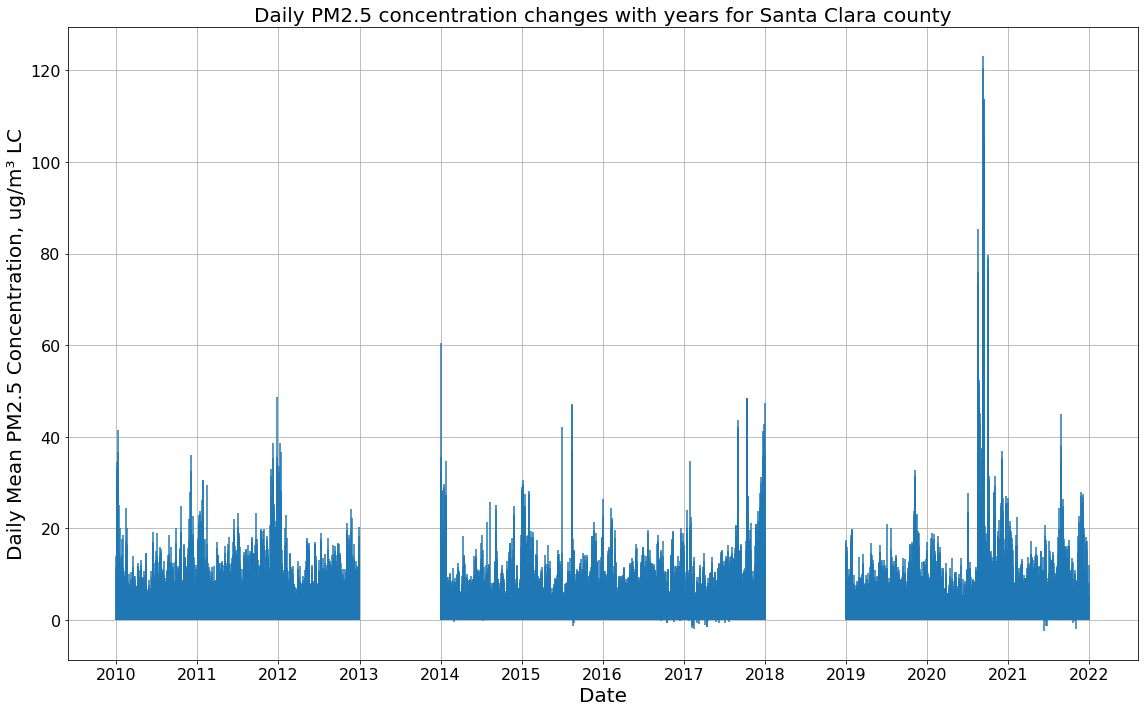

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


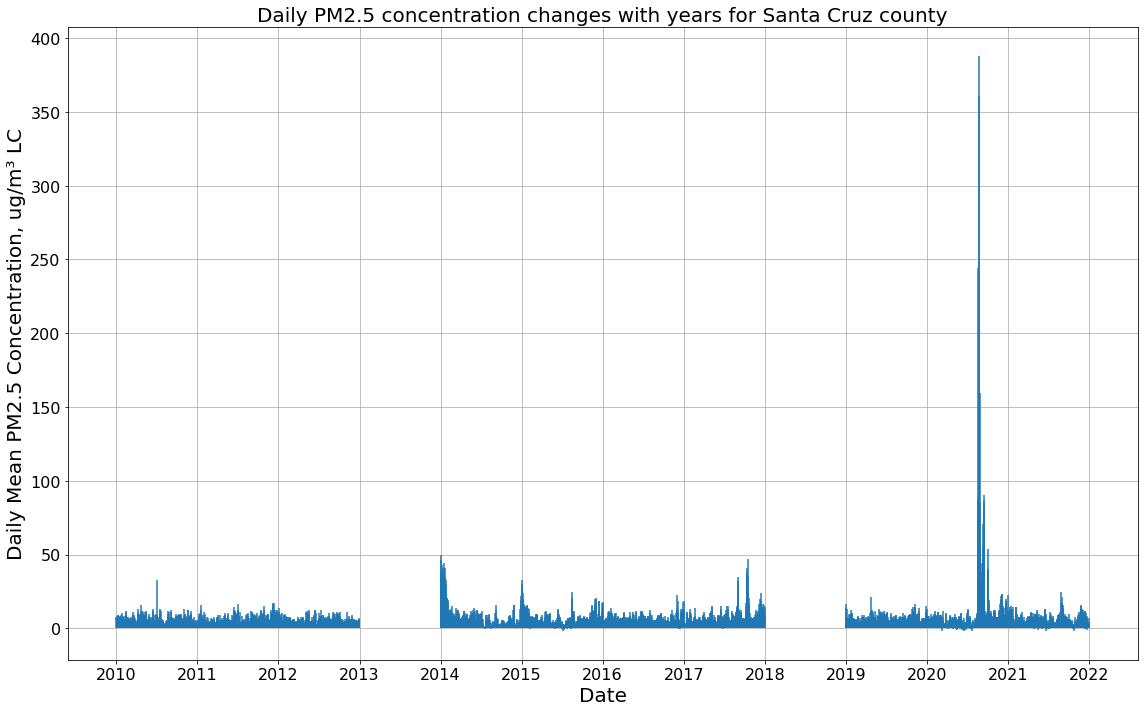

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


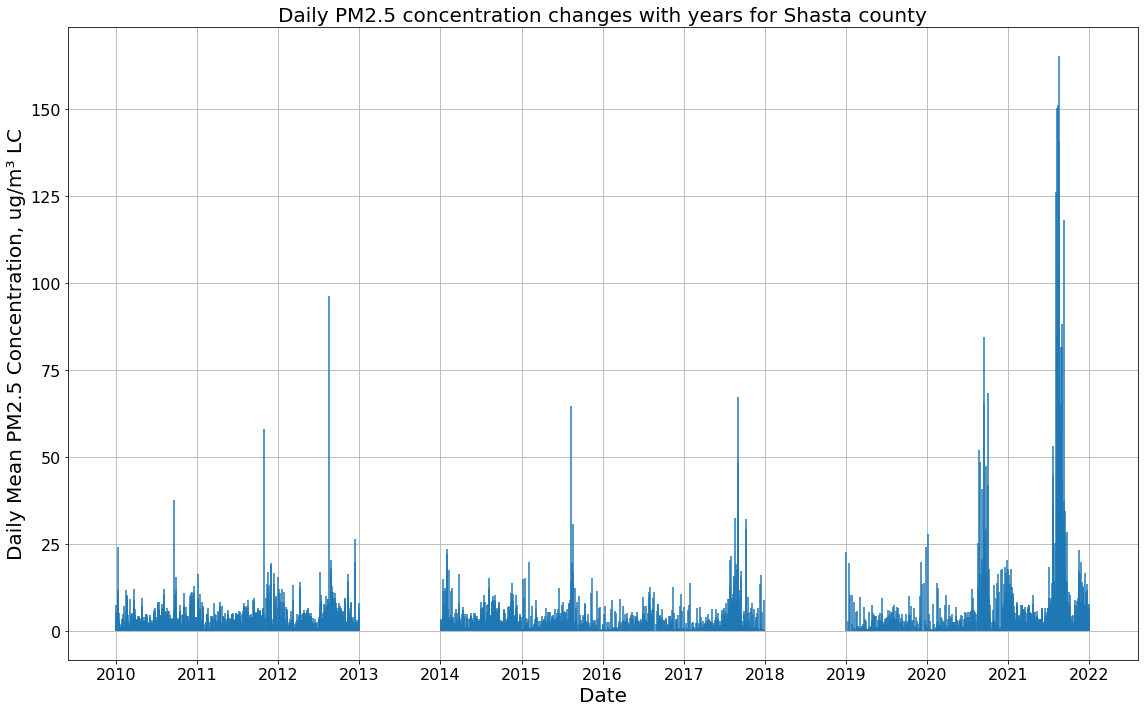

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


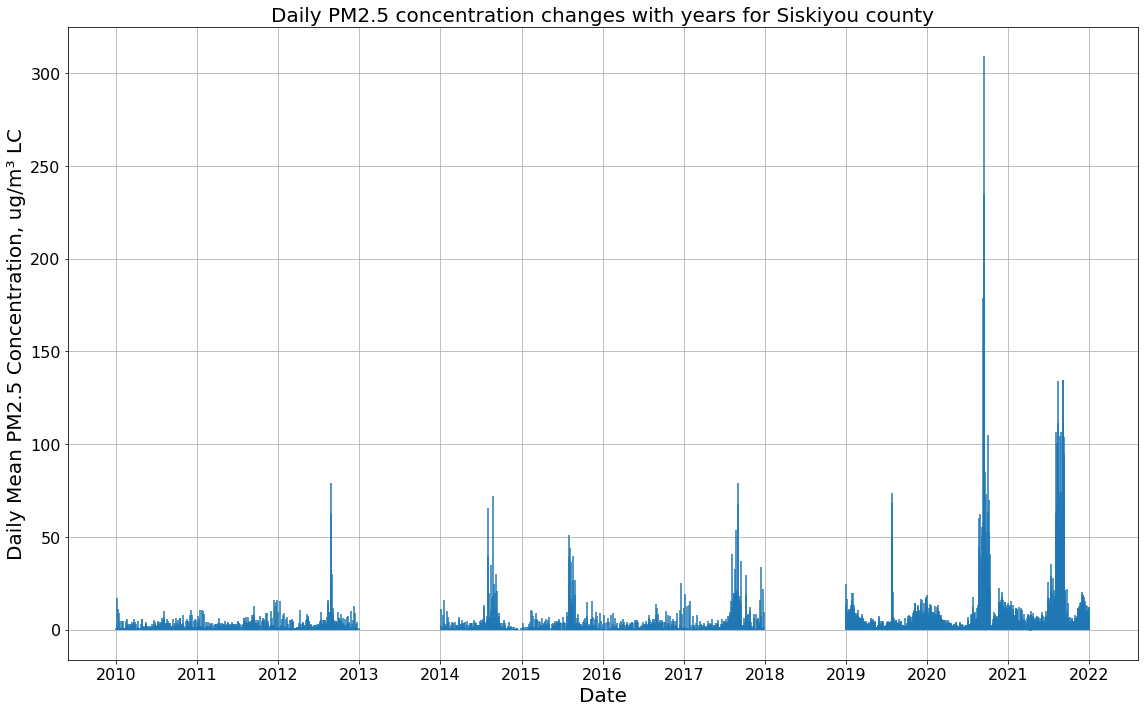

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


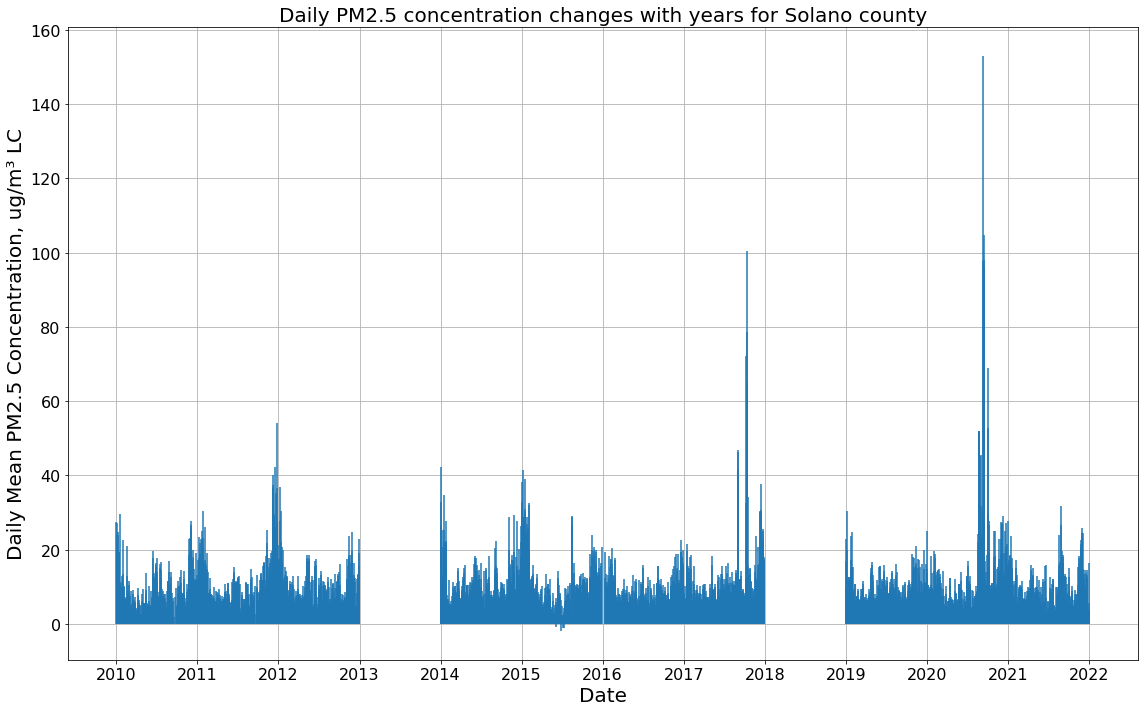

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


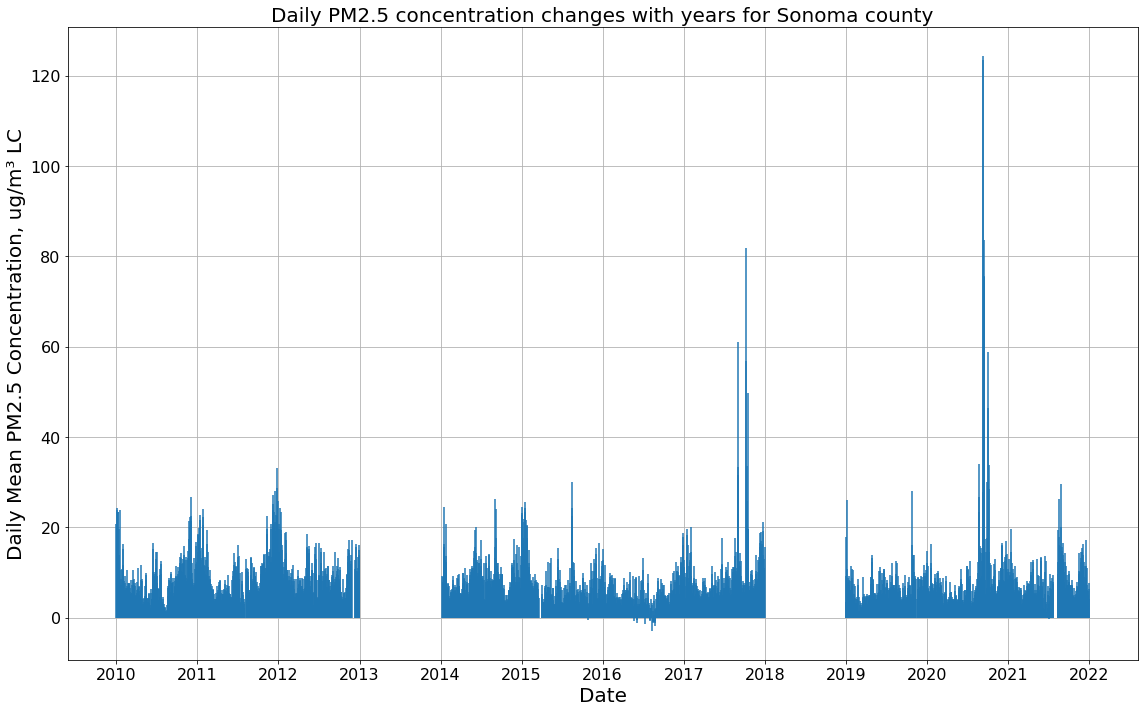

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-122-44f9db2641e8>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']


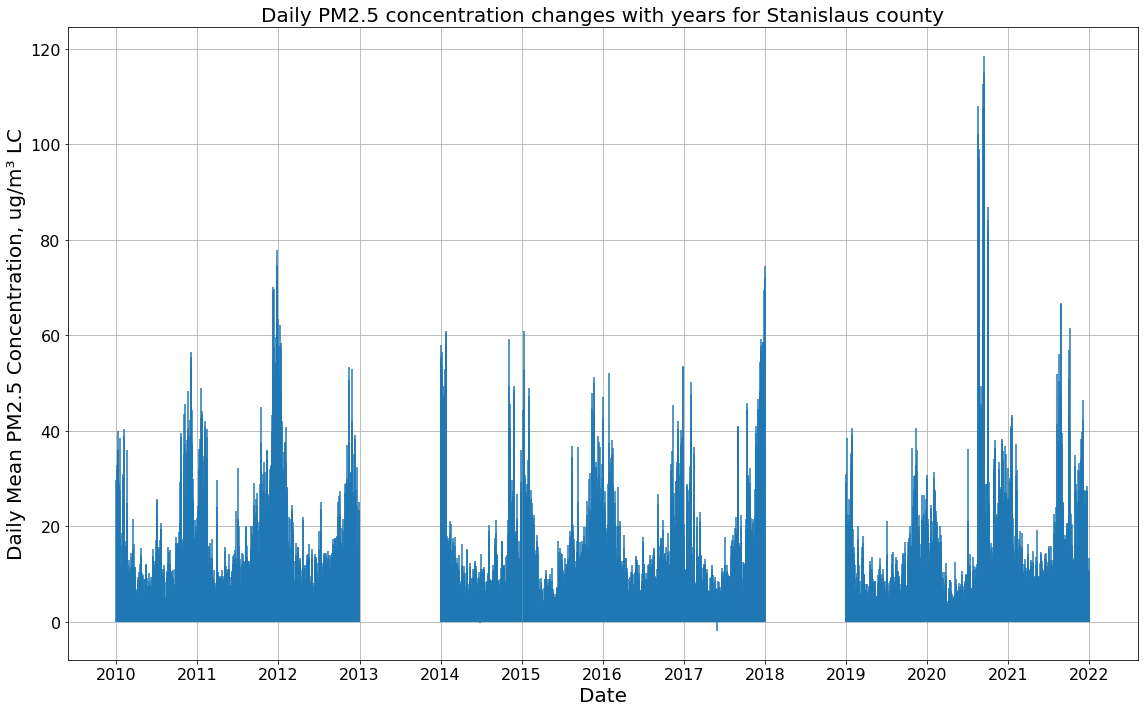

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


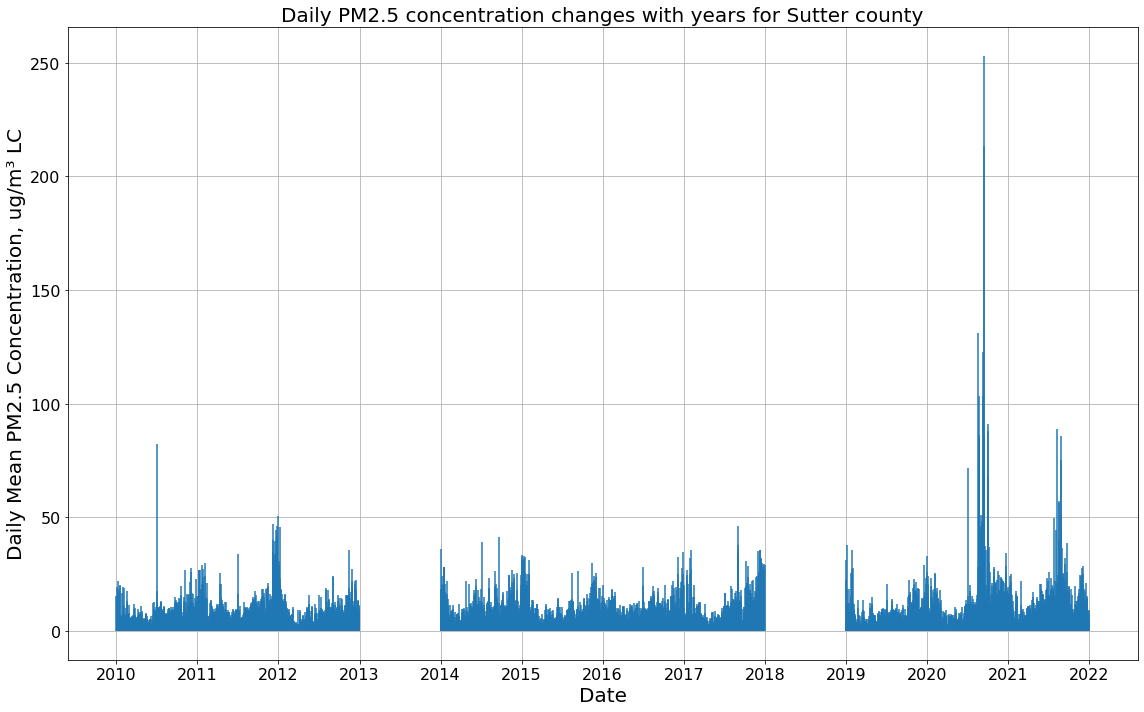

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


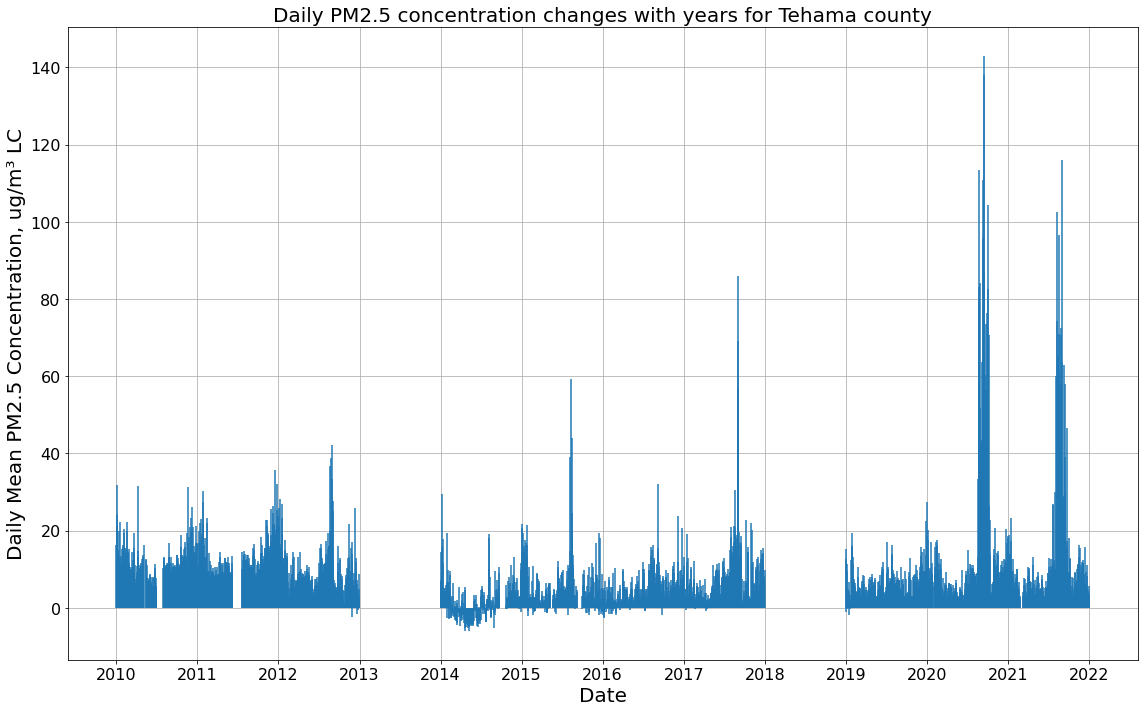

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


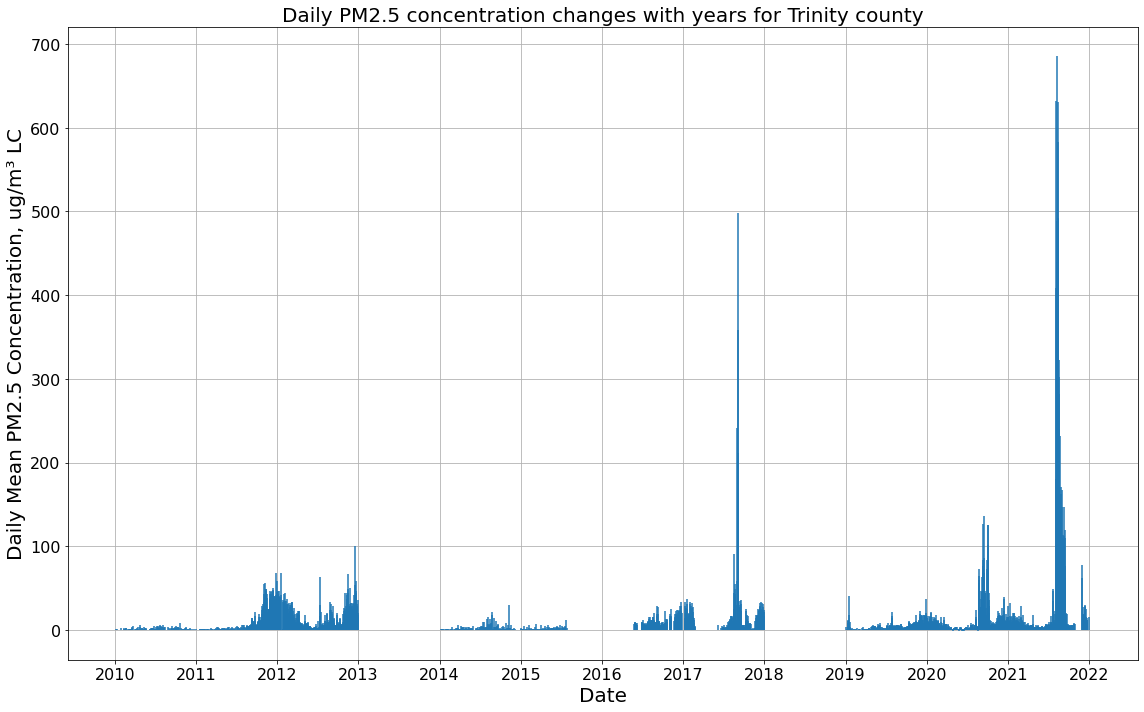

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


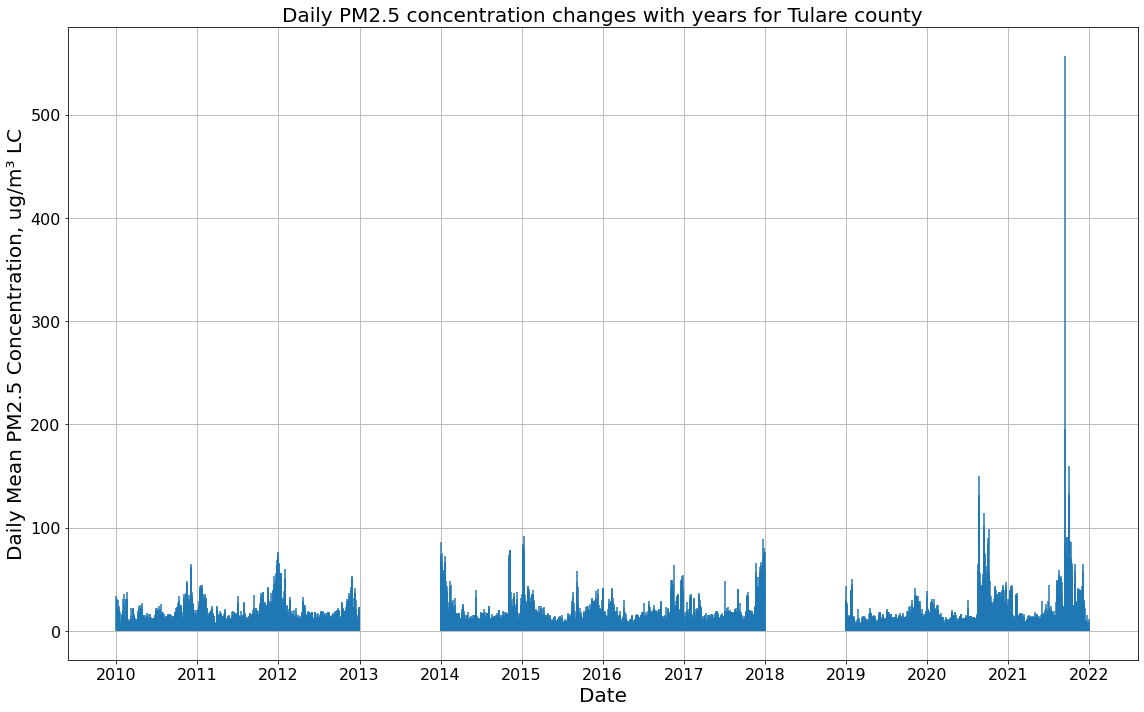

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


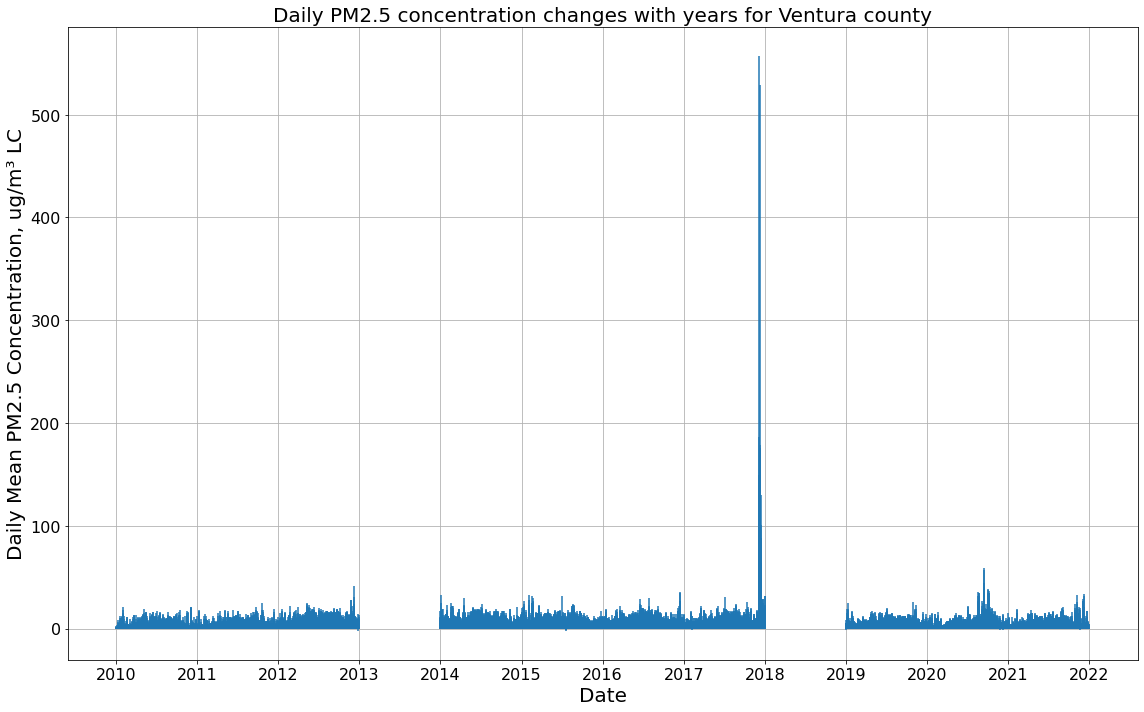

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


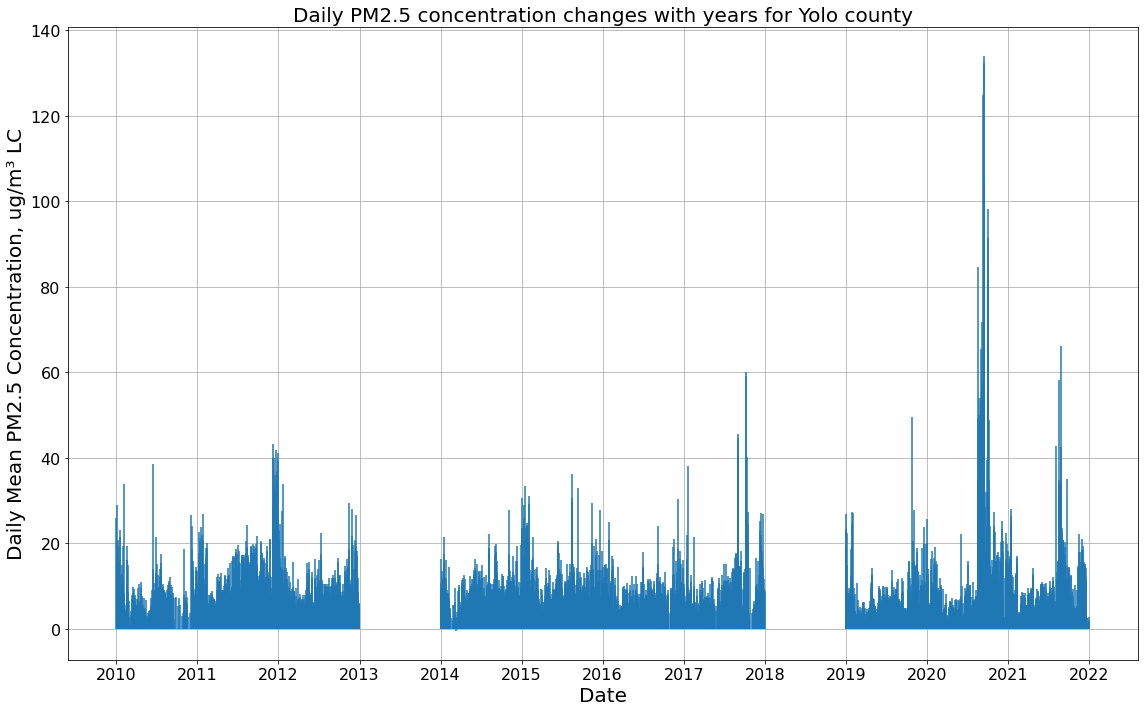

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


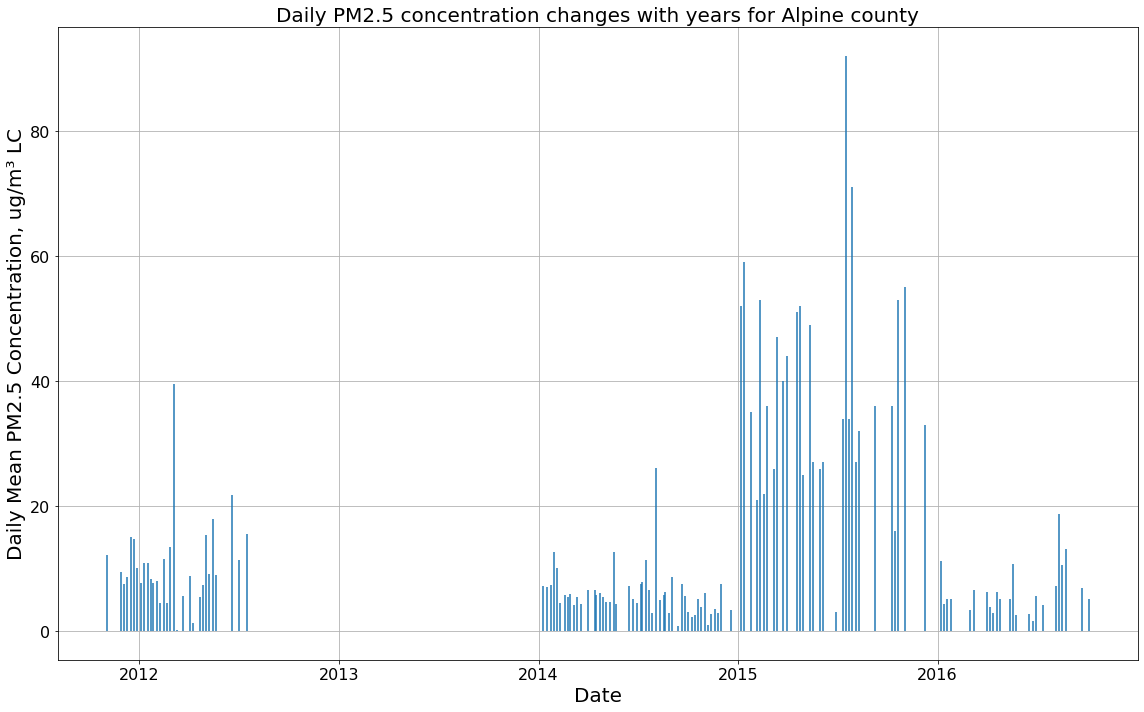

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


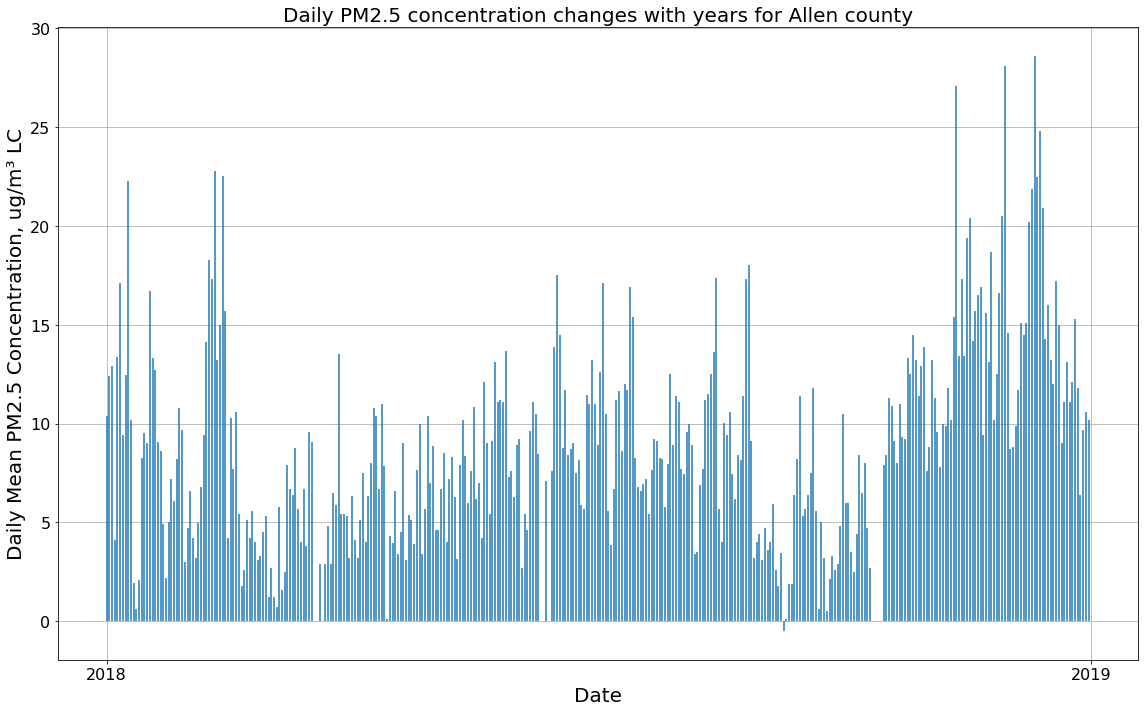

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


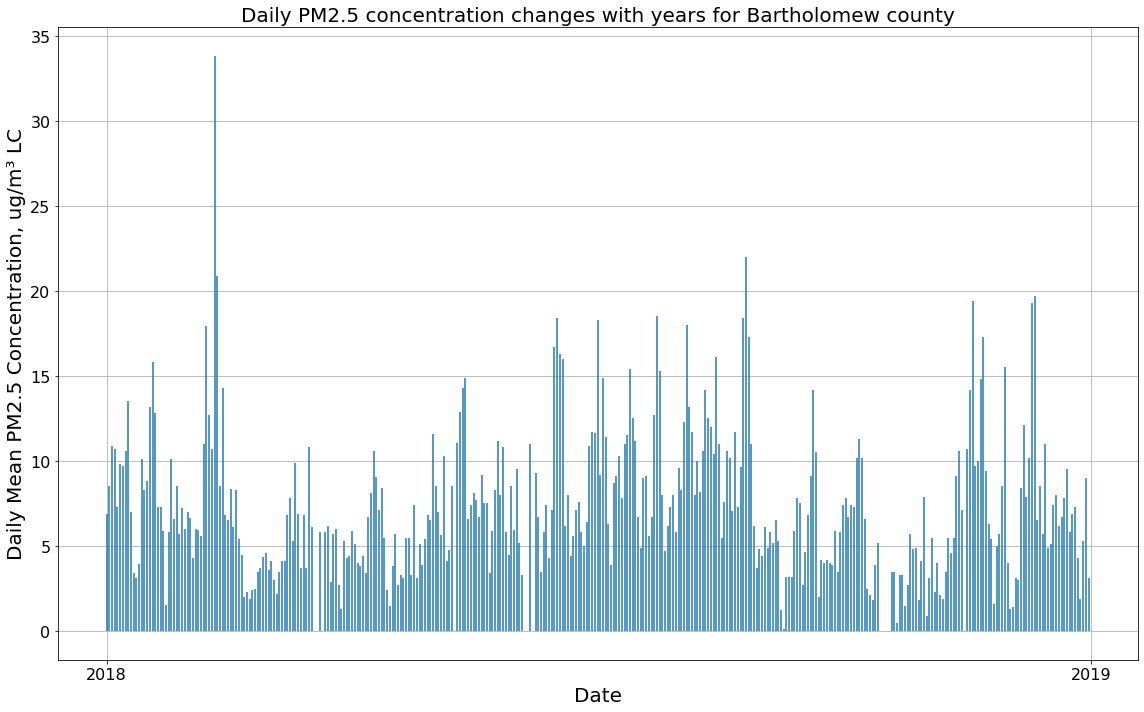

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


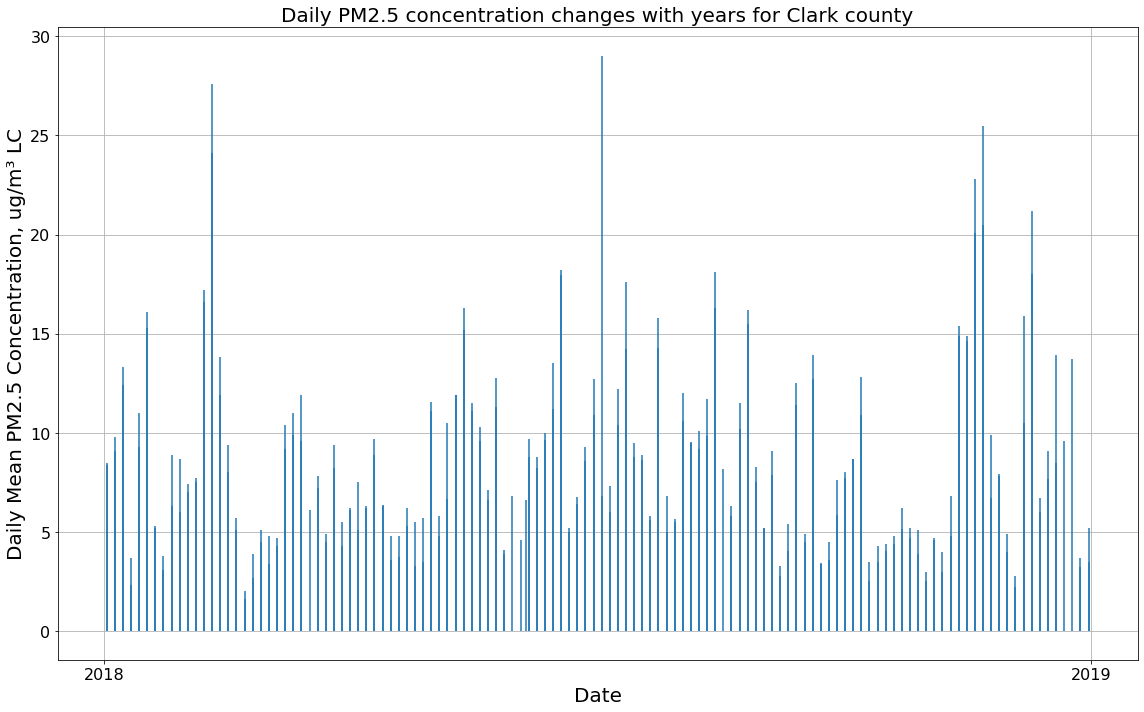

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


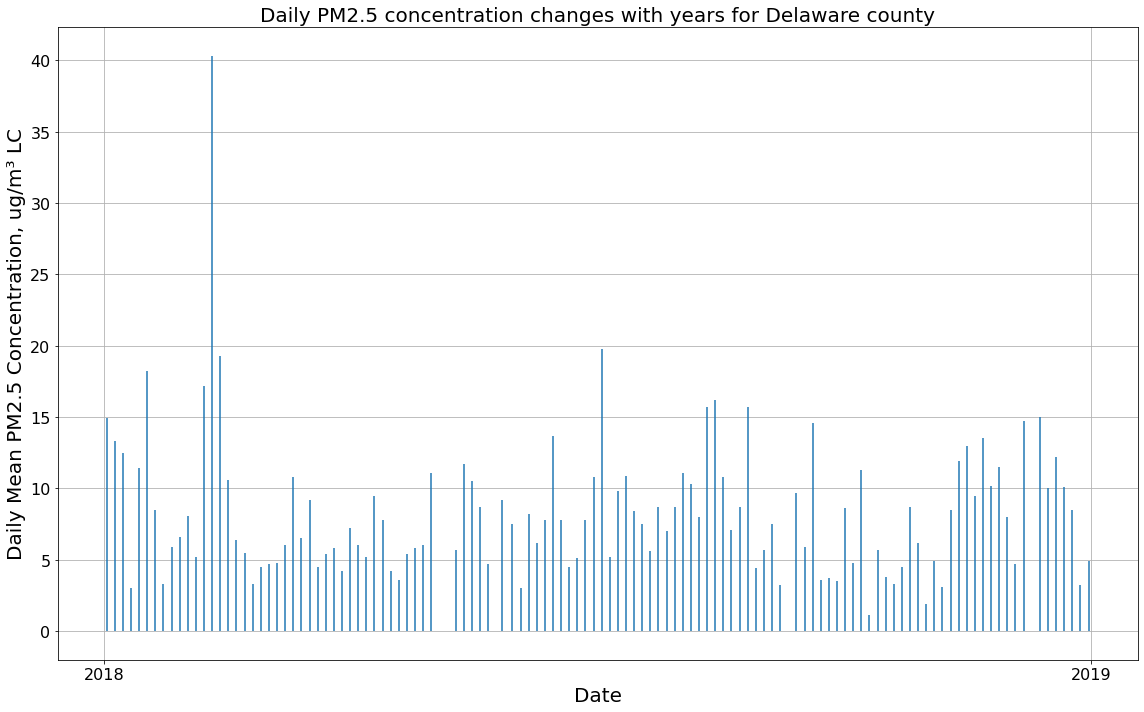

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


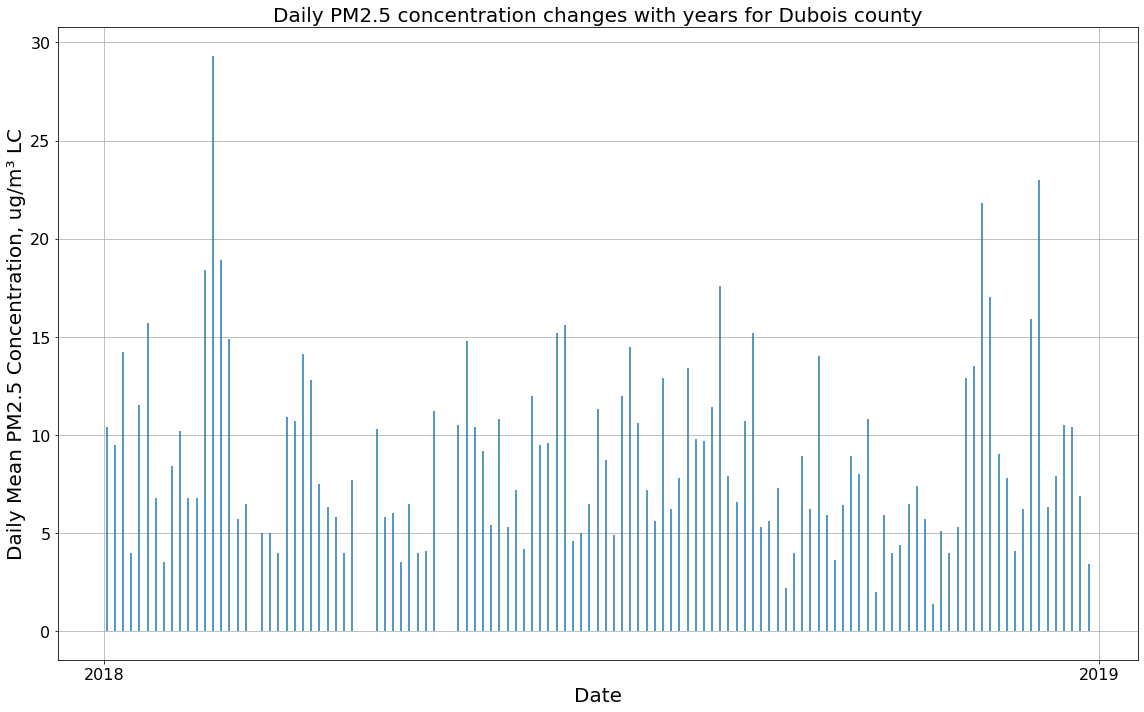

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


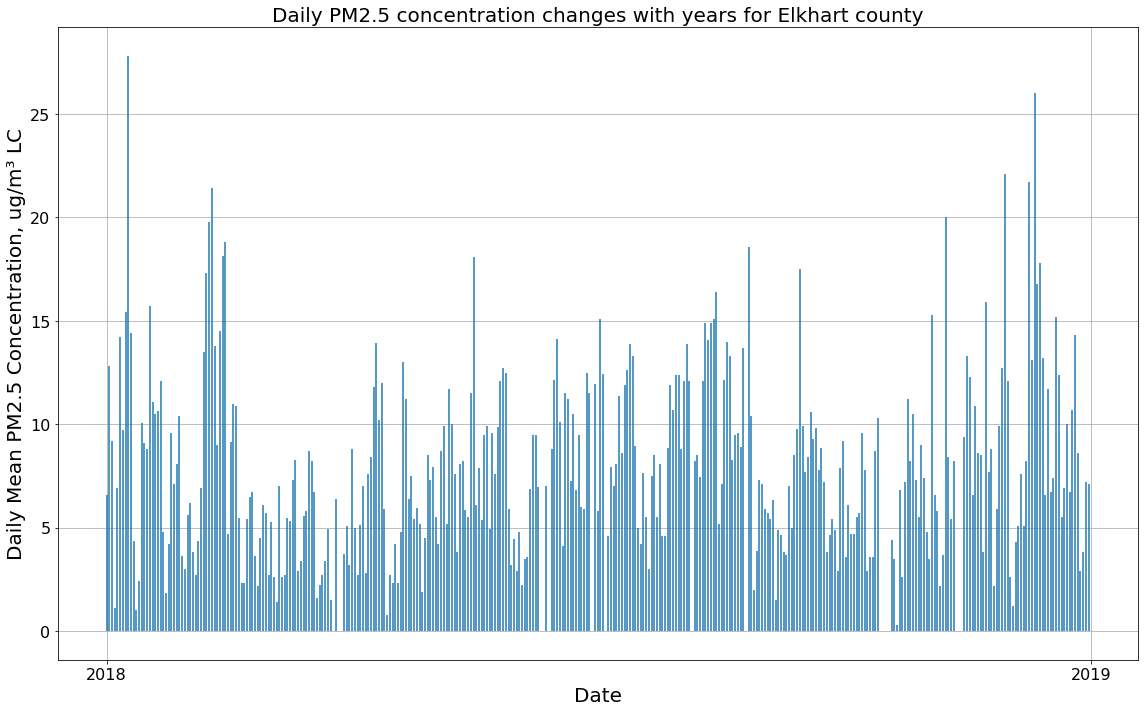

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


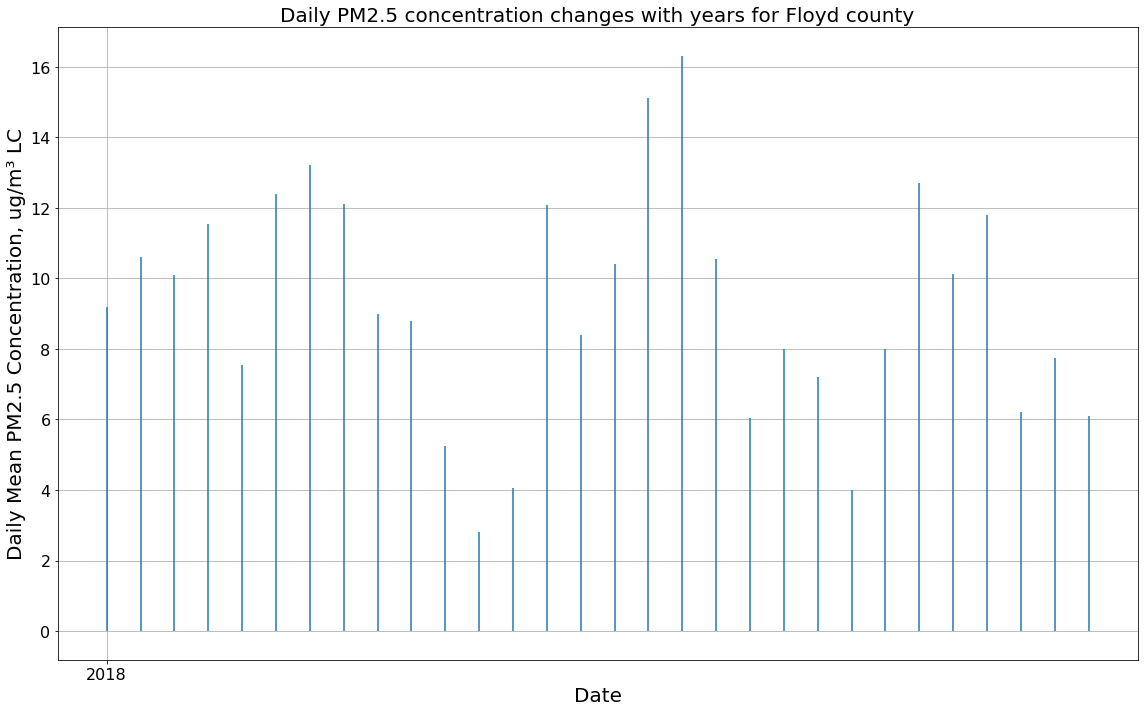

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


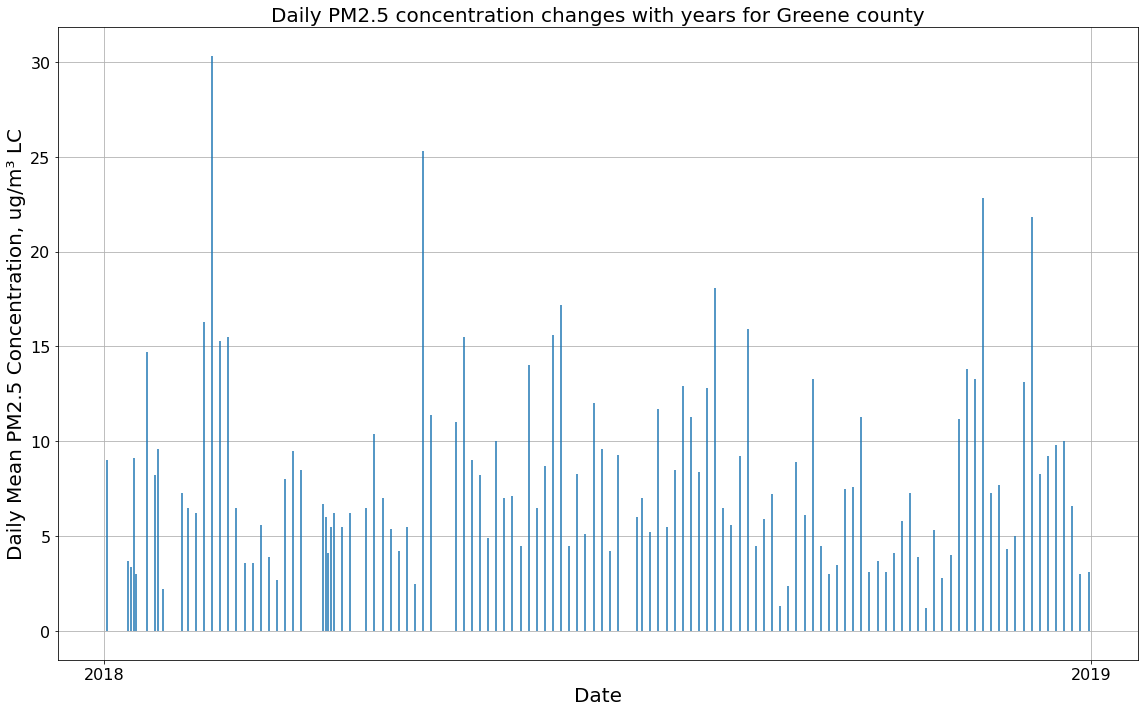

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


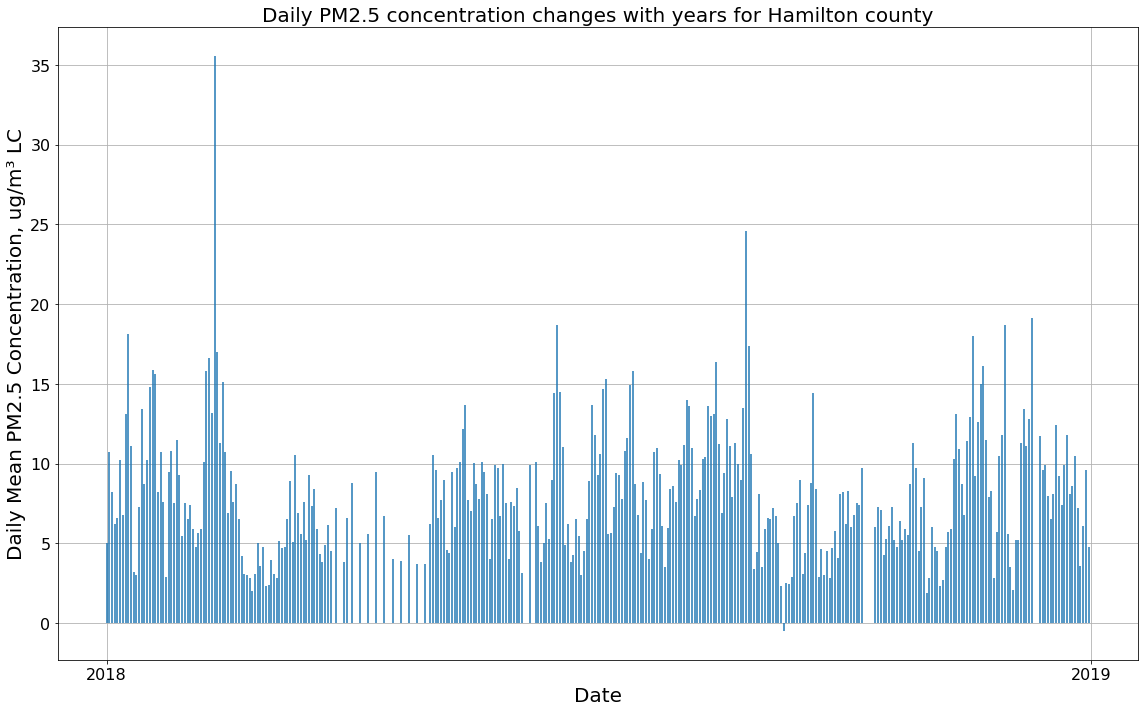

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


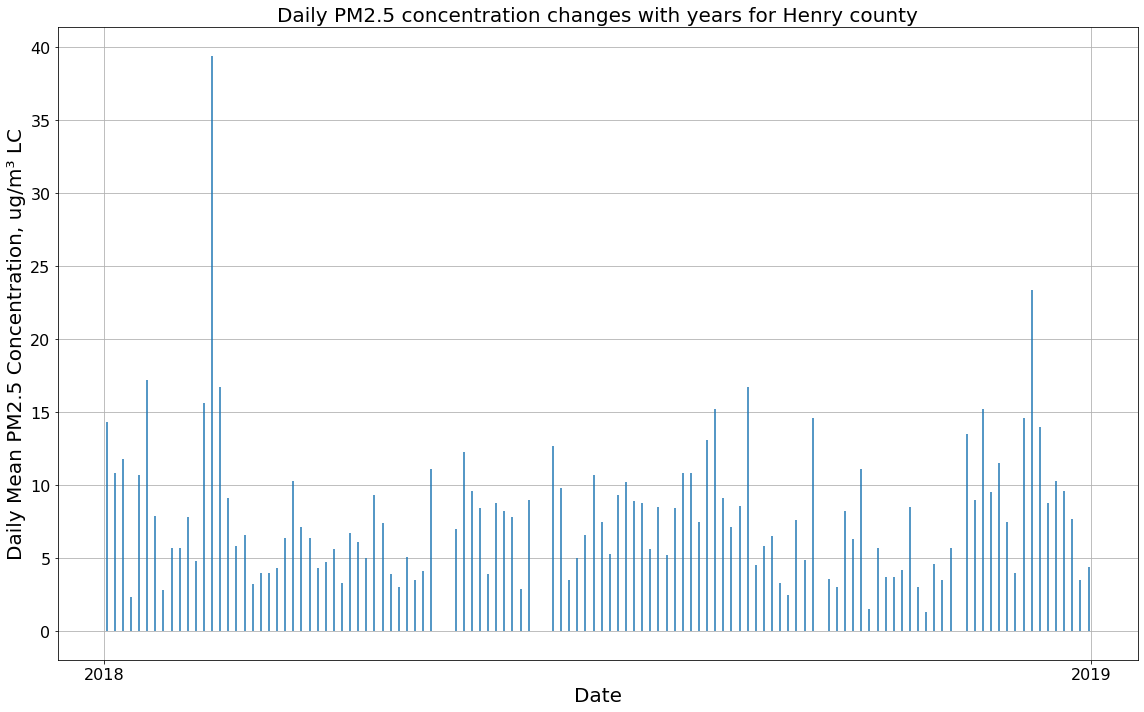

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


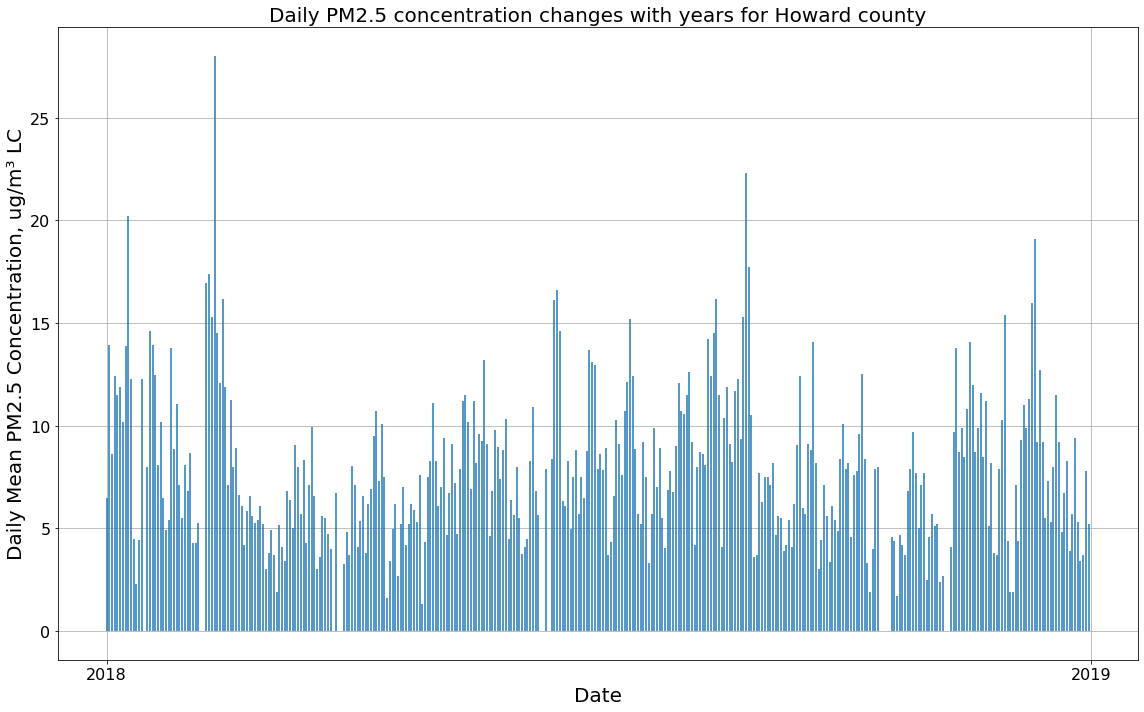

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


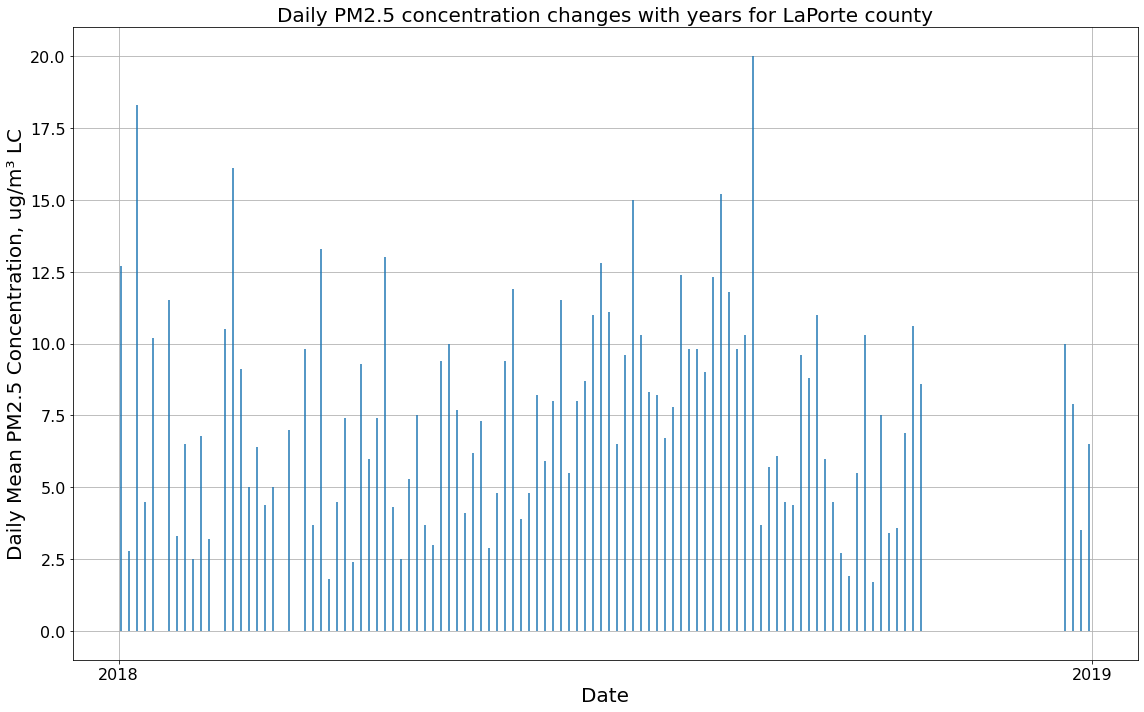

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


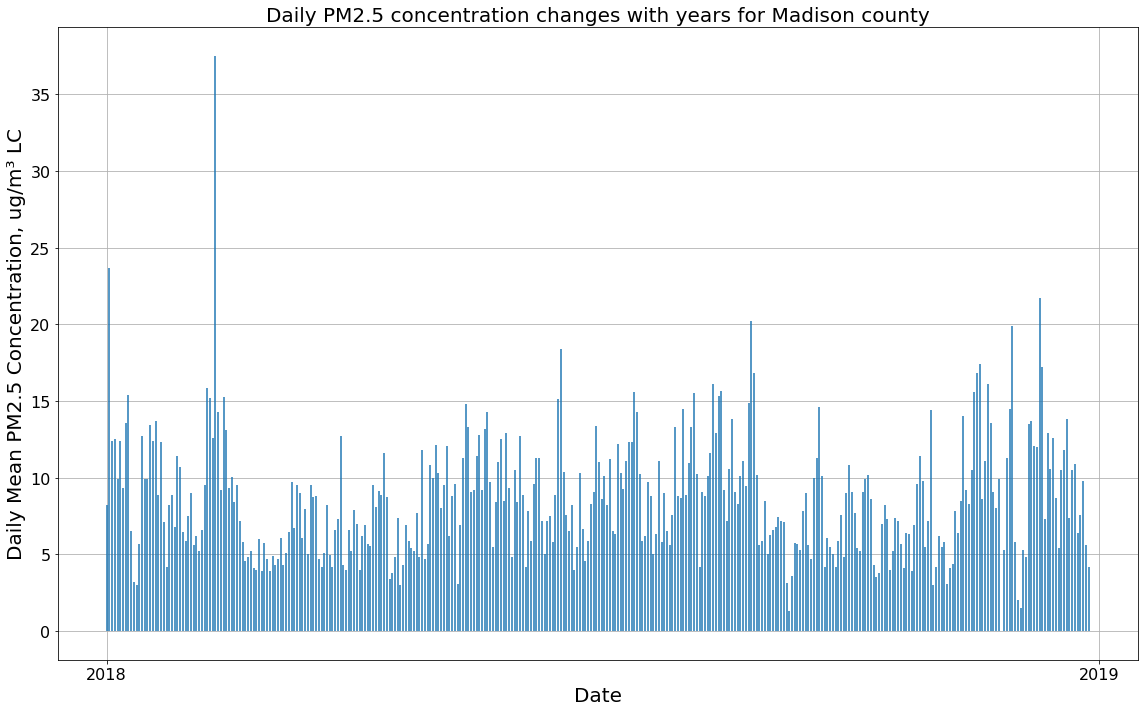

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


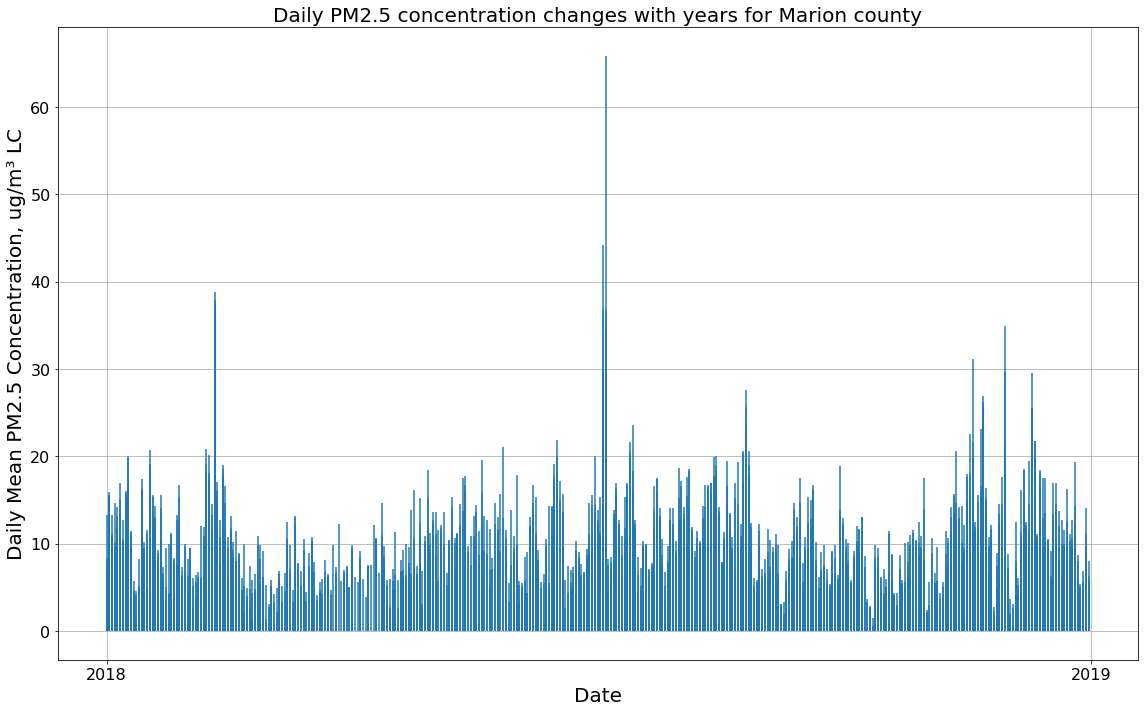

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


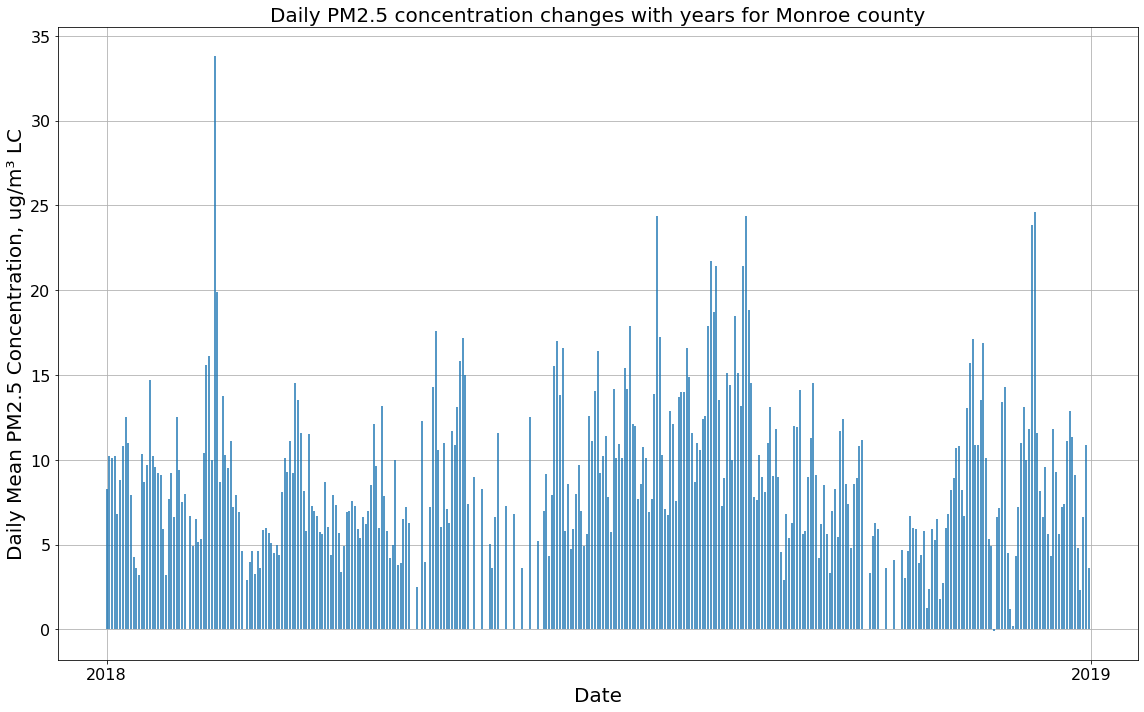

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


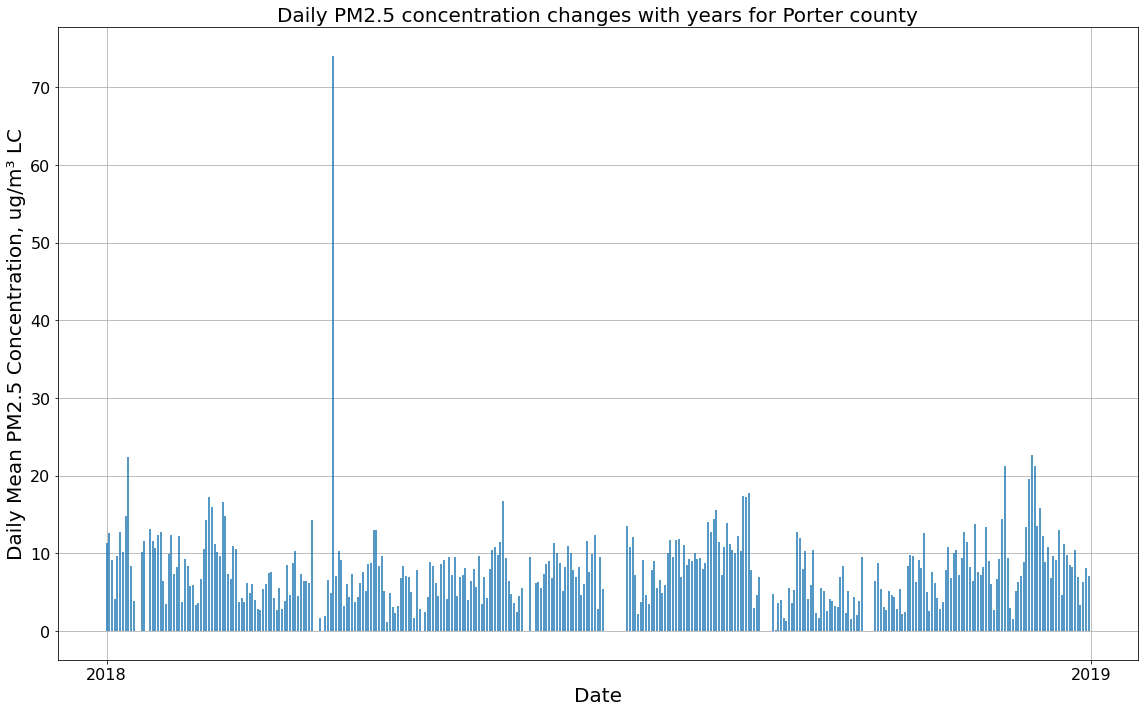

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


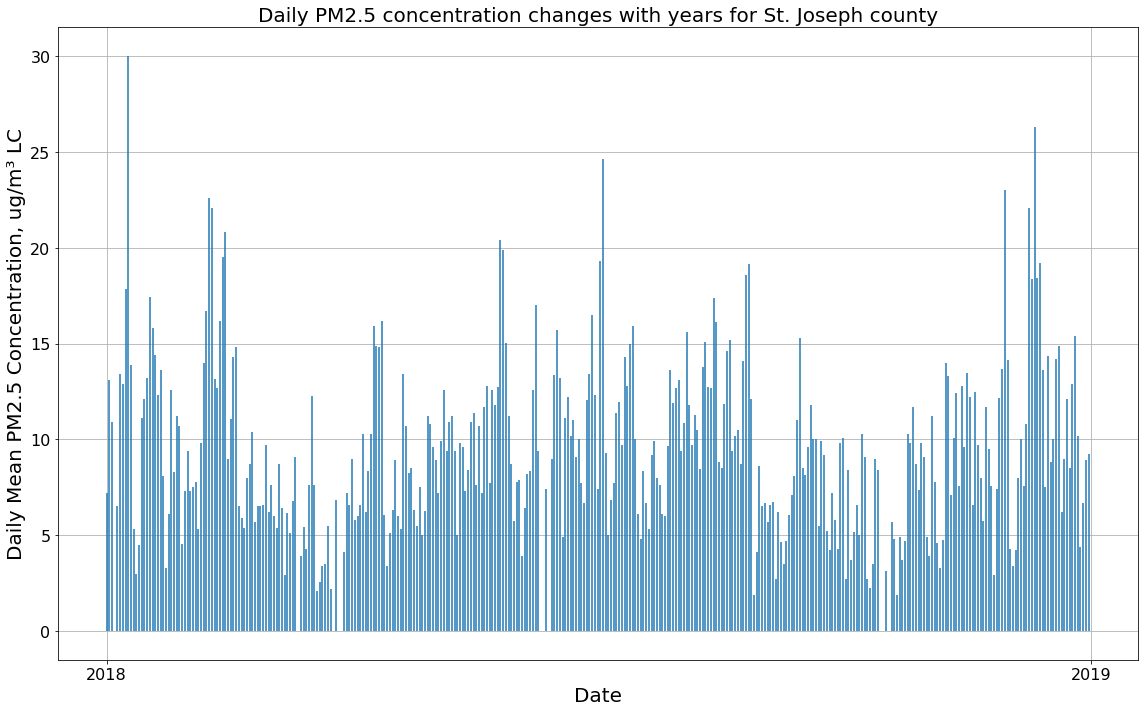

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


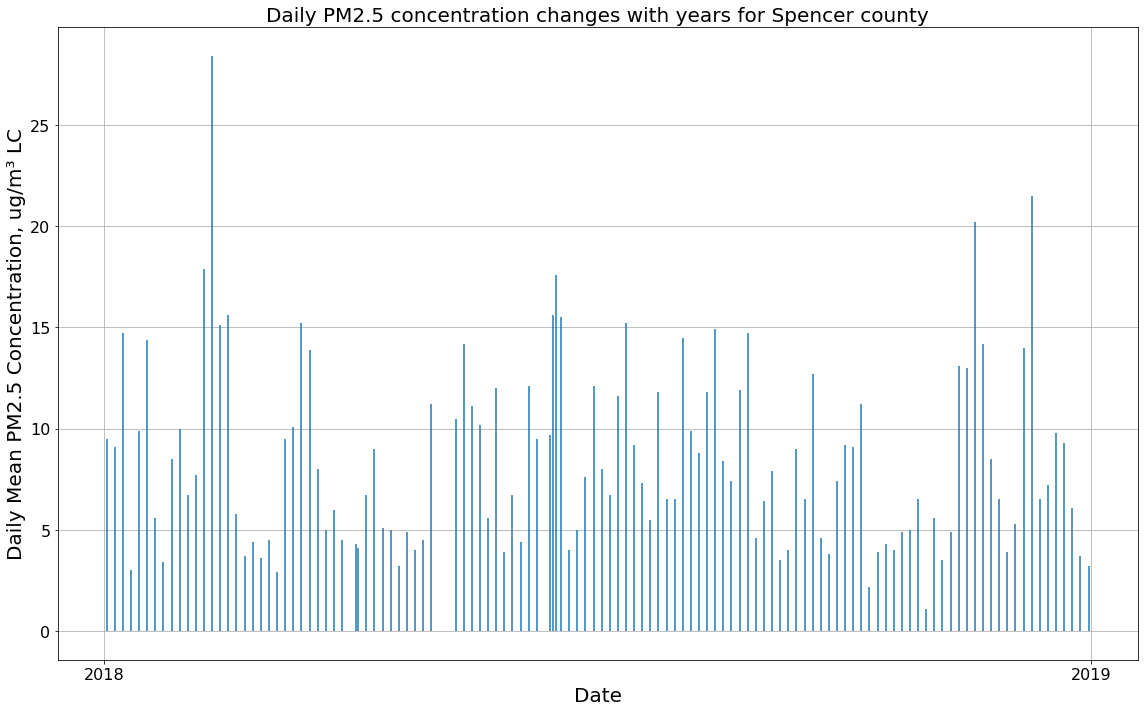

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


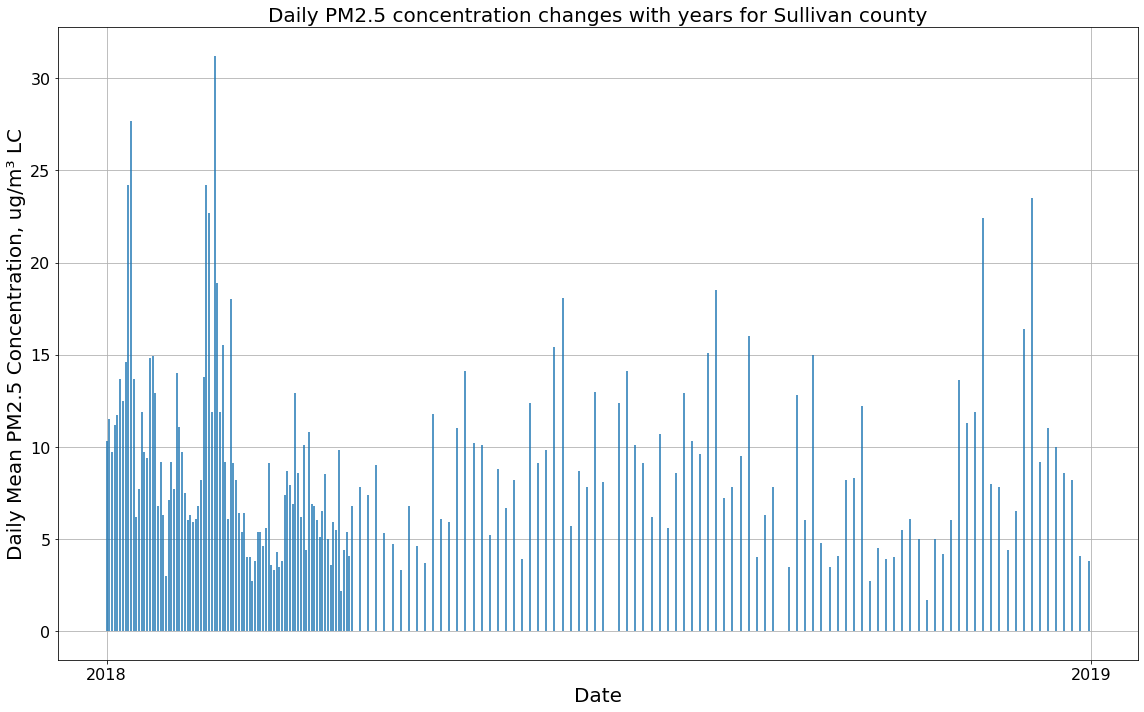

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


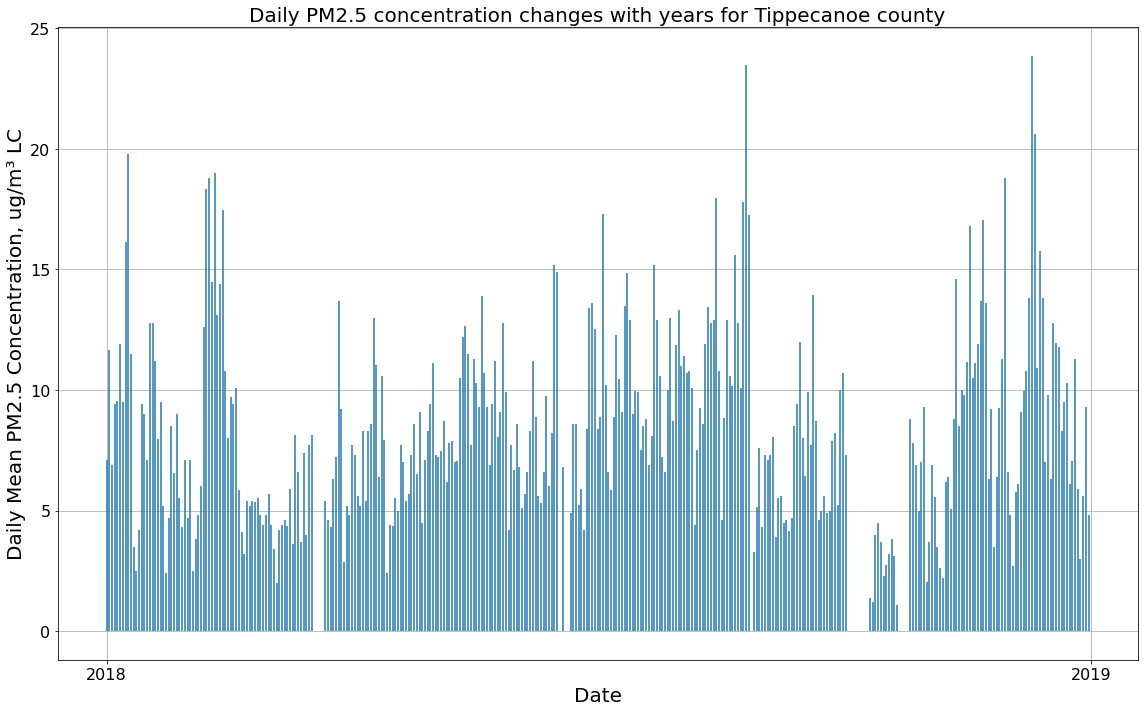

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


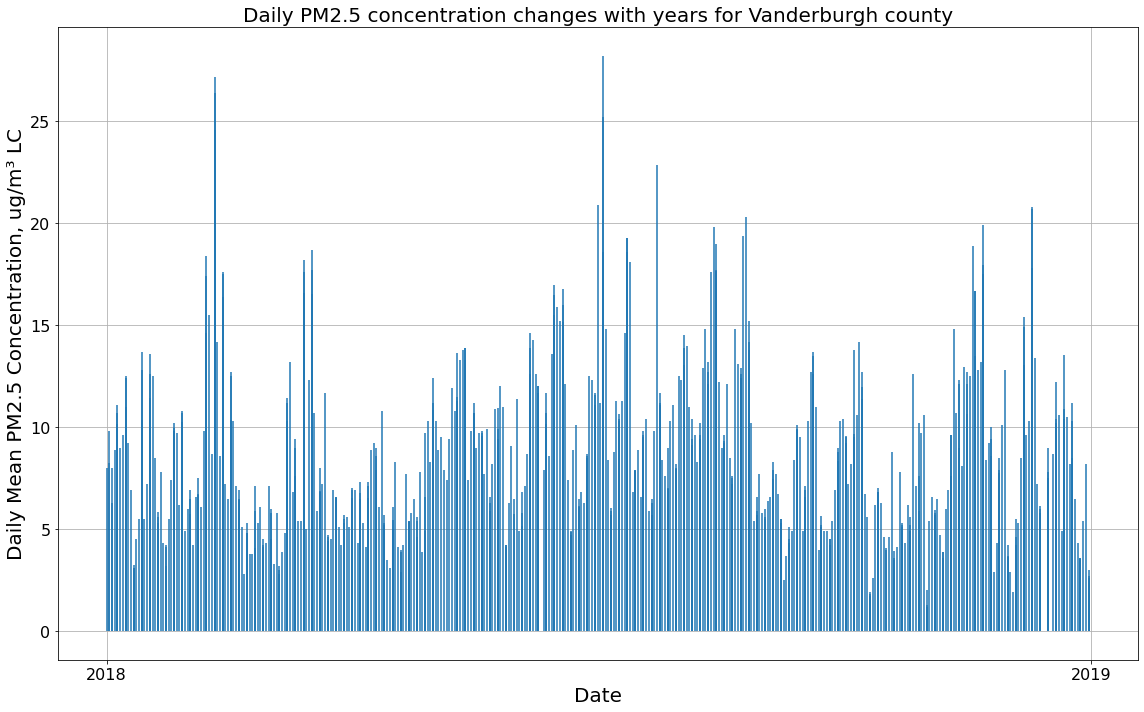

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


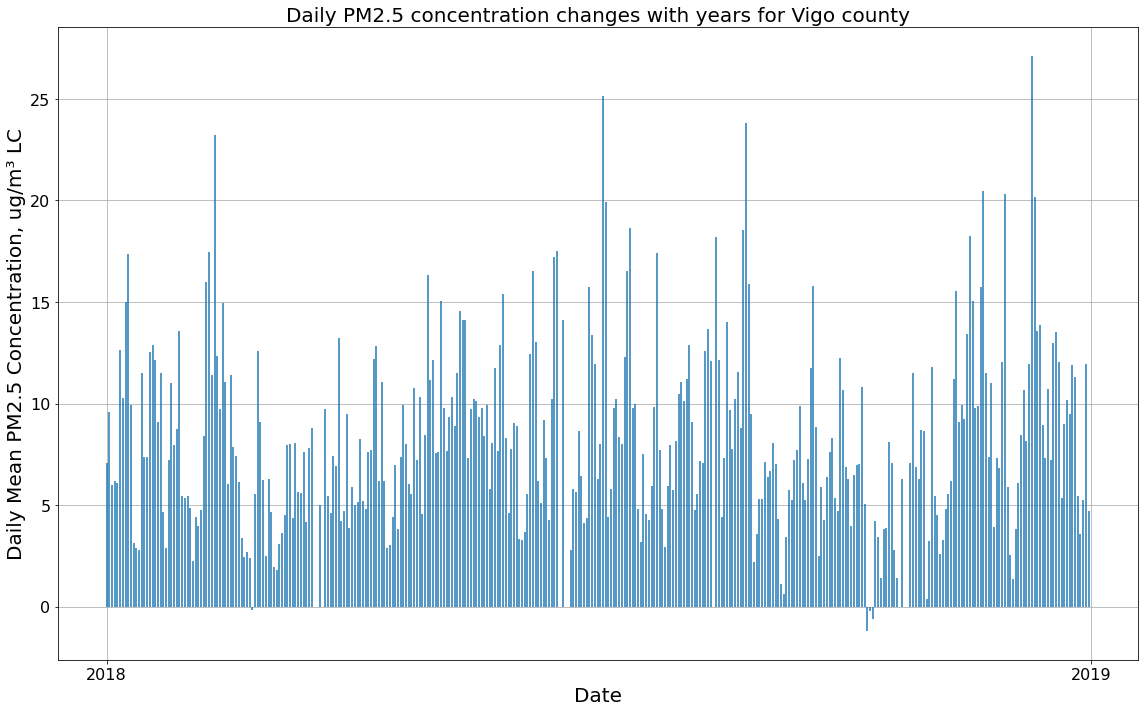

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


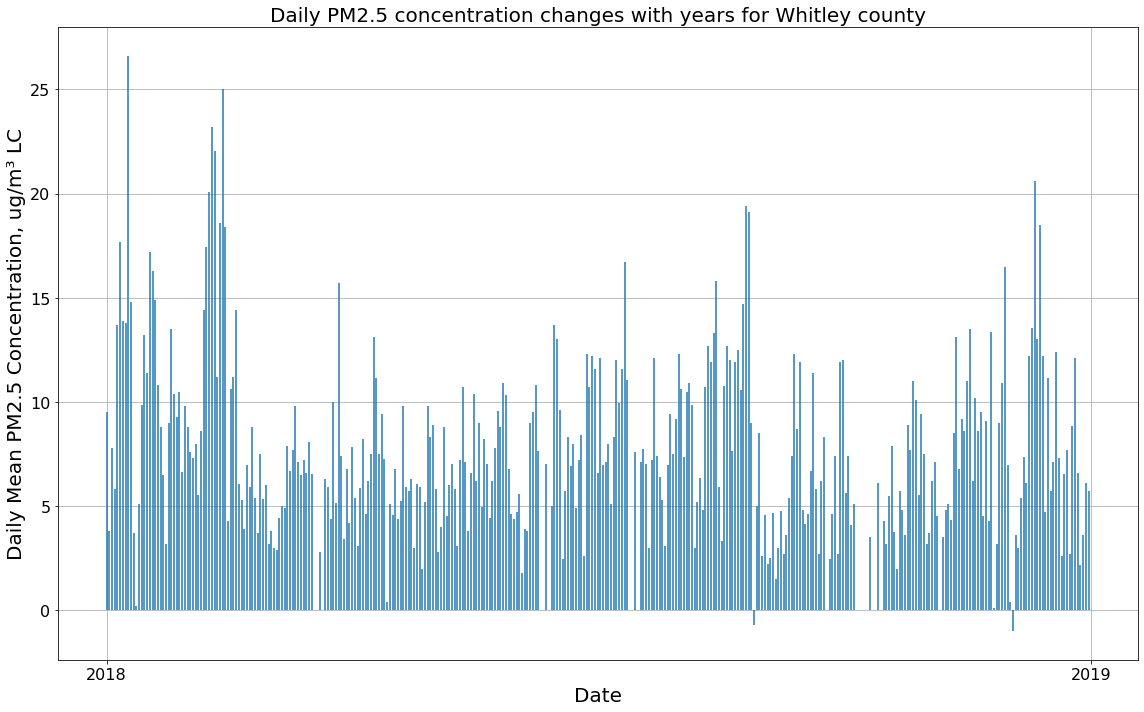

In [123]:
for i in CA.county_names():
    county = County(PATH_TO_DATA, PM25_pattern, i)
    county.county_plot_Daily_PM25()

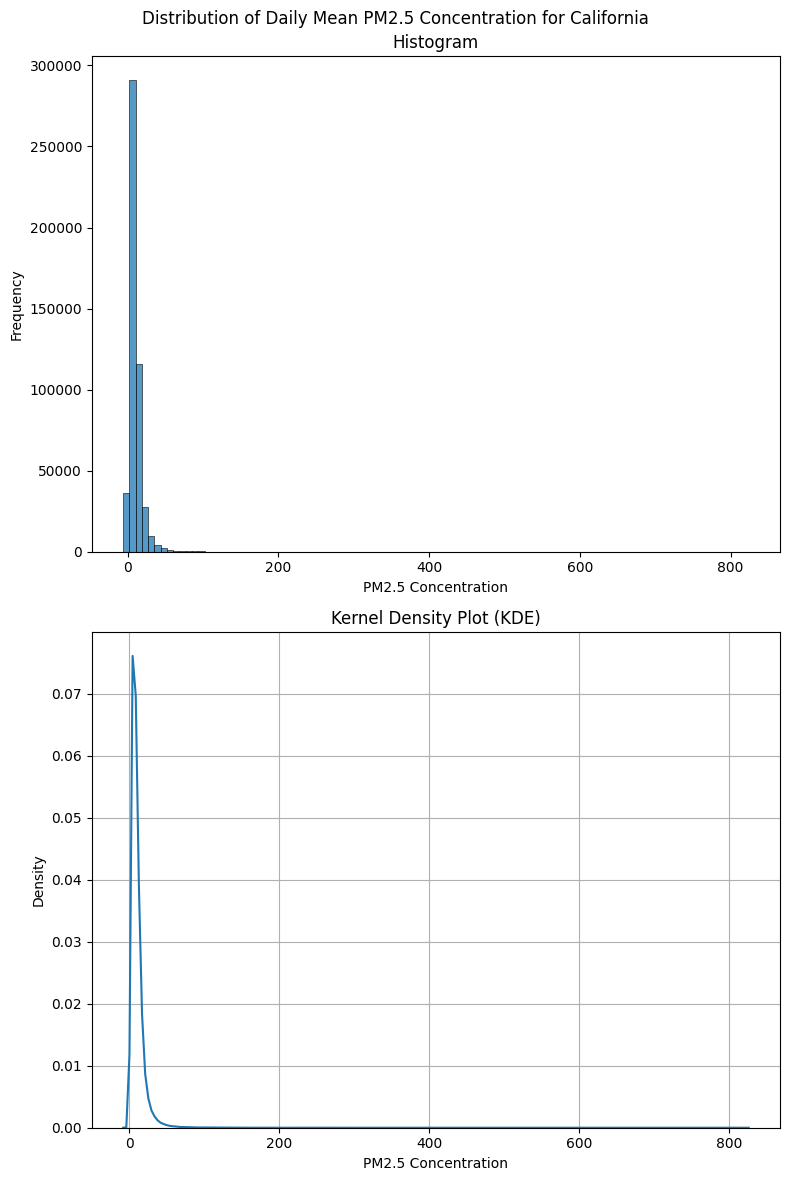

In [119]:
# Create subplots with histograms and KDE plots

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Histogram
sns.histplot(California_df['Daily Mean PM2.5 Concentration'], bins=100, kde=False, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_xlabel('PM2.5 Concentration')
axes[0].set_ylabel('Frequency')

# KDE Plot
sns.kdeplot(California_df['Daily Mean PM2.5 Concentration'], ax=axes[1])
axes[1].set_title('Kernel Density Plot (KDE)')
axes[1].set_xlabel('PM2.5 Concentration')
axes[1].set_ylabel('Density')

# Add a title for the entire plot
plt.suptitle('Distribution of Daily Mean PM2.5 Concentration for California')

# Show the plots
plt.tight_layout()
plt.grid()

plt.savefig("Presentation/Histogram - Distribution of Daily Mean PM2.5 Concentration for California.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [12]:
California_df['Month'] = pd.DatetimeIndex(California_df['Date']).month
California_df['Year_Month'] = pd.DatetimeIndex(California_df['Date']).to_period('M')
California_df['Year'] = pd.DatetimeIndex(California_df['Date']).year
California_df.loc[:,'Date'] = California_df.loc[:, 'Date'].apply(pd.to_datetime)

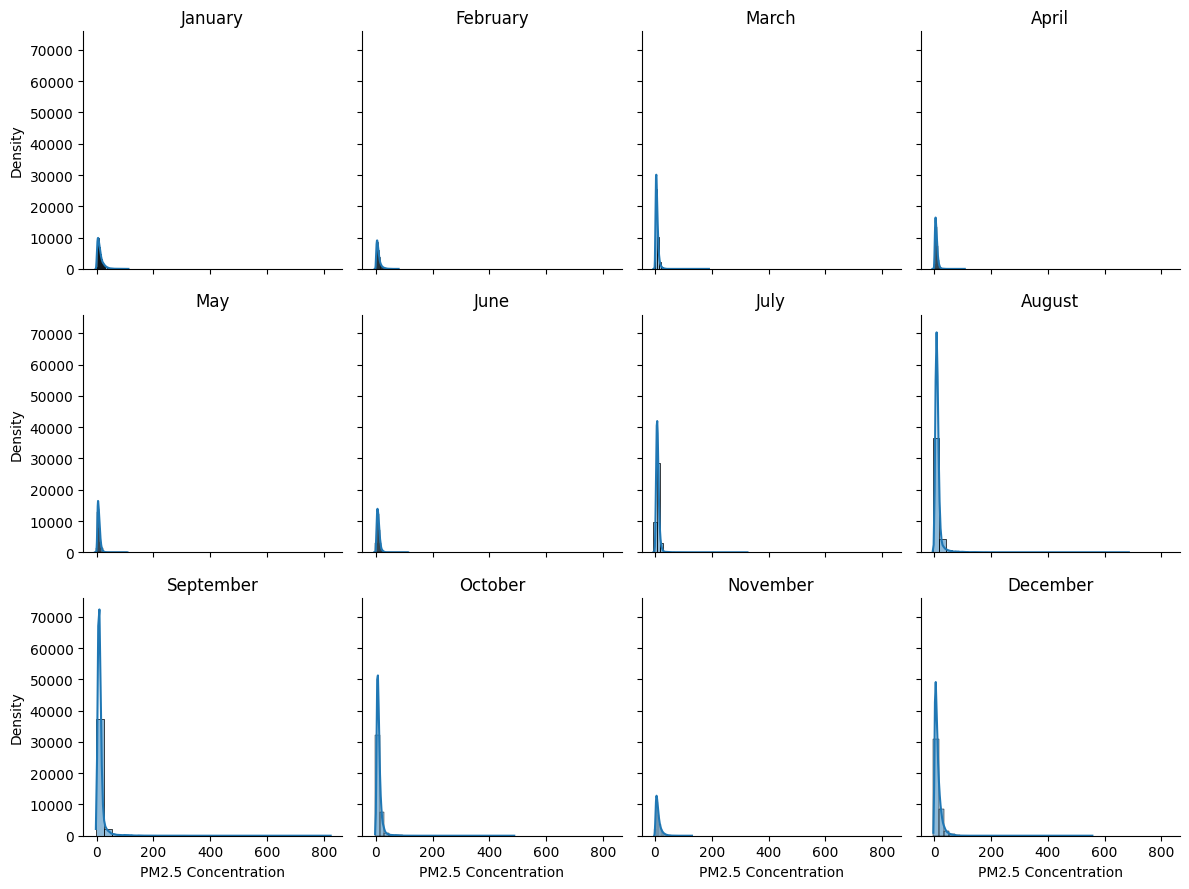

In [120]:
# Create subplots for each month
g = sns.FacetGrid(California_df, col="Month", col_wrap=4, height=3, margin_titles=True)
g.map_dataframe(sns.histplot, x="Daily Mean PM2.5 Concentration", bins=30, kde=True)
g.set_axis_labels("PM2.5 Concentration", "Density")

# Add titles for each subplot
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
for ax, month in zip(g.axes.flat, range(1, 13)):
    ax.set_title(months[month])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/w0/vxwyx06126l456l8k0l589cc0000gn/T/ipykernel_49925/3426955479.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration', palette=clrs)


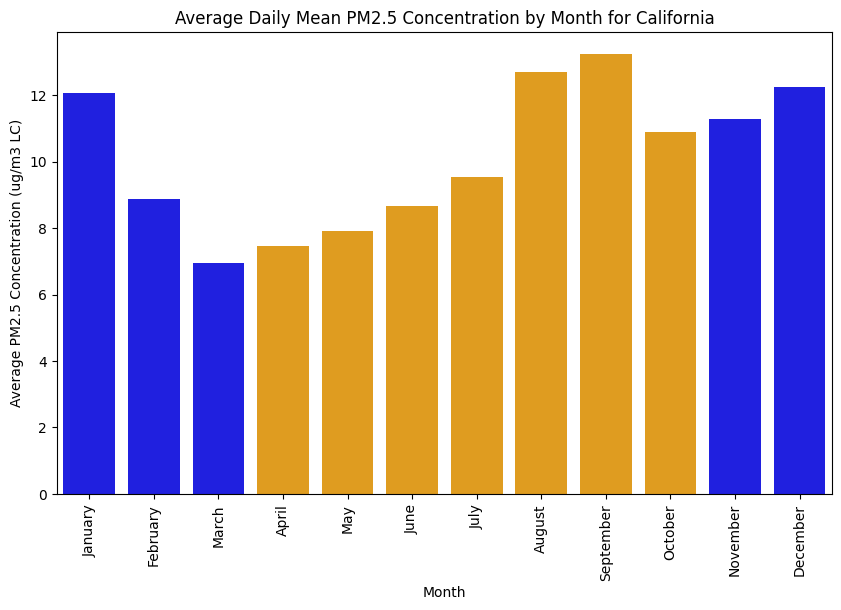

In [121]:
# Calculate the average PM2.5 concentration for each month
average_pm25_by_month = California_df.groupby('Month')['Daily Mean PM2.5 Concentration'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
clrs = ['orange' if (3 < x < 11) else 'blue' for x in average_pm25_by_month.Month ]
sns.barplot(data=average_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration', palette=clrs)

# Customize the plot
plt.title('Average Daily Mean PM2.5 Concentration by Month for California')
plt.xlabel('Month')
plt.ylabel('Average PM2.5 Concentration (ug/m3 LC)')
plt.xticks(range(12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
                        'October', 'November', 'December'], rotation=90)

plt.savefig("Presentation/Barplot - Average Daily Mean PM2.5 Concentration by Month for California.pdf", format="pdf", bbox_inches="tight")
plt.show()

/var/folders/w0/vxwyx06126l456l8k0l589cc0000gn/T/ipykernel_49925/2145046115.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=average_pm25_by_year, x='Year', y='Daily Mean PM2.5 Concentration', palette='viridis')


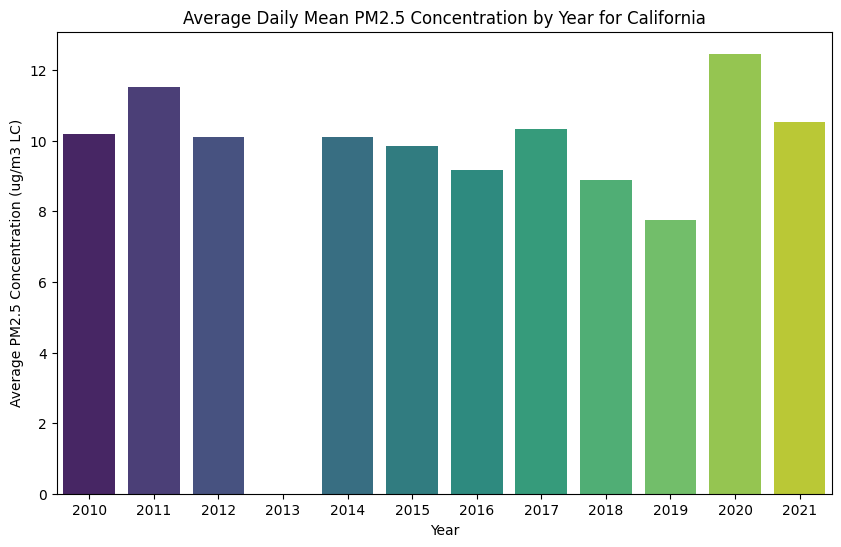

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average PM2.5 concentration for each year
average_pm25_by_year = California_df.groupby('Year')['Daily Mean PM2.5 Concentration'].mean().reset_index()

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=average_pm25_by_year, x='Year', y='Daily Mean PM2.5 Concentration', palette='viridis')

# Customize the plot
plt.title('Average Daily Mean PM2.5 Concentration by Year for California')
plt.xlabel('Year')
plt.ylabel('Average PM2.5 Concentration (ug/m3 LC)')

# Set x ticks for every year
#plt.xticks(rotation=45)

plt.savefig("Presentation/Barplot - Average Daily Mean PM2.5 Concentration by Year for California.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [88]:
California_df

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,...,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,Daily Max 8-hour CO Concentration,Month,Year_Month,Year
491079,2010-01-01 00:00:00,AQS,60374002,1,19.5,ug/m3 LC,67,Long Beach (North),1,100,...,6,California,37,Los Angeles,33.823760,-118.189210,NaN,1,2010-01,2010
494320,2010-01-01 00:00:00,AQS,60470003,3,22.1,ug/m3 LC,72,Merced-Coffee,1,100,...,6,California,47,Merced,37.281853,-120.433671,NaN,1,2010-01,2010
497335,2010-01-01 00:00:00,AQS,60650009,1,11.4,ug/m3 LC,48,Pechanga,1,100,...,6,California,65,Riverside,33.447867,-117.088649,NaN,1,2010-01,2010
489430,2010-01-01 00:00:00,AQS,60371103,1,13.1,ug/m3 LC,53,Los Angeles-North Main Street,1,100,...,6,California,37,Los Angeles,34.066590,-118.226880,NaN,1,2010-01,2010
490424,2010-01-01 00:00:00,AQS,60371201,3,16.6,ug/m3 LC,60,Reseda,1,100,...,6,California,37,Los Angeles,34.199250,-118.532760,NaN,1,2010-01,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44343,2021-12-31 00:00:00,AQS,60772010,3,7.6,ug/m3 LC,32,Manteca,1,100,...,6,California,77,San Joaquin,37.793392,-121.247874,NaN,12,2021-12,2021
11380,2021-12-31 00:00:00,AQS,60271023,1,7.7,ug/m3 LC,32,Bishop Tribe EMO,1,100,...,6,California,27,Inyo,37.362137,-118.417478,NaN,12,2021-12,2021
54480,2021-12-31 00:00:00,AQS,61070009,1,4.7,ug/m3 LC,20,Sequoia & Kings Canyon NPs - Ash Mountain,1,100,...,6,California,107,Tulare,36.489470,-118.829150,NaN,12,2021-12,2021
49103,2021-12-31 00:00:00,AQS,60850006,3,12.0,ug/m3 LC,50,San Jose - Knox Avenue,1,100,...,6,California,85,Santa Clara,37.338135,-121.849783,NaN,12,2021-12,2021


In [123]:
#Selecting data for 2010 - 2019 years to add to the folium map to compare with wildfires
print(California_df.Date.max())
print(California_df.Date.min())

2021-12-31 00:00:00
2010-01-01 00:00:00


In [124]:
California_df_1019 = California_df[California_df.Year <=2019]
California_df_1019

,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,...,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE,Daily Max 8-hour CO Concentration,Month,Year_Month,Year
491079,2010-01-01 00:00:00,AQS,60374002,1,19.5,ug/m3 LC,67,Long Beach (North),1,100,...,6,California,37,Los Angeles,33.823760,-118.189210,NaN,1,2010-01,2010
494320,2010-01-01 00:00:00,AQS,60470003,3,22.1,ug/m3 LC,72,Merced-Coffee,1,100,...,6,California,47,Merced,37.281853,-120.433671,NaN,1,2010-01,2010
497335,2010-01-01 00:00:00,AQS,60650009,1,11.4,ug/m3 LC,48,Pechanga,1,100,...,6,California,65,Riverside,33.447867,-117.088649,NaN,1,2010-01,2010
489430,2010-01-01 00:00:00,AQS,60371103,1,13.1,ug/m3 LC,53,Los Angeles-North Main Street,1,100,...,6,California,37,Los Angeles,34.066590,-118.226880,NaN,1,2010-01,2010
490424,2010-01-01 00:00:00,AQS,60371201,3,16.6,ug/m3 LC,60,Reseda,1,100,...,6,California,37,Los Angeles,34.199250,-118.532760,NaN,1,2010-01,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263250,2019-12-31 00:00:00,AQS,60871005,3,7.7,ug/m3 LC,32,San Lorenzo Valley Middle School,1,100,...,6,California,87,Santa Cruz,37.063150,-122.083092,NaN,12,2019-12,2019
236839,2019-12-31 00:00:00,AQS,60410001,3,8.5,ug/m3 LC,35,San Rafael,1,100,...,6,California,41,Marin,37.972310,-122.520004,NaN,12,2019-12,2019
236486,2019-12-31 00:00:00,AQS,60392010,3,18.2,ug/m3 LC,64,Madera-City,1,100,...,6,California,39,Madera,36.953256,-120.034203,NaN,12,2019-12,2019
236025,2019-12-31 00:00:00,AQS,60379033,1,6.1,ug/m3 LC,25,Lancaster-Division Street,1,100,...,6,California,37,Los Angeles,34.669739,-118.130511,NaN,12,2019-12,2019


In [125]:
California_1019_grouped = California_df_1019[['Year', 'COUNTY', 'Daily Mean PM2.5 Concentration']].groupby(['COUNTY', 'Year'], as_index=False).mean()
California_1019_grouped

,COUNTY,Year,Daily Mean PM2.5 Concentration
0,Alameda,2010,8.196101
1,Alameda,2011,9.461791
2,Alameda,2012,7.708418
3,Alameda,2013,NaN
4,Alameda,2014,8.390549
...,...,...,...
456,Yolo,2014,8.092658
457,Yolo,2015,9.693237
458,Yolo,2016,7.415641
459,Yolo,2017,9.017867


In [126]:
California_1019_county_PM25 = California_1019_grouped[['COUNTY', 'Daily Mean PM2.5 Concentration']].groupby('COUNTY', as_index = False).mean()
California_1019_county_PM25

,COUNTY,Daily Mean PM2.5 Concentration
0,Alameda,8.544595
1,Allen,8.776697
2,Alpine,14.678515
3,Bartholomew,7.526364
4,Butte,9.021192
...,...,...
70,Vanderburgh,8.878852
71,Ventura,8.610644
72,Vigo,8.391698
73,Whitley,7.805727


In [128]:
from pathlib import Path
filepath = Path('California_1019_county_PM25.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
California_1019_county_PM25.to_csv(filepath)

In [134]:
California_df_1019 = California_df[California_df.Year >=2013]
California_1019_grouped = California_df_1019[['Year', 'COUNTY', 'Daily Mean PM2.5 Concentration']].groupby(['COUNTY', 'Year'], as_index=False).mean()
California_1019_county_PM25 = California_1019_grouped[['COUNTY', 'Daily Mean PM2.5 Concentration']].groupby('COUNTY', as_index = False).mean()
California_1019_county_PM25

,COUNTY,Daily Mean PM2.5 Concentration
0,Alameda,8.913545
1,Allen,8.776697
2,Alpine,17.210819
3,Bartholomew,7.526364
4,Butte,9.468573
...,...,...
70,Vanderburgh,8.878852
71,Ventura,8.129803
72,Vigo,8.391698
73,Whitley,7.805727


In [135]:
from pathlib import Path
filepath = Path('California_1322_county_PM25.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
California_1019_county_PM25.to_csv(filepath)

In [131]:
date_county_pm25 = California_df[California_df.Year <=2019][['Date', 'Daily Mean PM2.5 Concentration', 'COUNTY']]
date_county_pm25

,Date,Daily Mean PM2.5 Concentration,COUNTY
491079,2010-01-01 00:00:00,19.5,Los Angeles
494320,2010-01-01 00:00:00,22.1,Merced
497335,2010-01-01 00:00:00,11.4,Riverside
489430,2010-01-01 00:00:00,13.1,Los Angeles
490424,2010-01-01 00:00:00,16.6,Los Angeles
...,...,...,...
263250,2019-12-31 00:00:00,7.7,Santa Cruz
236839,2019-12-31 00:00:00,8.5,Marin
236486,2019-12-31 00:00:00,18.2,Madera
236025,2019-12-31 00:00:00,6.1,Los Angeles


In [132]:
from pathlib import Path
filepath = Path('date_county_pm25.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
date_county_pm25.to_csv(filepath)

In [137]:
date_county_pm25 = California_df[California_df.Year >=2013][['Date', 'Daily Mean PM2.5 Concentration', 'COUNTY']]
date_county_pm25

,Date,Daily Mean PM2.5 Concentration,COUNTY
323413,2013-01-01 00:00:00,NaN,Los Angeles
318319,2013-01-01 00:00:00,NaN,Fresno
336276,2013-01-01 00:00:00,NaN,Santa Barbara
327384,2013-01-01 00:00:00,NaN,Orange
317595,2013-01-01 00:00:00,NaN,Fresno
...,...,...,...
44343,2021-12-31 00:00:00,7.6,San Joaquin
11380,2021-12-31 00:00:00,7.7,Inyo
54480,2021-12-31 00:00:00,4.7,Tulare
49103,2021-12-31 00:00:00,12.0,Santa Clara


In [138]:
from pathlib import Path
filepath = Path('new_date_county_pm25.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
date_county_pm25.to_csv(filepath)